## Quantifying performance of different approximation methods



In [1]:
from mpmath import mp
import tensorflow
import numpy as np
import GPy 
import matplotlib.pyplot as plt
plt.style.use('seaborn')

from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import time
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', family='sans-serif',size=20)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Using TensorFlow backend.


# Main Code

The code shown below can be used to set-up different models and quantify their performace. 

In [2]:
def create_model(input_dimensions = 1, neurons1 = 100, n_layers = 1,
            activation = 'relu', optimizer = 'adam', epochs = 1000):

    model = Sequential()
    for i in range(n_layers):
        if i==0:            
            model.add(Dense(neurons1, input_dim=input_dimensions, 
                            activation = activation)) # 1st hidden layer
        else:
            model.add(Dense(neurons1, input_dim=neurons1, 
                            activation = activation))
    model.add(Dense(1)) 

    model.compile(optimizer=optimizer, loss='mse')
    return model


class Dataset():
    
    def __init__(self, x, y, Xnew, kernel = GPy.kern.RBF(input_dim=1)):
        
        #rescaling training data
        sc_X = StandardScaler()
        self.x = sc_X.fit_transform(x.reshape(-1, 1))
        
        sc_Y = StandardScaler()
        self.y = sc_Y.fit_transform(y.reshape(-1, 1))
                
        self.xnew = sc_X.fit_transform(Xnew.reshape(-1, 1))

        #Defining GP model
        self.m = GPy.models.GPRegression(self.x,self.y,kernel)       
        self.m.optimize()
        self.mu_gp, self.var_gp = self.m.predict(self.xnew)  
        
        
    def plot_dataset(self):
        plt.plot(self.xnew, self.mu)
    
    def plot_GP(self):
        self._m.plot()

        
        
class Accuracy():
    
    def __init__(self, Dataset):
        
        self.x = Dataset.x
        self.y = Dataset.y
        self.xnew = Dataset.xnew
        self.mu_gp = Dataset.mu_gp
        self.var_gp = Dataset.var_gp
        
        self.m = None
        self.mu = None
        self.var = None
        
        self.res_mu = None
        self.res_var = None

        self.mse_mu = None
        self.mse_var = None
        
    def mse(self):
        if self.res_mu is None:
            self.residual()
            
        self.mse_mu = np.mean(self.res_mu**2)
        self.mse_var = np.mean(self.res_var**2)    
        return self.mse_mu, self.mse_var
    
    
    def residual(self):
        self.res_mu = np.abs(self.mu - self.mu_gp)
        self.res_var = np.abs(self.var - self.var_gp)
        return self.res_mu, self.res_var
        
        
        
class Sparse_GP(Accuracy):
    
    def __init__(self, Dataset, num_inducing, kernel = GPy.kern.RBF(input_dim=1), restarts = 1):
        
        super().__init__(Dataset)
        
        self.Z = np.random.rand(num_inducing,1)
        self.m = GPy.models.SparseGPRegression(Dataset.x,Dataset.y, Z=self.Z)
        
        self.m.optimize()   
        self.m.optimize_restarts(num_restarts=restarts)
        self.mu, self.var = self.m.predict(Dataset.xnew)
        

class NN(Accuracy):
    
    def __init__(self, Dataset, neurons=100, epochs = 1000, n_layers = 1):
        
        super().__init__(Dataset)
        
        self.m = KerasRegressor(build_fn = create_model, batch_size= len(self.x), 
                                neurons1 = neurons, epochs=epochs, n_layers = n_layers, 
                                verbose  = 0)
        
        t0 = time.time()
        self.history = self.m.fit(self.x, self.y)
        t1 = time.time() #time of training
        
        self.mu = self.m.predict(Dataset.xnew).reshape(-1, 1)
        
        self.t2 = time.time() - t1
        self.t1 = t1-t0
        
        self.var = np.zeros(self.mu.shape)
        
    def validation(self, splits):
        
        kfold = KFold(n_splits=splits)
        results = cross_val_score(self.m, self.x, self.y, cv=kfold, n_jobs = -1)
        print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
        return results
    
    def get_timing(self):
        return self.t1, self.t2
        
    def plot(self, title):
        fig = plt.figure()
        plt.plot(self.xnew, self.mu, label = 'NN prediction')
        plt.scatter(self.x, self.y, label = 'data')
        plt.plot(self.xnew, self.mu, '--r', label = 'GPs')
        plt.legend()
        plt.title( title)
        return fig
    

    
class qPCA_GP(Accuracy):     
    
    def __init__(self, Dataset, k, eigs = None):
        
        super().__init__(Dataset)
    
        self.K_inv = None
        self.eig_diag = None
        
        A = Dataset.m.kern.K(self.x, self.x) + Dataset.m.Gaussian_noise.variance * np.eye(len(self.x))
    
        if eigs is None:
            eig, U = np.linalg.eigh(A)
        
        else:
            eig, U = eigs
    
        dk = eig/np.max(eig)
        self.eig_diag = np.floor(dk*(2.**k-1.)) 
        self.eig_diag = self.eig_diag/(2**k-1)
        self.eig_diag = self.eig_diag*np.max(eig)
        m = len(np.where(self.eig_diag>0)[0])

        self.K_inv = U[:, -m::]@np.diag(1/self.eig_diag[-m::])@U[:, -m::].T
        ks = Dataset.m.kern.K(self.xnew, self.x)
        
        self.mu = ks@self.K_inv@self.y
        self.var = Dataset.m.rbf.variance - ks@self.K_inv@ks.T #+ Dataset.m.Gaussian_noise.variance
        
        self.m_resolved_eigs = m
 




# Quantifying performance of different methods

## Defining test dataset

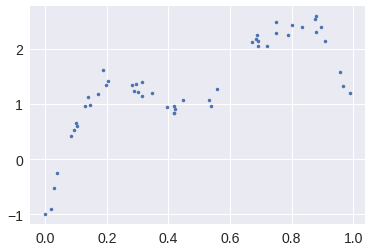

In [3]:
#define sample data:
np.random.seed(1)
n = 50
x = np.random.rand( n)
y =  2*x + np.sin(17*(x-0.5)**2) + np.random.randn(n) * 0.15
#Xnew = np.linspace(0, 1, n)
Xnew = np.linspace(min(x), max(x), n)
plt.plot(x,  y, '.')



## Testing performance of qPCA approximation

In [7]:
T2 = Dataset(x, y, Xnew)

redo = False
ks = np.arange(2, 30)
if redo:
    MSE_qpca = []   
    m_qgp = []
    for k in ks:
        q = qPCA_GP(T2, k)
        MSE_qpca.append(q.mse())
        m_qgp.append(q.m_resolved_eigs)

    MSE_qpca = np.array(MSE_qpca)
    np.save('Data-Accuracy-Complexity-SQGP-NN/MSE_qpca', MSE_qpca) 
    
MSE_qpca = np.load('Data-Accuracy-Complexity-SQGP-NN/MSE_qpca.npy')


## sparse GP

In [8]:

redo = False
ms = np.arange(2, 30, 2)
if redo:
    MSE_SGP = []
    for m in ms:
        MSE_SGP.append(Sparse_GP(T2, m, restarts = 1).mse())

    MSE_SGP = np.array(MSE_SGP)
    np.save('Data-Accuracy-Complexity-SQGP-NN/MSE_SGP', MSE_SGP) 
    
MSE_SGP = np.load('Data-Accuracy-Complexity-SQGP-NN/MSE_SGP.npy')

    


## Results: qPCA vs Sparse GP


Here, we compare the performance of classical low-rank approximation induced in Sparse Gaussian Processes via  inducing points, against the approximation induced via qPCA. Note that here we compare only the low-rank approximation. 

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/mathtext.py:2461: SyntaxWarning:Exception creating Regex for oneOf, building MatchFirst


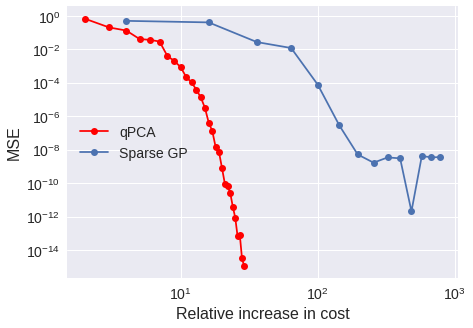

In [9]:
fig = plt.figure(figsize = (7, 5))
ax = plt.subplot(111)

plt.loglog(ks, MSE_qpca[:, 0], '-or', label = 'qPCA')
plt.ylabel('MSE')
plt.xlabel('Relative increase in cost')

plt.loglog(ms**2, MSE_SGP[:, 0], '-o', label = 'Sparse GP')

#plt.title('Accuracy-complexity trade-off', size = 18)

ax.legend(loc='center left')

fig.savefig('Figures/4_accuracy_comparison_without_NNs.pdf', inches = 'tight')

## NNs

### varying neurons

In [10]:
redo = False
neurons = np.logspace(2, 4, 10)

if redo:
    MSE_NN = []
    for ni in neurons:
        MSE_NN.append(NN(T2, neurons = int(np.round(ni)), n_layers = 1).mse())

    MSE_NN = np.array(MSE_NN)
    np.save('Data-Accuracy-Complexity-SQGP-NN/MSE_NN', MSE_NN) 

MSE_NN  = np.load('Data-Accuracy-Complexity-SQGP-NN/MSE_NN.npy')


### 2 layers, varying  nuerons

In [11]:
redo = False
neurons = np.logspace(2, 3, 10)

if redo:
    MSE_NN2 = []
    for ni in neurons:
        MSE_NN2.append(NN(T2, neurons = int(np.round(ni)), n_layers = 2).mse())

    MSE_NN2 = np.array(MSE_NN2)
    np.save('Data-Accuracy-Complexity-SQGP-NN/MSE_NN2', MSE_NN2) 
    
MSE_NN2  = np.load('Data-Accuracy-Complexity-SQGP-NN/MSE_NN2.npy')


### Varying epochs

In [12]:
redo = False
if redo:
    MSE_NN_e = []
    epochs = np.logspace(2, 4, 10)

    for eps in epochs:
        MSE_NN_e.append(NN(T2, neurons = 1000, n_layers = 1, epochs = int(eps)).mse())

    MSE_NN_e = np.array(MSE_NN_e)
    np.save('Data-Accuracy-Complexity-SQGP-NN/MSE_NN_e', MSE_NN_e) 
    
MSE_NN_e  = np.load('Data-Accuracy-Complexity-SQGP-NN/MSE_NN_e.npy')
    

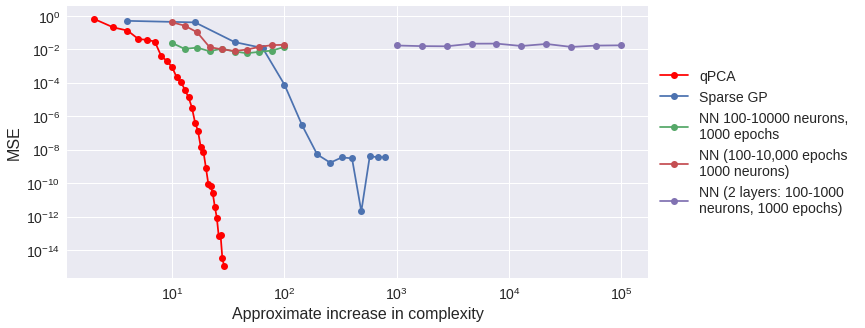

In [13]:
fig = plt.figure(figsize = (13, 5))
ax = plt.subplot(111)

plt.loglog(ks, MSE_qpca[:, 0], '-or', label = 'qPCA')
plt.ylabel('MSE')
plt.xlabel('Approximate increase in complexity')

plt.loglog(ms**2, MSE_SGP[:, 0], '-o', label = 'Sparse GP')

plt.loglog(neurons/10, MSE_NN[:, 0], '-o', label = 'NN 100-10000 neurons, \n1000 epochs')
plt.loglog(neurons/10, MSE_NN_e[:, 0], '-o', label = 'NN (100-10,000 epochs \n1000 neurons)')

plt.loglog(neurons**2/10, MSE_NN2[:, 0], '-o', label = 'NN (2 layers: 100-1000 \nneurons, 1000 epochs)')


#plt.title('Accuracy-complexity trade-off', size = 18)


box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.savefig('Figures/10_accuracy_comparison.pdf',bbox_extra_artists=[lgnd], bbox_inches='tight')

# END

Text(0.5, 1.0, 'qPCA vs Sparse GP')

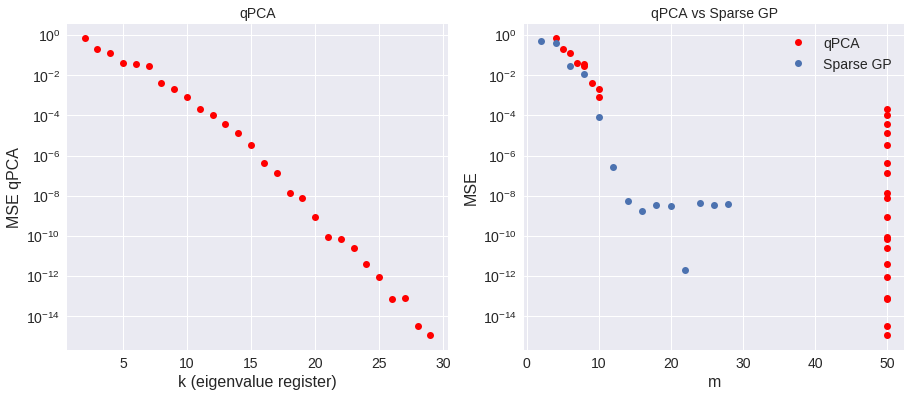

In [23]:
plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.semilogy(ks, MSE_qpca[:, 0], 'or')
plt.ylabel('MSE qPCA')
plt.xlabel('k (eigenvalue register)')
plt.title('qPCA')


plt.subplot(1, 2, 2)
plt.semilogy(m_qgp, MSE_qpca[:, 0], 'ro', label = 'qPCA')
plt.xlabel('m')
plt.plot(ms, MSE_SGP[:, 0], 'o', label = 'Sparse GP')
plt.legend()
plt.ylabel('MSE')
plt.title('qPCA vs Sparse GP')

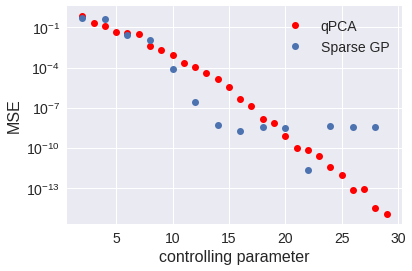

In [24]:
plt.semilogy(ks, MSE_qpca[:, 0], 'or', label = 'qPCA')
plt.ylabel('MSE')
plt.xlabel('controlling parameter')

plt.plot(ms, MSE_SGP[:, 0], 'o', label = 'Sparse GP')
plt.legend()


# END

In [266]:
q.mu[:, 0].shape

(50,)

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning:invalid value encountered in sqrt


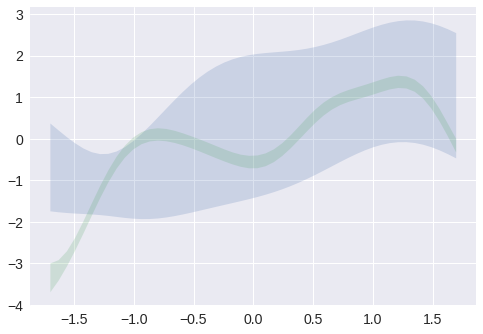

In [279]:
T2 = Dataset(x, y, Xnew)

k = 2
q = qPCA_GP(T2, k)

plt.fill_between(q.xnew[:, 0], (q.mu - np.sqrt(q.var))[:, 0], (q.mu+np.sqrt(q.var))[:, 0], alpha = 0.2)
plt.fill_between(T2.xnew[:, 0], (T2.mu_gp - np.sqrt(T2.var_gp))[:, 0], 
                 (T2.mu_gp+np.sqrt(T2.var_gp))[:, 0], alpha = 0.2)


In [282]:
q.res_var

TypeError: 'NoneType' object is not callable

In [252]:
MSE_NN = np.array(MSE_NN)

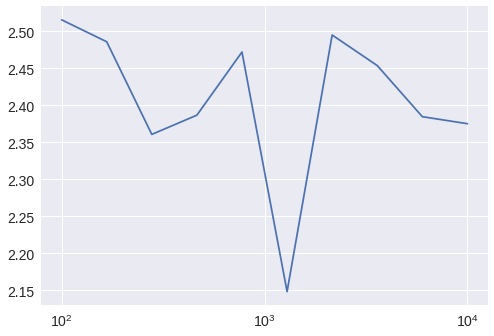

In [254]:
plt.semilogx(neurons, MSE_NN[:, 0])

In [255]:
ni

10000.0

10
1
1000
100
1
1000
1000
1
1000


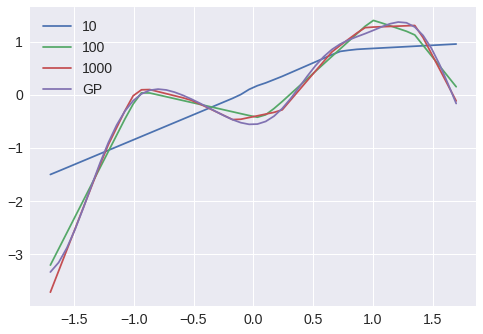

In [351]:
T2 = Dataset(x, y, Xnew)

nn1 = NN(T2, neurons = 10)
nn2 = NN(T2, neurons = 100)
nn3 = NN(T2, neurons = 1000)


plt.plot(nn1.xnew, nn1.mu, label = '10')
plt.plot(nn2.xnew, nn2.mu, label = '100')
plt.plot(nn3.xnew, nn3.mu, label = '1000')

plt.plot(nn1.xnew, T2.mu_gp, label = 'GP')
plt.legend()

In [352]:
nn1.mse()

(0.4361508315288912, 0.0008451593072350944)

In [353]:
T2.mu_gp.shape

(50, 1)

In [354]:
nn2.mse()

(0.01865712822427401, 0.0008451593072350944)

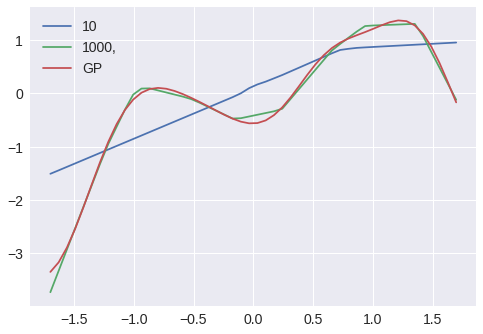

In [356]:
T2 = Dataset(x, y, Xnew)


plt.plot(nn1.xnew, nn1.mu, label = '10')
plt.plot(nn3.xnew, nn3.mu, label = '1000,')

plt.plot(nn1.xnew, T2.mu_gp, label = 'GP')
plt.legend()

{'batch_size': 50,
 'neurons1': 1000,
 'epochs': 10000,
 'n_layers': 2,
 'verbose': 0,
 'build_fn': <function __main__.create_model(input_dimensions=1, neurons1=100, n_layers=1, activation='relu', optimizer='adam', epochs=1000)>}

In [238]:
A = T2.m.kern.K(T2.x, T2.x) + T2.m.Gaussian_noise.variance * np.eye(len(T2.x))

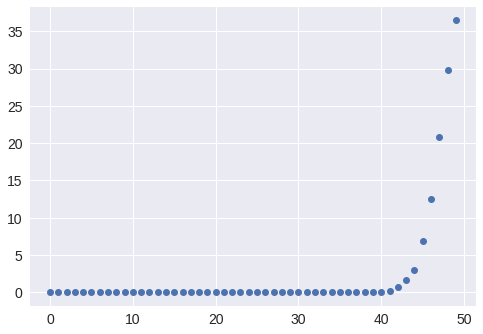

In [242]:
eigs, eigvs = np.linalg.eigh(A)
plt.plot(eigs, 'o')

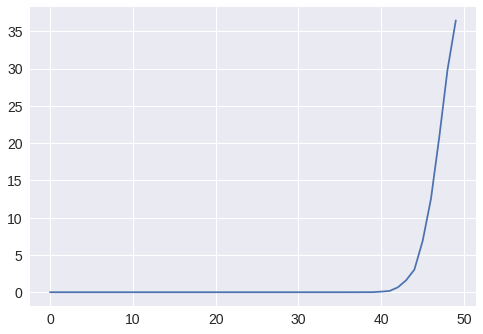

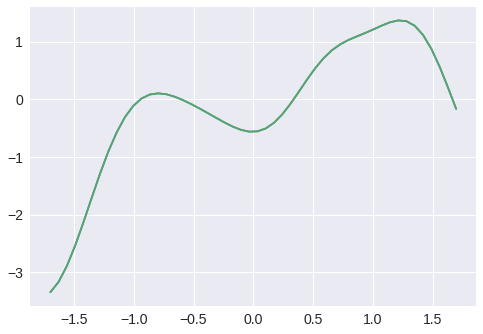

In [218]:
plt.plot(q1.xnew, q1.mu)
plt.plot(q1.xnew, q1.mu_gp)

In [176]:
G1 = Sparse_GP(T1, 2)

Optimization restart 1/1, f = 52.98903633160966


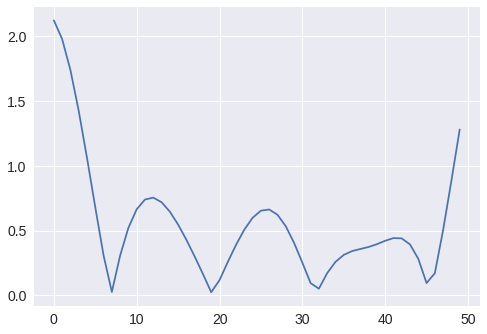

In [177]:
plt.plot(G1.residual()[0])

In [178]:
T2 = Dataset(x, y, Xnew)
nn1 = NN(T2, neurons = 100)

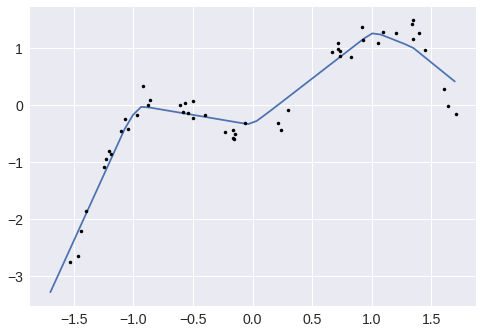

In [182]:
plt.plot(nn1.xnew, nn1.mu)
plt.plot(nn1.x, nn1.y, '.k')

In [183]:
def create_model(input_dimensions = 1, neurons1 = 100,
                activation = 'relu', optimizer = 'adam', epochs = 1000):

    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, 
                    activation = activation)) # 1st hidden layer
    model.add(Dense(1))       
    model.compile(optimizer=optimizer, loss='mse')
    return model


class test_accuracy():
    
    def __init__(self, x, y, Xnew, kernel = GPy.kern.RBF(input_dim=1)):
        
        sc_X = StandardScaler()
        self._x = sc_X.fit_transform(x.reshape(-1, 1))
        
        sc_Y = StandardScaler()
        self._y = sc_Y.fit_transform(y.reshape(-1, 1))
        
        #sc_xn = StandardScaler()
        self._xnew = sc_X.fit_transform(Xnew.reshape(-1, 1))


        self._m = GPy.models.GPRegression(self._x,self._y,kernel)
        
        self._m.optimize()
        #m.plot()
        self._mu, self._var = self._m.predict(self._xnew) 
        plt.plot(self._xnew, self._mu)
        
        self._eig = None


    def Sparse_GP_error(self, num_inducing = 10, 
                        kernel = GPy.kern.RBF(input_dim=1) , 
                        plot = False):
        
        Z = np.random.rand(num_inducing,1)
        m_sp = GPy.models.SparseGPRegression(self._x,self._y, Z=Z)
        m_sp.optimize()   
        m_sp.optimize_restarts(num_restarts=2)
        mu_sp, var_sp = m_sp.predict(self._xnew)
        
        if plot:
            m_sp.plot()
            plt.show()
            
        res_mu = np.abs(mu_sp - self._mu)
        res_var = np.abs(var_sp - self._var)
        
        mse_mu = np.mean(res_mu**2)
        mse_var = np.mean(res_var**2)
        
        return mse_mu, mse_var
        
    # MLP
    
    def MLP_NN_error(self, neurons1 = 100, epochs  = 10000,plot = False):

        NN_model = KerasRegressor(build_fn = create_model, batch_size=len(self._x), 
                                  neurons1 = neurons1, epochs=epochs, verbose  = 0)
        t0 = time.time()
        history = NN_model.fit(self._x, self._y)
        t1 = time.time() #time of training
        predictions = NN_model.predict(self._xnew)
        t2 = time.time() - t1
        t1 = t1-t0
        
        if plot:
            plt.plot(self._xnew, predictions, label = 'NN prediction')
            plt.scatter(self._x, self._y, label = 'data')
            plt.plot(self._xnew, self._mu, '--r', label = 'GPs')
            plt.legend()
            plt.title(str(neurons1) + ' neurons, ' + str(epochs) + ' epochs')
            #plt.show()
        
        mse = np.mean((predictions - self._mu)**2)
        
        kfold = KFold(n_splits=5)
        results = cross_val_score(NN_model, self._x, self._y, cv=kfold, n_jobs = -1)
        print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))
        times = [t1, t2]
        
        return mse, np.mean(results), times

    def GP_approx(self, param, method = 'qPCA', plot= 'True'):
        ks = self._m.kern.K(self._xnew, self._x)
        s2 = self._m.rbf.variance
        sn2 = self._m.Gaussian_noise.variance        
        
        if method == 'Nystrom':
            Approx= self.GP_naive_Nystrom(param)
            m_num = param
            mu = np.dot(ks, np.linalg.lstsq(Approx, self._y, rcond = -1)[0])
            cov = s2 - np.dot(ks, np.linalg.lstsq( Approx, ks.T, rcond = -1)[0]) + sn2
        elif method == 'qPCA':
            Approx, m_num = self.qPCA_approx(param)
            mu = np.dot(ks, np.dot(Approx, self._y))
            cov = s2 - np.dot(ks, np.dot(Approx, ks.T)) + sn2


        res_mu = np.abs(self._mu - mu)
        res_var = np.abs(self._var - cov)
        
        mse_mu = np.mean(res_mu**2)
        mse_var = np.mean(res_var**2)
        print(self._mu.shape)
        if plot:
            plt.plot(self._xnew, mu, label = 'approx')
            plt.plot(self._xnew, self._mu, label ='Exact')
            plt.plot(self._x, self._y, 'or', label = 'data')
            plt.legend()
            plt.show()
            
        return mse_mu, mse_var, m_num       
    
    def GP_naive_Nystrom(self, m):        
        A = self._m.kern.K(self._x, self._x) 
        n = len(A)
        nmis = np.random.choice(int(n), int(n-m), replace=False, p=None)
        Knm = np.delete(A,nmis, axis =0)
        Kmm = np.delete(Knm, nmis, axis = 1)
        Approx = Knm.T@np.linalg.lstsq(Kmm, Knm, rcond = -1)[0]
        
        return Approx
    
    def qPCA_approx(self, k):       
        A = self._m.kern.K(self._x, self._x) + self._m.Gaussian_noise.variance * np.eye(len(self._x))
        if self._eig is None:
            #eig, self._eigenvectors = np.linalg.eigh(A)
            #self._eig = np.abs(eig.real)
            #self._eigenvectors = self._eigenvectors.real
        
            u, s, vh = np.linalg.svd(A, full_matrices=True)
            self._eig = s
            self._u = u
            self._vh = vh
            
        dk = self._eig/np.max(self._eig)
        dk_a = np.floor(dk*(2.**k-1.)) 

        dk_a = dk_a/(2**k-1)
        dk_a = dk_a*np.max(self._eig)
        #dk_a.astype(np.longdouble)
        m = len(np.where(dk_a>0)[0])

        
        #D_inv= np.zeros(dk_a.shape)
        #D_inv[:m] = np.true_divide(np.ones(dk_a[:m].shape), dk_a[:m], dtype = np.longdouble)#1/dk_a[:m]
        #Dapprox = self._eigenvectors@np.diag(D_inv)@self._eigenvectors.T
        D = np.zeros(dk_a.shape)
        D[-m::] = 1./dk_a[-m::]
        #Dapprox = np.dot(self._eigenvectors[:, -m::], np.linalg.lstsq(np.diag(D[-m::]),self._eigenvectors[:, -m::].T)[0])
        D_approx = self._u[:, :m]@np.diag(1/dk_a[:m])@self._vh[:m, :]
        return D_approx, m
    
    

In [89]:
s2 = T1._m.rbf.variance


In [92]:
self = T1
sn2 = T1._m.Gaussian_noise.variance

A = self._m.kern.K(self._x, self._x) + np.eye(len(self._x))*sn2
if self._eig is None:
    #eig, self._eigenvectors = np.linalg.eigh(A)
    #self._eig = np.abs(eig.real)
    #self._eigenvectors = self._eigenvectors.real

    u, s, vh = np.linalg.svd(A, full_matrices=True)
    self._eig = s
    self._u = u
    self._vh = vh

dk = self._eig/np.max(self._eig)
dk_a = np.floor(dk*(2.**k-1.)) 

dk_a = dk_a/(2**k-1)
dk_a = dk_a*np.max(self._eig)
#dk_a.astype(np.longdouble)
m = len(np.where(dk_a>0)[0])


#D_inv= np.zeros(dk_a.shape)
#D_inv[:m] = np.true_divide(np.ones(dk_a[:m].shape), dk_a[:m], dtype = np.longdouble)#1/dk_a[:m]
#Dapprox = self._eigenvectors@np.diag(D_inv)@self._eigenvectors.T
D = np.zeros(dk_a.shape)
D[-m::] = 1./dk_a[-m::]
#Dapprox = np.dot(self._eigenvectors[:, -m::], np.linalg.lstsq(np.diag(D[-m::]),self._eigenvectors[:, -m::].T)[0])
D_approx = self._u[:, :m]@np.diag(1/dk_a[:m])@self._vh[:m, :]


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning:divide by zero encountered in true_divide


In [79]:
D_approx

array([[ 0.00897196, -0.00414051,  0.0050996 , ..., -0.00226578,
        -0.00270846, -0.00219944],
       [-0.00414051,  0.00797793, -0.00427685, ...,  0.00194948,
         0.00220109,  0.00087203],
       [ 0.0050996 , -0.00427685,  0.01569388, ..., -0.00959452,
        -0.0099208 ,  0.00238526],
       ...,
       [-0.00226578,  0.00194948, -0.00959452, ...,  0.00842062,
         0.00865514,  0.00012329],
       [-0.00270846,  0.00220109, -0.0099208 , ...,  0.00865514,
         0.00891466,  0.00027584],
       [-0.00219944,  0.00087203,  0.00238526, ...,  0.00012329,
         0.00027584,  0.00318733]])

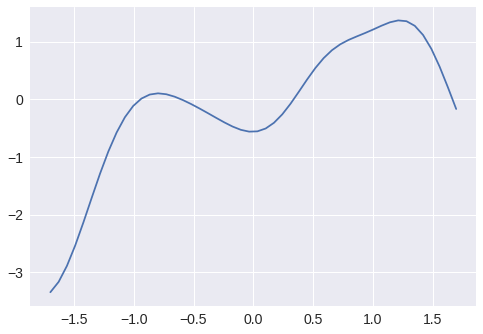

In [94]:
T1 = test_accuracy(x, y, Xnew)


In [54]:
u, s, vh = np.linalg.svd(A, full_matrices=True)

In [59]:
u@np.diag(s)@vh

array([[2.23940286e+00, 1.98521597e-01, 2.30066219e-02, ...,
        1.49940210e+00, 1.44225783e+00, 2.55820534e-01],
       [1.98521597e-01, 2.23940286e+00, 2.60952240e-06, ...,
        1.85034673e-02, 1.62129400e-02, 2.31276928e-04],
       [2.30066219e-02, 2.60952240e-06, 2.23940286e+00, ...,
        2.31595775e-01, 2.53248747e-01, 1.43570079e+00],
       ...,
       [1.49940210e+00, 1.85034673e-02, 2.31595775e-01, ...,
        2.23940286e+00, 2.23739285e+00, 1.10666207e+00],
       [1.44225783e+00, 1.62129400e-02, 2.53248747e-01, ...,
        2.23739285e+00, 2.23940286e+00, 1.16272587e+00],
       [2.55820534e-01, 2.31276928e-04, 1.43570079e+00, ...,
        1.10666207e+00, 1.16272587e+00, 2.23940286e+00]])

In [51]:
from sympy import Matrix


A = T1._m.kern.K(T1._x, T1._x)
mat = Matrix(A)
(P, D) = mat.diagonalize(sort = True, reals_only = True)

MatrixError: Could not compute eigenvalues for Matrix([[223940286026103/100000000000000, 49630399301817/250000000000000, 230066218903123/10000000000000000, 79183392120529/50000000000000, 81753421826609/250000000000000, 69692147120669/500000000000000, 550782875906541/1000000000000000, 39151212901747/20000000000000, 221533454692483/100000000000000, 15151053450563/10000000000000, 55978111941451/25000000000000, 336750180563731/1000000000000000, 6811444343099/10000000000000, 414012844600371/50000000000000000, 205329858512791/5000000000000000, 412416485450527/1000000000000000, 44787962858499/20000000000000, 13199242154421/10000000000000, 298346441820143/1000000000000000, 158428142393637/250000000000000, 115803590135211/2500000000000000, 748414914661661/1000000000000000000, 168795288250403/100000000000000, 76047731629093/250000000000000, 53966174397821/6250000000000000, 275394831632431/50000000000000000, 24572565978047/200000000000000, 259955648273797/5000000000000000, 89573941177791/200000000000000, 827521654249871/100000000000000000, 154323381616181/1000000000000000, 44768369451443/20000000000000, 25215017666489/25000000000000000, 156973063200139/100000000000000, 306161067429137/1000000000000000, 85356652057507/50000000000000, 165346982126577/500000000000000, 56643275764507/2500000000000000, 339954931313101/10000000000000000, 120423915578503/1000000000000000, 81381693647953/200000000000000000, 124665994743101/1000000000000000, 17126140247239/12500000000000, 582011612777079/10000000000000000, 83695583933891/500000000000000, 218388636860751/100000000000000, 385388947769659/100000000000000000, 37485052453873/25000000000000, 72112891701263/50000000000000, 127910266752433/500000000000000], [49630399301817/250000000000000, 223940286026103/100000000000000, 8154757495203/3125000000000000000, 28080653351929/1250000000000000, 386220678784007/1000000000000000000, 690042596357831/10000000000000000000, 477677549661/390625000000000, 277002181200379/5000000000000000, 17761370626409/125000000000000, 940297382358029/1000000000000000, 51377037608441/250000000000000, 21678785226993/10000000000000, 202241421936893/100000000000000000, 14528496518241/12500000000000, 360090868693011/50000000000000000000, 10487391077913/5000000000000, 199420228499351/1000000000000000, 112531201453857/100000000000000, 159134962981473/500000000000000000, 170002223139757/100000000000000000, 188864409811667/100000000000000, 3465128101449/7812500000000, 285863872759521/10000000000000000, 54840658230587/25000000000000, 117900518163989/100000000000000, 50308709201833/50000000000000, 541334934928097/10000000000000000000, 109862418227159/10000000000000000000, 764782501739949/1000000000000000000, 116203754389089/100000000000000, 840979898696407/10000000000000000000, 42364040278999/200000000000000, 253223117625199/500000000000000, 111260632358073/125000000000000, 219217374994397/100000000000000, 11957465362797/400000000000000, 21729280045123/10000000000000, 158738079412991/100000000000000, 515513691576233/100000000000000000000, 21875611134237/10000000000000, 335139656086209/1000000000000000, 6856702998219/3125000000000, 136992042427043/10000000000000000, 49394798903919/25000000000000, 49307562945693/500000000000000000, 158524509078621/500000000000000, 880352745798261/1000000000000000, 185034673379273/10000000000000000, 162129399628587/10000000000000000, 46255385581311/200000000000000000], [230066218903123/10000000000000000, 8154757495203/3125000000000000000, 223940286026103/100000000000000, 100992315267943/500000000000000, 127099997243399/100000000000000, 178993747395353/100000000000000, 224749613473763/250000000000000, 483080598755151/5000000000000000, 7102025210859/200000000000000, 53632487254663/50000000000000000, 27414920501977/1250000000000000, 956974631527177/100000000000000000000, 72811171287/97656250000, 340198580781887/100000000000000000000000, 109797737246871/50000000000000, 6481811500167/400000000000000000, 114320616218129/5000000000000000, 603962612932699/1000000000000000000, 133367181146311/100000000000000, 199372876732277/250000000000000, 26026185789069/250000000000000000000, 84927050107199/2000000000000000000000000, 84370441501243/500000000000000, 147916876737121/20000000000000000000, 368480970352089/100000000000000000000000, 15754205669641/10000000000000000000000, 92595527074009/50000000000000, 215172246050637/100000000000000, 52433790819101/50000000000000, 339804369168201/100000000000000000000000, 173679202275367/100000000000000, 105114431674509/5000000000000000, 718660510734999/10000000000000000000000000, 62909326132821/50000000000000000, 751693397749443/100000000000000000000, 162996627335171/1000000000000000, 456842310105019/50000000000000000000, 241953144931689/10000000000000000000000, 55500124519777/25000000000000, 411157154729741/500000000000000000000, 146854597740149/10000000000000000000000000, 889090602284151/1000000000000000000000, 70651587189227/250000000000000, 16825895694381/100000000000000000000, 169242712303467/100000000000000, 22778291372153/2000000000000000, 810739414425267/1000000000000000000000000, 7237367962771/31250000000000, 126624373531831/500000000000000, 143570078870761/100000000000000], [79183392120529/50000000000000, 28080653351929/1250000000000000, 100992315267943/500000000000000, 223940286026103/100000000000000, 118373727899073/100000000000000, 700954841754839/1000000000000000, 31408233888263/20000000000000, 213184683365233/100000000000000, 4426470055783/2500000000000, 513327681862583/1000000000000000, 31256446647089/20000000000000, 471096716609427/10000000000000000, 173995410194637/100000000000000, 90289384260761/250000000000000000, 305762867444379/1000000000000000, 157683537707539/2500000000000000, 6323843814699/4000000000000, 198301218081001/500000000000000, 112233342823141/100000000000000, 84105580711317/50000000000000, 322444778708361/100000000000000000, 1183433952293/62500000000000000, 55803949584657/25000000000000, 50958951055779/1250000000000000, 190282731044307/500000000000000000, 217456396774569/1000000000000000000, 322854333290189/500000000000000, 180379877063907/500000000000000, 17628091807931/12500000000000, 360883033651817/1000000000000000000, 748415499248207/1000000000000000, 77218756066469/50000000000000, 54335827884949/2000000000000000000, 550308164191997/1000000000000000, 25713616013213/625000000000000, 222917501059371/100000000000000, 11476412513629/250000000000000, 25704565652621/20000000000000000, 133711849061839/500000000000000, 56901964695631/5000000000000000, 181801204896033/20000000000000000000, 119229678648769/10000000000000000, 44226397350059/20000000000000, 5427488436851/1250000000000000, 98526038128877/125000000000000, 16020181012019/12500000000000, 139823452493967/1000000000000000000, 223492379949777/100000000000000, 111346893609987/50000000000000, 6403184437283/6250000000000], [81753421826609/250000000000000, 386220678784007/1000000000000000000, 127099997243399/100000000000000, 118373727899073/100000000000000, 223940286026103/100000000000000, 207137068958899/100000000000000, 214921680195457/100000000000000, 79070488760563/100000000000000, 431630942656217/1000000000000000, 390647388119709/10000000000000000, 158507091065667/500000000000000, 6749627694453/6250000000000000, 41028197286257/20000000000000, 170369844109381/100000000000000000000, 76931941547477/50000000000000, 163171291309859/100000000000000000, 65139795783291/200000000000000, 128227175171127/5000000000000000, 111850573726927/50000000000000, 208917161239139/100000000000000, 286780406646871/10000000000000000000, 106670514627477/2500000000000000000000, 21547603538011/20000000000000, 220423369394097/250000000000000000, 18208618828699/10000000000000000000, 89614254090723/100000000000000000000, 101283280914763/50000000000000, 6599366699229/4000000000000, 1725168867837/781250000000, 85102690401063/50000000000000000000, 105267682780681/50000000000000, 77099654935701/250000000000000, 133304414814859/2000000000000000000000, 438643554178937/10000000000000000, 27907826982973/31250000000000000, 13220686031447/12500000000000, 104134539488809/100000000000000000, 865922995754927/100000000000000000000, 36247629376021/25000000000000, 153234314752703/1000000000000000000, 173015893890337/10000000000000000000000, 163164591012781/1000000000000000000, 27971390265957/20000000000000, 424220808512487/10000000000000000000, 213037740784809/100000000000000, 321067486751/1562500000000, 513799381440377/1000000000000000000000, 126887210232383/100000000000000, 132631191280611/100000000000000, 22229591841613/10000000000000], [69692147120669/500000000000000, 690042596357831/10000000000000000000, 178993747395353/100000000000000, 700954841754839/1000000000000000, 207137068958899/100000000000000, 223940286026103/100000000000000, 177510266354519/100000000000000, 413647749349309/1000000000000000, 12185886162271/62500000000000, 117435669949513/10000000000000000, 13428325373777/100000000000000, 53343982154077/250000000000000000, 160822513053403/100000000000000, 48408654761237/250000000000000000000, 50097289073021/25000000000000, 168161049182601/500000000000000000, 138711423145903/1000000000000000, 182063734967613/25000000000000000, 8429136004109/4000000000000, 166791967841757/100000000000000, 40688149502127/10000000000000000000, 14980503401169/4000000000000000000000, 309004496924519/500000000000000, 85347336556653/500000000000000000, 25997344405153/125000000000000000000, 242872596433951/2500000000000000000000, 27953331920377/12500000000000, 207804191201811/100000000000000, 95589393348267/50000000000000, 96716898498699/500000000000000000000, 223727455660493/100000000000000, 64959668100299/500000000000000, 602683954604447/100000000000000000000000, 134017908145831/10000000000000000, 173114315968127/1000000000000000000, 603067553075773/1000000000000000, 51248961948999/250000000000000000, 22296988601483/20000000000000000000, 193823153083071/100000000000000, 125672754691391/5000000000000000000, 143153482538033/100000000000000000000000, 67289055295817/2500000000000000000, 881799323698713/1000000000000000, 621991572030549/100000000000000000000, 1116210934179/500000000000, 200414708140801/2500000000000000, 66888134712701/1250000000000000000000, 385191672657227/500000000000000, 818849233195619/1000000000000000, 215716007738509/100000000000000], [550782875906541/1000000000000000, 477677549661/390625000000000, 224749613473763/250000000000000, 31408233888263/20000000000000, 214921680195457/100000000000000, 177510266354519/100000000000000, 223940286026103/100000000000000, 114773657853543/100000000000000, 696981139041267/1000000000000000, 847768925984397/10000000000000000, 21454415921989/40000000000000, 39730240653971/12500000000000000, 44399328311483/20000000000000, 374554705295869/50000000000000000000, 57592990543227/50000000000000, 465717207174451/100000000000000000, 548891478307389/1000000000000000, 58004801022793/1000000000000000, 211865358176369/100000000000000, 223114740486463/100000000000000, 21468534768883/200000000000000000, 226323253218391/1000000000000000000000, 36567205929057/25000000000000, 263359388562843/100000000000000000, 797751277713191/100000000000000000000, 407786255536357/100000000000000000000, 170978200756673/100000000000000, 126546463427353/100000000000000, 111176844331093/50000000000000, 748425313638661/100000000000000000000, 45673149732503/25000000000000, 523865149718437/1000000000000000, 172995610068679/500000000000000000000, 940798337920099/10000000000000000, 133252245805569/50000000000000000, 36054296883497/25000000000000, 6146025139239/2000000000000000, 173897744726619/5000000000000000000, 53253551970869/50000000000000, 258116912141107/500000000000000000, 191583732911701/2000000000000000000000, 109485857749503/200000000000000000, 177279841513949/100000000000000, 77521580954311/500000000000000000, 18675070035639/10000000000000, 369056178824093/1000000000000000, 120354458556539/50000000000000000000, 20663617132283/12500000000000, 170705313228063/100000000000000, 206044647605433/100000000000000], [39151212901747/20000000000000, 277002181200379/5000000000000000, 483080598755151/5000000000000000, 213184683365233/100000000000000, 79070488760563/100000000000000, 413647749349309/1000000000000000, 114773657853543/100000000000000, 223940286026103/100000000000000, 52248883440741/25000000000000, 167467398227893/200000000000000, 24267182239721/12500000000000, 107252488812101/1000000000000000, 132543471883297/100000000000000, 5103042763941/4000000000000000, 77814245414139/500000000000000, 138852592455731/1000000000000000, 97773679937471/50000000000000, 135377151328313/200000000000000, 738893983589339/1000000000000000, 126297421654331/100000000000000, 238751691231571/25000000000000000, 821275200545493/10000000000000000000, 10896530879661/5000000000000, 188652565066097/2000000000000000, 66951859622789/50000000000000000, 199385010261989/250000000000000000, 93692135098619/250000000000000, 188565070007469/1000000000000000, 124103780733031/125000000000000, 63743190065367/50000000000000000, 55967451858313/125000000000000, 96341763000917/50000000000000, 115086156335761/1000000000000000000, 886180704884183/1000000000000000, 475482780818663/5000000000000000, 27334802313623/12500000000000, 52408384609537/500000000000000, 205593624709111/50000000000000000, 133322997488821/1000000000000000, 187734867209/6250000000000, 413203787086197/10000000000000000000, 313281789992559/10000000000000000, 5006885205927/2500000000000, 31321382858313/2500000000000000, 19072570427999/40000000000000, 169957500540641/100000000000000, 33088360592881/62500000000000000, 104287921200377/50000000000000, 25635680026053/12500000000000, 82345876951151/125000000000000], [221533454692483/100000000000000, 17761370626409/125000000000000, 7102025210859/200000000000000, 4426470055783/2500000000000, 431630942656217/1000000000000000, 12185886162271/62500000000000, 696981139041267/1000000000000000, 52248883440741/25000000000000, 223940286026103/100000000000000, 26323342651311/20000000000000, 110496521587981/50000000000000, 62556720512889/250000000000000, 845375655639983/1000000000000000, 62602591232209/12500000000000000, 615663251459413/10000000000000000, 19457101174167/62500000000000, 44293230287683/20000000000000, 28063908411519/25000000000000, 1982388811387/5000000000000, 197963788245601/250000000000000, 3042808224337/100000000000000, 411157972113351/1000000000000000000, 186497908614429/100000000000000, 224326637023167/1000000000000000, 26160797613167/5000000000000000, 163664041569413/50000000000000000, 86603201486543/500000000000000, 769810592000903/10000000000000000, 115354817834703/200000000000000, 250251241927703/50000000000000000, 107245929073723/500000000000000, 1722444167901/781250000000, 560262929604833/1000000000000000000, 34296689170409/25000000000000, 225886874336557/1000000000000000, 94098316434807/50000000000000, 122695488718433/500000000000000, 143549154100057/10000000000000000, 514634665642877/10000000000000000, 83493590422033/1000000000000000, 8747366468593/40000000000000000, 173234861716973/2000000000000000, 156799954383779/100000000000000, 77404663971769/2000000000000000, 231446513503047/1000000000000000, 209040997007973/100000000000000, 225639124034011/100000000000000000, 42301094794753/25000000000000, 16377290683601/10000000000000, 343742610176637/1000000000000000], [15151053450563/10000000000000, 940297382358029/1000000000000000, 53632487254663/50000000000000000, 513327681862583/1000000000000000, 390647388119709/10000000000000000, 117435669949513/10000000000000000, 847768925984397/10000000000000000, 167467398227893/200000000000000, 26323342651311/20000000000000, 223940286026103/100000000000000, 4800566827401/3125000000000, 127334439070599/100000000000000, 29455613276113/250000000000000, 107941498015633/1000000000000000, 5701951484491/2500000000000000, 35465649327373/25000000000000, 151785374331129/100000000000000, 221622786361071/100000000000000, 85532840746269/2500000000000000, 10524098174079/100000000000000, 367560266137741/1000000000000000, 173969080230657/10000000000000000, 73435740105379/125000000000000, 120386281276101/100000000000000, 55659643124203/500000000000000, 15962736260741/200000000000000, 987827328527951/100000000000000000, 31120106318033/10000000000000000, 620393781850369/10000000000000000, 13486642918807/125000000000000, 67566243446219/5000000000000000, 7773317269447/5000000000000, 219354922917809/10000000000000000, 223751972028677/100000000000000, 3775629287989/3125000000000, 18818384101251/31250000000000, 63038371999167/50000000000000, 8937662764547/40000000000000, 22262692404489/12500000000000000, 345328645221301/500000000000000, 53975482679277/5000000000000000, 176491734035727/250000000000000, 96477923404123/250000000000000, 429072330662311/1000000000000000, 75618195224749/5000000000000000, 45030169391157/25000000000000, 305450238338123/5000000000000000, 57446686440591/125000000000000, 106451070759949/250000000000000, 17156316236941/625000000000000], [55978111941451/25000000000000, 51377037608441/250000000000000, 27414920501977/1250000000000000, 31256446647089/20000000000000, 158507091065667/500000000000000, 13428325373777/100000000000000, 21454415921989/40000000000000, 24267182239721/12500000000000, 110496521587981/50000000000000, 4800566827401/3125000000000, 223940286026103/100000000000000, 173601822688257/500000000000000, 664690850085129/1000000000000000, 872786473524333/100000000000000000, 98175205089213/2500000000000000, 424501497131139/1000000000000000, 223919223208271/100000000000000, 1341332452921/1000000000000, 289012790020633/1000000000000000, 308977714950837/500000000000000, 241974995880621/5000000000000000, 99631609796631/125000000000000000, 33357010404603/20000000000000, 78472186748859/250000000000000, 909954985980569/100000000000000000, 116332095172379/20000000000000000, 7391728188983/62500000000000, 24891946941391/500000000000000, 217661362860157/500000000000000, 872257694209309/100000000000000000, 14877788441677/100000000000000, 223918698401313/100000000000000, 107287330400647/100000000000000000, 159053746238831/100000000000000, 31590559007933/100000000000000, 21090075739477/12500000000000, 13640377525821/40000000000000, 237635239425743/10000000000000000, 40593714494137/1250000000000000, 125088156487673/1000000000000000, 21718774039847/50000000000000000, 129465218226349/1000000000000000, 134867419618449/100000000000000, 30363390188759/500000000000000, 161466228182159/1000000000000000, 219134359090301/100000000000000, 50955179996777/12500000000000000, 147819008870921/100000000000000, 35522610683959/25000000000000, 61880919571299/250000000000000], [336750180563731/1000000000000000, 21678785226993/10000000000000, 956974631527177/100000000000000000000, 471096716609427/10000000000000000, 6749627694453/6250000000000000, 53343982154077/250000000000000000, 39730240653971/12500000000000000, 107252488812101/1000000000000000, 62556720512889/250000000000000, 127334439070599/100000000000000, 173601822688257/500000000000000, 223940286026103/100000000000000, 508271271652957/100000000000000000, 168078430797757/200000000000000, 251117522474957/10000000000000000000, 222660307299479/100000000000000, 338097653958309/1000000000000000, 146890102660961/100000000000000, 450241070855583/500000000000000000, 432295452216717/100000000000000000, 157566346459043/100000000000000, 271457182114399/1000000000000000, 587305317903863/10000000000000000, 11182143827031/5000000000000, 213803653464613/250000000000000, 352834612372177/500000000000000, 42416425852213/250000000000000000, 374898381529889/10000000000000000000, 204913190462987/100000000000000000, 210044524312561/250000000000000, 1004591865049/3906250000000000, 178301949660363/500000000000000, 157981317401513/500000000000000, 121801075760839/100000000000000, 111839496050741/50000000000000, 611792361470553/10000000000000000, 447861200957/200000000000, 971791030811/781250000000, 182802963754999/10000000000000000000, 50101777162443/25000000000000, 39489659657537/200000000000000, 100873574274851/50000000000000, 18696833101013/625000000000000, 168369281525573/100000000000000, 373575895713/1250000000000000, 10159258841627/20000000000000, 3008289305823/5000000000000, 394337611372097/10000000000000000, 349274031906829/10000000000000000, 667008137120261/1000000000000000000], [6811444343099/10000000000000, 202241421936893/100000000000000000, 72811171287/97656250000, 173995410194637/100000000000000, 41028197286257/20000000000000, 160822513053403/100000000000000, 44399328311483/20000000000000, 132543471883297/100000000000000, 845375655639983/1000000000000000, 29455613276113/250000000000000, 664690850085129/1000000000000000, 508271271652957/100000000000000000, 223940286026103/100000000000000, 36029236401207/2500000000000000000, 980595625542859/1000000000000000, 367144301698023/50000000000000000, 33949468369271/50000000000000, 410824019755731/5000000000000000, 50248299853397/25000000000000, 55925627719169/25000000000000, 95875822544717/500000000000000000, 23734909142099/50000000000000000000, 8189595382163/5000000000000, 106005783143751/25000000000000000, 38305222557221/2500000000000000000, 398506409950697/50000000000000000000, 153825430727313/100000000000000, 108942240097407/100000000000000, 54245077404381/25000000000000, 8999299690369/625000000000000000, 10404590912959/6250000000000, 650397335445057/1000000000000000, 718516185142733/1000000000000000000000, 130045382735309/1000000000000000, 53612970437271/12500000000000000, 161818499888571/100000000000000, 61502400774127/12500000000000000, 160447216075083/2500000000000000000, 112354822591031/125000000000000, 109815335795711/125000000000000000, 204922989581777/1000000000000000000000, 464922994362623/500000000000000000, 48085425221339/25000000000000, 136967459527639/500000000000000000, 170968862263739/100000000000000, 235055383583453/500000000000000, 476811971995489/100000000000000000000, 11351988841979/6250000000000, 5828576668759/3125000000000, 2419254405111/1250000000000], [414012844600371/50000000000000000, 14528496518241/12500000000000, 340198580781887/100000000000000000000000, 90289384260761/250000000000000000, 170369844109381/100000000000000000000, 48408654761237/250000000000000000000, 374554705295869/50000000000000000000, 5103042763941/4000000000000000, 62602591232209/12500000000000000, 107941498015633/1000000000000000, 872786473524333/100000000000000000, 168078430797757/200000000000000, 36029236401207/2500000000000000000, 223940286026103/100000000000000, 117780047549167/10000000000000000000000, 4495405222813/6250000000000, 833731438562983/100000000000000000, 152384002653493/1000000000000000, 26631182830027/20000000000000000000, 57456990034239/5000000000000000000, 47817894175167/25000000000000, 180791179208461/100000000000000, 100792959668493/200000000000000000, 902095300352131/1000000000000000, 223922667936269/100000000000000, 222342229894931/100000000000000, 35742090817333/250000000000000000000, 197969422417437/10000000000000000000000, 40869163287333/10000000000000000000, 223940282319707/100000000000000, 248074924153789/1000000000000000000000, 36560555197051/4000000000000000, 189381493987847/100000000000000, 121860407680591/1250000000000000, 7185325371523/8000000000000, 268126882811637/500000000000000000, 851370155571453/1000000000000000, 53264088980433/25000000000000, 78166503034927/10000000000000000000000, 72737805142419/50000000000000, 162121054853661/100000000000000, 17941643578967/12500000000000, 183601227368217/1000000000000000000, 181907764503193/100000000000000, 302938818410063/1000000000000000000000, 42731756021359/2500000000000000, 218527532299509/100000000000000, 27668047162229/100000000000000000, 230945055205121/1000000000000000000, 221943676754751/250000000000000000000], [205329858512791/5000000000000000, 360090868693011/50000000000000000000, 109797737246871/50000000000000, 305762867444379/1000000000000000, 76931941547477/50000000000000, 50097289073021/25000000000000, 57592990543227/50000000000000, 77814245414139/500000000000000, 615663251459413/10000000000000000, 5701951484491/2500000000000000, 98175205089213/2500000000000000, 251117522474957/10000000000000000000, 980595625542859/1000000000000000, 117780047549167/10000000000000000000000, 223940286026103/100000000000000, 416301706074119/10000000000000000000, 408282023376463/10000000000000000, 33035118216653/25000000000000000, 159980143033969/100000000000000, 51966726518691/50000000000000, 322501213004047/1000000000000000000000, 167341077664697/1000000000000000000000000, 259541954678137/1000000000000000, 49015842155657/2500000000000000000, 12725530426151/1000000000000000000000, 558501740752929/100000000000000000000000, 10258287909537/5000000000000, 13946174551959/6250000000000, 8201820200433/6250000000000, 117647804669429/10000000000000000000000, 196125081159687/100000000000000, 943649917473/25000000000000, 1743887503763/6250000000000000000000, 265365381650249/100000000000000000, 99572976102621/5000000000000000000, 62865284546813/250000000000000, 60049927716199/2500000000000000000, 786924230782753/10000000000000000000000, 111726216145883/50000000000000, 47375696693109/20000000000000000000, 119222315257771/2000000000000000000000000, 255387219668851/100000000000000000000, 82912593090697/200000000000000, 512725662969329/1000000000000000000000, 192459679211189/100000000000000, 212511931092299/10000000000000000, 36656242453047/12500000000000000000000, 173111936423601/500000000000000, 187715633049017/500000000000000, 169674950775577/100000000000000], [412416485450527/1000000000000000, 10487391077913/5000000000000, 6481811500167/400000000000000000, 157683537707539/2500000000000000, 163171291309859/100000000000000000, 168161049182601/500000000000000000, 465717207174451/100000000000000000, 138852592455731/1000000000000000, 19457101174167/62500000000000, 35465649327373/25000000000000, 424501497131139/1000000000000000, 222660307299479/100000000000000, 367144301698023/50000000000000000, 4495405222813/6250000000000, 416301706074119/10000000000000000000, 223940286026103/100000000000000, 82795148105141/200000000000000, 32228294067901/20000000000000, 34182876559973/25000000000000000, 313808931172247/50000000000000000, 143213487625631/100000000000000, 27076605834333/125000000000000, 779572922674683/10000000000000000, 221140515989747/100000000000000, 45808415736247/62500000000000, 119253968458181/200000000000000, 6723662888993/25000000000000000, 615895484941943/10000000000000000000, 38013349875369/12500000000000000, 359533811740613/500000000000000, 20173525635451/50000000000000000, 108836699879181/250000000000000, 63541755736403/250000000000000, 136295191922129/100000000000000, 221252814798439/100000000000000, 101344691127611/1250000000000000, 111214531915561/50000000000000, 110120536825197/100000000000000, 305200651705689/10000000000000000000, 94728649865859/50000000000000, 155054316083011/1000000000000000, 191017620590623/100000000000000, 407391324469189/10000000000000000, 154401983059387/100000000000000, 467093983378463/1000000000000000000, 607352693474921/1000000000000000, 502886502682041/1000000000000000, 53155348453349/1000000000000000, 236475247615763/5000000000000000, 20419758750059/20000000000000000], [44787962858499/20000000000000, 199420228499351/1000000000000000, 114320616218129/5000000000000000, 6323843814699/4000000000000, 65139795783291/200000000000000, 138711423145903/1000000000000000, 548891478307389/1000000000000000, 97773679937471/50000000000000, 44293230287683/20000000000000, 151785374331129/100000000000000, 223919223208271/100000000000000, 338097653958309/1000000000000000, 33949468369271/50000000000000, 833731438562983/100000000000000000, 408282023376463/10000000000000000, 82795148105141/200000000000000, 223940286026103/100000000000000, 33067752589449/25000000000000, 297118792912739/1000000000000000, 631647807795591/1000000000000000, 465868966019021/10000000000000000, 47161547828119/62500000000000000, 168534620687659/100000000000000, 61088087443023/200000000000000, 3477545267739/400000000000000, 554721289400039/100000000000000000, 122256429112187/1000000000000000, 32311930987489/625000000000000, 111555620081811/250000000000000, 833224241574411/100000000000000000, 76796070018527/500000000000000, 223855000552113/100000000000000, 20335167583213/20000000000000000, 78622286249863/50000000000000, 30741663046677/100000000000000, 85227492760193/50000000000000, 166011771328363/500000000000000, 227986603643803/10000000000000000, 33794079989671/1000000000000000, 121022780592461/1000000000000000, 102597225027891/250000000000000000, 31320565611413/250000000000000, 136730345147857/100000000000000, 585247053735427/10000000000000000, 1301641534753/7812500000000, 54622159961819/25000000000000, 388220814099119/100000000000000000, 1197315869869/800000000000, 143948043777013/100000000000000, 63682140092417/250000000000000], [13199242154421/10000000000000, 112531201453857/100000000000000, 603962612932699/1000000000000000000, 198301218081001/500000000000000, 128227175171127/5000000000000000, 182063734967613/25000000000000000, 58004801022793/1000000000000000, 135377151328313/200000000000000, 28063908411519/25000000000000, 221622786361071/100000000000000, 1341332452921/1000000000000, 146890102660961/100000000000000, 410824019755731/5000000000000000, 152384002653493/1000000000000000, 33035118216653/25000000000000000, 32228294067901/20000000000000, 33067752589449/25000000000000, 223940286026103/100000000000000, 111555833796117/5000000000000000, 182261601611247/2500000000000000, 95704116256033/200000000000000, 269903519614229/10000000000000000, 459199218609413/1000000000000000, 5596457318883/4000000000000, 980427700553/6250000000000, 22927430088203/200000000000000, 303961050643137/50000000000000000, 182514806840387/100000000000000000, 417237950371431/10000000000000000, 7615986814669/50000000000000, 843286068165913/100000000000000000, 136019179747901/100000000000000, 168320900544819/5000000000000000, 110065074553603/50000000000000, 35087545093749/25000000000000, 47172283322349/100000000000000, 14563449750141/10000000000000, 301398196000119/1000000000000000, 102207523129717/100000000000000000, 170552624429829/200000000000000, 42782773334773/2500000000000000, 434931181876061/500000000000000, 1457023731187/5000000000000, 551937255758867/1000000000000000, 948614715412681/100000000000000000, 162071254258899/100000000000000, 890386904915433/10000000000000000, 351845244370449/1000000000000000, 324005235419081/1000000000000000, 177077676662241/10000000000000000], [298346441820143/1000000000000000, 159134962981473/500000000000000000, 133367181146311/100000000000000, 112233342823141/100000000000000, 111850573726927/50000000000000, 8429136004109/4000000000000, 211865358176369/100000000000000, 738893983589339/1000000000000000, 1982388811387/5000000000000, 85532840746269/2500000000000000, 289012790020633/1000000000000000, 450241070855583/500000000000000000, 50248299853397/25000000000000, 26631182830027/20000000000000000000, 159980143033969/100000000000000, 34182876559973/25000000000000000, 297118792912739/1000000000000000, 111555833796117/5000000000000000, 223940286026103/100000000000000, 102564821153047/50000000000000, 115016826465471/5000000000000000000, 80886683745287/2500000000000000000000, 20353981161901/20000000000000, 45839295985987/62500000000000000, 142395600400483/100000000000000000000, 34826686189837/50000000000000000000, 206583618554357/100000000000000, 3417445570513/2000000000000, 43776932028147/20000000000000, 2660525116069/2000000000000000000, 213754284621969/100000000000000, 140488908258489/500000000000000, 507175784734797/10000000000000000000000, 384895823939809/10000000000000000, 371493494667319/500000000000000000, 249591406989127/250000000000000, 867927371837837/1000000000000000000, 137345451339357/20000000000000000000, 151214999644157/100000000000000, 7813597189747/62500000000000000, 130291787364571/10000000000000000000000, 133207660869721/1000000000000000000, 66789788248369/50000000000000, 341589483612913/10000000000000000000, 215941126797821/100000000000000, 185538003643199/1000000000000000, 198742291015639/500000000000000000000, 60328816689923/50000000000000, 126366922662407/100000000000000, 55827072395379/25000000000000], [158428142393637/250000000000000, 170002223139757/100000000000000000, 199372876732277/250000000000000, 84105580711317/50000000000000, 208917161239139/100000000000000, 166791967841757/100000000000000, 223114740486463/100000000000000, 126297421654331/100000000000000, 197963788245601/250000000000000, 10524098174079/100000000000000, 308977714950837/500000000000000, 432295452216717/100000000000000000, 55925627719169/25000000000000, 57456990034239/5000000000000000000, 51966726518691/50000000000000, 313808931172247/50000000000000000, 631647807795591/1000000000000000, 182261601611247/2500000000000000, 102564821153047/50000000000000, 223940286026103/100000000000000, 78452878639143/500000000000000000, 9181588371413/25000000000000000000, 157760361616179/100000000000000, 71956924915883/20000000000000000, 61121909838297/5000000000000000000, 632014885368287/100000000000000000000, 15992496798489/10000000000000, 115018185141739/100000000000000, 219275124304629/100000000000000, 57405417149631/5000000000000000000, 43076490777901/25000000000000, 604280024852617/1000000000000000, 557832498657547/1000000000000000000000, 29094634683603/250000000000000, 181990048449949/50000000000000000, 155750605328029/100000000000000, 418293362480707/100000000000000000, 259620615900229/5000000000000000000, 477792367747931/500000000000000, 146229423692429/200000000000000000, 157455522807783/1000000000000000000000, 193593295919593/250000000000000000, 187314238542127/100000000000000, 112507904023059/500000000000000000, 7066809832957/4000000000000, 6763754356537/15625000000000, 188168374865591/50000000000000000000, 176106630241971/100000000000000, 45298583806443/25000000000000, 99104555900531/50000000000000], [115803590135211/2500000000000000, 188864409811667/100000000000000, 26026185789069/250000000000000000000, 322444778708361/100000000000000000, 286780406646871/10000000000000000000, 40688149502127/10000000000000000000, 21468534768883/200000000000000000, 238751691231571/25000000000000000, 3042808224337/100000000000000, 367560266137741/1000000000000000, 241974995880621/5000000000000000, 157566346459043/100000000000000, 95875822544717/500000000000000000, 47817894175167/25000000000000, 322501213004047/1000000000000000000000, 143213487625631/100000000000000, 465868966019021/10000000000000000, 95704116256033/200000000000000, 115016826465471/5000000000000000000, 78452878639143/500000000000000000, 223940286026103/100000000000000, 21387226289413/20000000000000, 430055767460019/100000000000000000, 164308538657127/100000000000000, 192608582901791/100000000000000, 88781267103029/50000000000000, 61896660097747/20000000000000000000, 516897896946463/1000000000000000000000, 313095285127381/5000000000000000000, 191252031788681/100000000000000, 254332678514099/50000000000000000000, 251436737498407/5000000000000000, 14606801493249/12500000000000, 6794019426071/20000000000000, 163890123003141/100000000000000, 453724979422999/100000000000000000, 19849133804867/12500000000000, 217270505538327/100000000000000, 55530004431027/250000000000000000000, 104667856336947/50000000000000, 110212766679903/125000000000000, 41642608141377/20000000000000, 44804423292199/25000000000000000, 223166251528101/100000000000000, 304464899088277/50000000000000000000, 210785592360967/2500000000000000, 82421941001421/50000000000000, 255958948596691/100000000000000000, 54698599511253/25000000000000000, 39995379505689/2500000000000000000], [748414914661661/1000000000000000000, 3465128101449/7812500000000, 84927050107199/2000000000000000000000000, 1183433952293/62500000000000000, 106670514627477/2500000000000000000000, 14980503401169/4000000000000000000000, 226323253218391/1000000000000000000000, 821275200545493/10000000000000000000, 411157972113351/1000000000000000000, 173969080230657/10000000000000000, 99631609796631/125000000000000000, 271457182114399/1000000000000000, 23734909142099/50000000000000000000, 180791179208461/100000000000000, 167341077664697/1000000000000000000000000, 27076605834333/125000000000000, 47161547828119/62500000000000000, 269903519614229/10000000000000000, 80886683745287/2500000000000000000000, 9181588371413/25000000000000000000, 21387226289413/20000000000000, 223940286026103/100000000000000, 17406941382897/625000000000000000, 75346135454913/250000000000000, 179299351491329/100000000000000, 194121547993137/100000000000000, 267103565928717/100000000000000000000000, 297297282176747/1000000000000000000000000, 114207721676589/1000000000000000000000, 180812698433333/100000000000000, 493693547321763/100000000000000000000000, 842320650096427/1000000000000000000, 44661324327219/20000000000000, 152961064730403/10000000000000000, 59887504187301/200000000000000, 74828311720651/2500000000000000000, 276681765585727/1000000000000000, 139908363308447/100000000000000, 53180868660327/500000000000000000000000, 159899870242293/250000000000000, 221451229574653/100000000000000, 625157447736447/1000000000000000, 867562348030719/100000000000000000000, 60194913154359/62500000000000, 617009908802953/100000000000000000000000, 89443267761727/50000000000000000, 12743479948527/6250000000000, 69588147702263/5000000000000000000, 28248389539213/2500000000000000000, 205360357577707/10000000000000000000000], [168795288250403/100000000000000, 285863872759521/10000000000000000, 84370441501243/500000000000000, 55803949584657/25000000000000, 21547603538011/20000000000000, 309004496924519/500000000000000, 36567205929057/25000000000000, 10896530879661/5000000000000, 186497908614429/100000000000000, 73435740105379/125000000000000, 33357010404603/20000000000000, 587305317903863/10000000000000000, 8189595382163/5000000000000, 100792959668493/200000000000000000, 259541954678137/1000000000000000, 779572922674683/10000000000000000, 168534620687659/100000000000000, 459199218609413/1000000000000000, 20353981161901/20000000000000, 157760361616179/100000000000000, 430055767460019/100000000000000000, 17406941382897/625000000000000000, 223940286026103/100000000000000, 255174227894509/5000000000000000, 66313864265693/125000000000000000, 76594927984493/250000000000000000, 566878978773597/1000000000000000, 308319909554773/1000000000000000, 1016375891799/781250000000, 251794563979401/500000000000000000, 165543519495663/250000000000000, 3300013970927/2000000000000, 79438809405089/2000000000000000000, 313866258491001/500000000000000, 31427257611/610351562500, 55978621550061/25000000000000, 572723722021327/10000000000000000, 174842637739417/100000000000000000, 22579466788679/100000000000000, 147362301319219/10000000000000000, 135323282417907/10000000000000000000, 77104799416309/5000000000000000, 217615504946583/100000000000000, 287619888269449/50000000000000000, 699372489732503/1000000000000000, 34771832155919/25000000000000, 198617557512909/1000000000000000000, 22163739581649/10000000000000, 220093271885983/100000000000000, 461694753846149/500000000000000], [76047731629093/250000000000000, 54840658230587/25000000000000, 147916876737121/20000000000000000000, 50958951055779/1250000000000000, 220423369394097/250000000000000000, 85347336556653/500000000000000000, 263359388562843/100000000000000000, 188652565066097/2000000000000000, 224326637023167/1000000000000000, 120386281276101/100000000000000, 78472186748859/250000000000000, 11182143827031/5000000000000, 106005783143751/25000000000000000, 902095300352131/1000000000000000, 49015842155657/2500000000000000000, 221140515989747/100000000000000, 61088087443023/200000000000000, 5596457318883/4000000000000, 45839295985987/62500000000000000, 71956924915883/20000000000000000, 164308538657127/100000000000000, 75346135454913/250000000000000, 255174227894509/5000000000000000, 223940286026103/100000000000000, 917412563848587/1000000000000000, 762168948865061/1000000000000000, 27071554907447/200000000000000000, 146993804927877/5000000000000000000, 168747580234903/100000000000000000, 180374797312661/200000000000000, 206196152545557/1000000000000000000, 161308948125219/500000000000000, 349437746560607/1000000000000000, 57455795056093/50000000000000, 223939115332431/100000000000000, 532043082891193/10000000000000000, 44748092220649/20000000000000, 131366762724047/100000000000000, 71120362443229/5000000000000000000, 205062765342171/100000000000000, 220912673592741/1000000000000000, 8251245983453/4000000000000, 256762348274929/10000000000000000, 174822097122243/100000000000000, 120028030732457/500000000000000000, 232090488732169/500000000000000, 653240311495883/1000000000000000, 170067675434457/5000000000000000, 300608329424739/10000000000000000, 541166151557209/1000000000000000000], [53966174397821/6250000000000000, 117900518163989/100000000000000, 368480970352089/100000000000000000000000, 190282731044307/500000000000000000, 18208618828699/10000000000000000000, 25997344405153/125000000000000000000, 797751277713191/100000000000000000000, 66951859622789/50000000000000000, 26160797613167/5000000000000000, 55659643124203/500000000000000, 909954985980569/100000000000000000, 213803653464613/250000000000000, 38305222557221/2500000000000000000, 223922667936269/100000000000000, 12725530426151/1000000000000000000000, 45808415736247/62500000000000, 3477545267739/400000000000000, 980427700553/6250000000000, 142395600400483/100000000000000000000, 61121909838297/5000000000000000000, 192608582901791/100000000000000, 179299351491329/100000000000000, 66313864265693/125000000000000000, 917412563848587/1000000000000000, 223940286026103/100000000000000, 221991218459811/100000000000000, 15366124177973/100000000000000000000, 106834362156001/5000000000000000000000, 87176141129629/20000000000000000000, 22392215318519/10000000000000, 8322068552661/31250000000000000000, 952772135589139/100000000000000000, 187996228236963/100000000000000, 100590750254347/1000000000000000, 182690652194543/200000000000000, 564393207507589/1000000000000000000, 433142583340121/500000000000000, 42776969148209/20000000000000, 845248957158693/100000000000000000000000, 147168935445177/100000000000000, 160482021330617/100000000000000, 36307506062523/25000000000000, 96926774422977/500000000000000000, 183370629931717/100000000000000, 325057657957179/1000000000000000000000, 44435274471579/2500000000000000, 217904838126661/100000000000000, 145890136990813/500000000000000000, 243678357257619/1000000000000000000, 950273140156643/1000000000000000000000], [275394831632431/50000000000000000, 50308709201833/50000000000000, 15754205669641/10000000000000000000000, 217456396774569/1000000000000000000, 89614254090723/100000000000000000000, 242872596433951/2500000000000000000000, 407786255536357/100000000000000000000, 199385010261989/250000000000000000, 163664041569413/50000000000000000, 15962736260741/200000000000000, 116332095172379/20000000000000000, 352834612372177/500000000000000, 398506409950697/50000000000000000000, 222342229894931/100000000000000, 558501740752929/100000000000000000000000, 119253968458181/200000000000000, 554721289400039/100000000000000000, 22927430088203/200000000000000, 34826686189837/50000000000000000000, 632014885368287/100000000000000000000, 88781267103029/50000000000000, 194121547993137/100000000000000, 76594927984493/250000000000000000, 762168948865061/1000000000000000, 221991218459811/100000000000000, 223940286026103/100000000000000, 356380270299343/5000000000000000000000, 189662884989679/20000000000000000000000, 109661696523821/50000000000000000000, 44469413528447/20000000000000, 1954902025489/15625000000000000000, 122029843070519/20000000000000000, 201521414850129/100000000000000, 717314338717097/10000000000000000, 379277624661667/500000000000000, 81650559137423/250000000000000000, 178920884458797/250000000000000, 25461677582211/12500000000000, 3677399238363/1000000000000000000000, 129241560470599/100000000000000, 88608845460967/50000000000000, 12729688300171/10000000000000, 108466004212783/1000000000000000000, 167196385314151/100000000000000, 153432617207833/1000000000000000000000, 58394098026649/5000000000000000, 222788981429583/100000000000000, 6613402988799/40000000000000000, 13730693470719/100000000000000000, 460231958578589/1000000000000000000000], [24572565978047/200000000000000, 541334934928097/10000000000000000000, 92595527074009/50000000000000, 322854333290189/500000000000000, 101283280914763/50000000000000, 27953331920377/12500000000000, 170978200756673/100000000000000, 93692135098619/250000000000000, 86603201486543/500000000000000, 987827328527951/100000000000000000, 7391728188983/62500000000000, 42416425852213/250000000000000000, 153825430727313/100000000000000, 35742090817333/250000000000000000000, 10258287909537/5000000000000, 6723662888993/25000000000000000, 122256429112187/1000000000000000, 303961050643137/50000000000000000, 206583618554357/100000000000000, 15992496798489/10000000000000, 61896660097747/20000000000000000000, 267103565928717/100000000000000000000000, 566878978773597/1000000000000000, 27071554907447/200000000000000000, 15366124177973/100000000000000000000, 356380270299343/5000000000000000000000, 223940286026103/100000000000000, 211805820651403/100000000000000, 92654998170127/50000000000000, 17852339054783/125000000000000000000, 222898907978279/100000000000000, 114340118911309/1000000000000000, 107888173973869/25000000000000000000000, 28244051232317/2500000000000000, 137300009898567/1000000000000000000, 552729302043817/1000000000000000, 40730511160391/250000000000000000, 167402237359429/200000000000000000000, 199138326395561/100000000000000, 38986550524497/2000000000000000000, 20258507258919/20000000000000000000000, 52226187565811/2500000000000000000, 819160880795571/1000000000000000, 118797461908037/25000000000000000000, 110999410095971/50000000000000, 698303588263533/10000000000000000, 15619591905969/400000000000000000000, 356023312068189/500000000000000, 151708493693099/200000000000000, 106158272076061/50000000000000], [259955648273797/5000000000000000, 109862418227159/10000000000000000000, 215172246050637/100000000000000, 180379877063907/500000000000000, 6599366699229/4000000000000, 207804191201811/100000000000000, 126546463427353/100000000000000, 188565070007469/1000000000000000, 769810592000903/10000000000000000, 31120106318033/10000000000000000, 24891946941391/500000000000000, 374898381529889/10000000000000000000, 108942240097407/100000000000000, 197969422417437/10000000000000000000000, 13946174551959/6250000000000, 615895484941943/10000000000000000000, 32311930987489/625000000000000, 182514806840387/100000000000000000, 3417445570513/2000000000000, 115018185141739/100000000000000, 516897896946463/1000000000000000000000, 297297282176747/1000000000000000000000000, 308319909554773/1000000000000000, 146993804927877/5000000000000000000, 106834362156001/5000000000000000000000, 189662884989679/20000000000000000000000, 211805820651403/100000000000000, 223940286026103/100000000000000, 28544670855541/20000000000000, 98875094981623/5000000000000000000000, 25516846546889/12500000000000, 479080632152303/10000000000000000, 123139743901047/250000000000000000000000, 45102780136747/12500000000000000, 298528042976637/10000000000000000000, 299104634933599/1000000000000000, 89720376060421/2500000000000000000, 128780510710037/1000000000000000000000, 221410939950657/100000000000000, 92009445909481/25000000000000000000, 5362712598671/50000000000000000000000, 39631252056323/10000000000000000000, 241296583726221/500000000000000, 816014874847543/1000000000000000000000, 50230327088319/25000000000000, 54840440480733/2000000000000000, 62778333345951/12500000000000000000000, 406315283916631/1000000000000000, 109753418052013/250000000000000, 180077032233181/100000000000000], [89573941177791/200000000000000, 764782501739949/1000000000000000000, 52433790819101/50000000000000, 17628091807931/12500000000000, 1725168867837/781250000000, 95589393348267/50000000000000, 111176844331093/50000000000000, 124103780733031/125000000000000, 115354817834703/200000000000000, 620393781850369/10000000000000000, 217661362860157/500000000000000, 204913190462987/100000000000000000, 54245077404381/25000000000000, 40869163287333/10000000000000000000, 8201820200433/6250000000000, 38013349875369/12500000000000000, 111555620081811/250000000000000, 417237950371431/10000000000000000, 43776932028147/20000000000000, 219275124304629/100000000000000, 313095285127381/5000000000000000000, 114207721676589/1000000000000000000000, 1016375891799/781250000000, 168747580234903/100000000000000000, 87176141129629/20000000000000000000, 109661696523821/50000000000000000000, 92654998170127/50000000000000, 28544670855541/20000000000000, 223940286026103/100000000000000, 204154775665927/50000000000000000000, 48934905756439/25000000000000, 424477842969407/1000000000000000, 176169251175309/1000000000000000000000, 172962044721063/2500000000000000, 85414331311061/50000000000000000, 20006146717/15625000000, 197897995220933/100000000000000000, 197025537457883/10000000000000000000, 30575215023239/25000000000000, 78657595333903/250000000000000000, 474844916361329/10000000000000000000000, 334215037544597/1000000000000000000, 40561014896113/25000000000000, 91347441967979/1000000000000000000, 199244345345593/100000000000000, 36523255579323/125000000000000, 127904639655353/100000000000000000000, 74786854722029/50000000000000, 155238956557739/100000000000000, 107394073096439/50000000000000], [827521654249871/100000000000000000, 116203754389089/100000000000000, 339804369168201/100000000000000000000000, 360883033651817/1000000000000000000, 85102690401063/50000000000000000000, 96716898498699/500000000000000000000, 748425313638661/100000000000000000000, 63743190065367/50000000000000000, 250251241927703/50000000000000000, 13486642918807/125000000000000, 872257694209309/100000000000000000, 210044524312561/250000000000000, 8999299690369/625000000000000000, 223940282319707/100000000000000, 117647804669429/10000000000000000000000, 359533811740613/500000000000000, 833224241574411/100000000000000000, 7615986814669/50000000000000, 2660525116069/2000000000000000000, 57405417149631/5000000000000000000, 191252031788681/100000000000000, 180812698433333/100000000000000, 251794563979401/500000000000000000, 180374797312661/200000000000000, 22392215318519/10000000000000, 44469413528447/20000000000000, 17852339054783/125000000000000000000, 98875094981623/5000000000000000000000, 204154775665927/50000000000000000000, 223940286026103/100000000000000, 12390980362881/50000000000000000000, 913462430595749/100000000000000000, 4735036038481/2500000000000, 974439269828809/10000000000000000, 179588958692399/200000000000000, 133963876503089/250000000000000000, 851154742905601/1000000000000000, 213044116507943/100000000000000, 780777998771879/100000000000000000000000, 72725512897051/50000000000000, 162144762437461/100000000000000, 143508517435643/100000000000000, 11466023476991/62500000000000000, 181886422618987/100000000000000, 75657246461989/250000000000000000000, 170829941575639/10000000000000000, 218536323943899/100000000000000, 138233496691381/500000000000000000, 57691271437387/250000000000000000, 55431132483329/62500000000000000000], [154323381616181/1000000000000000, 840979898696407/10000000000000000000, 173679202275367/100000000000000, 748415499248207/1000000000000000, 105267682780681/50000000000000, 223727455660493/100000000000000, 45673149732503/25000000000000, 55967451858313/125000000000000, 107245929073723/500000000000000, 67566243446219/5000000000000000, 14877788441677/100000000000000, 1004591865049/3906250000000000, 10404590912959/6250000000000, 248074924153789/1000000000000000000000, 196125081159687/100000000000000, 20173525635451/50000000000000000, 76796070018527/500000000000000, 843286068165913/100000000000000000, 213754284621969/100000000000000, 43076490777901/25000000000000, 254332678514099/50000000000000000000, 493693547321763/100000000000000000000000, 165543519495663/250000000000000, 206196152545557/1000000000000000000, 8322068552661/31250000000000000000, 1954902025489/15625000000000000000, 222898907978279/100000000000000, 25516846546889/12500000000000, 48934905756439/25000000000000, 12390980362881/50000000000000000000, 223940286026103/100000000000000, 72015054822707/500000000000000, 158374378262899/20000000000000000000000, 153937960663937/10000000000000000, 52272388321709/250000000000000000, 323296376667573/500000000000000, 123587745932593/500000000000000000, 140876229559257/100000000000000000000, 189153240569929/100000000000000, 309228749648653/10000000000000000000, 47485887681287/25000000000000000000000, 13237353353871/400000000000000000, 233751124395883/250000000000000, 387384928156949/50000000000000000000, 111899953557331/50000000000000, 8962951744203/100000000000000, 692194963944119/10000000000000000000000, 102534779224497/125000000000000, 870273278425731/1000000000000000, 218097293721437/100000000000000], [44768369451443/20000000000000, 42364040278999/200000000000000, 105114431674509/5000000000000000, 77218756066469/50000000000000, 77099654935701/250000000000000, 64959668100299/500000000000000, 523865149718437/1000000000000000, 96341763000917/50000000000000, 1722444167901/781250000000, 7773317269447/5000000000000, 223918698401313/100000000000000, 178301949660363/500000000000000, 650397335445057/1000000000000000, 36560555197051/4000000000000000, 943649917473/25000000000000, 108836699879181/250000000000000, 223855000552113/100000000000000, 136019179747901/100000000000000, 140488908258489/500000000000000, 604280024852617/1000000000000000, 251436737498407/5000000000000000, 842320650096427/1000000000000000000, 3300013970927/2000000000000, 161308948125219/500000000000000, 952772135589139/100000000000000000, 122029843070519/20000000000000000, 114340118911309/1000000000000000, 479080632152303/10000000000000000, 424477842969407/1000000000000000, 913462430595749/100000000000000000, 72015054822707/500000000000000, 223940286026103/100000000000000, 4530485746891/4000000000000000, 160875694641077/100000000000000, 324676249279939/1000000000000000, 166950731215851/100000000000000, 175143611958179/500000000000000, 247771888650797/10000000000000000, 311859946409299/10000000000000000, 32329554047233/250000000000000, 229999685882429/500000000000000000, 133816607884933/1000000000000000, 132981795608093/100000000000000, 630284568900949/10000000000000000, 31278085722073/200000000000000, 219747903703573/100000000000000, 428210299637877/100000000000000000, 72972946224687/50000000000000, 28041477587207/20000000000000, 240391077640447/1000000000000000], [25215017666489/25000000000000000, 253223117625199/500000000000000, 718660510734999/10000000000000000000000000, 54335827884949/2000000000000000000, 133304414814859/2000000000000000000000, 602683954604447/100000000000000000000000, 172995610068679/500000000000000000000, 115086156335761/1000000000000000000, 560262929604833/1000000000000000000, 219354922917809/10000000000000000, 107287330400647/100000000000000000, 157981317401513/500000000000000, 718516185142733/1000000000000000000000, 189381493987847/100000000000000, 1743887503763/6250000000000000000000, 63541755736403/250000000000000, 20335167583213/20000000000000000, 168320900544819/5000000000000000, 507175784734797/10000000000000000000000, 557832498657547/1000000000000000000000, 14606801493249/12500000000000, 44661324327219/20000000000000, 79438809405089/2000000000000000000, 349437746560607/1000000000000000, 187996228236963/100000000000000, 201521414850129/100000000000000, 107888173973869/25000000000000000000000, 123139743901047/250000000000000000000000, 176169251175309/1000000000000000000000, 4735036038481/2500000000000, 158374378262899/20000000000000000000000, 4530485746891/4000000000000000, 223940286026103/100000000000000, 193462719231373/10000000000000000, 34726481083589/100000000000000, 85274644928753/2000000000000000000, 321818384060143/1000000000000000, 150080559274587/100000000000000, 44557473531917/250000000000000000000000, 718515321200631/1000000000000000, 218353052344931/100000000000000, 140610212888863/200000000000000, 125975785201011/10000000000000000000, 105906127115957/100000000000000, 987033293866339/100000000000000000000000, 11852194626827/5000000000000000, 210056425819791/100000000000000, 200644108913683/10000000000000000000, 40854543846781/2500000000000000000, 323739810955347/10000000000000000000000], [156973063200139/100000000000000, 111260632358073/125000000000000, 62909326132821/50000000000000000, 550308164191997/1000000000000000, 438643554178937/10000000000000000, 134017908145831/10000000000000000, 940798337920099/10000000000000000, 886180704884183/1000000000000000, 34296689170409/25000000000000, 223751972028677/100000000000000, 159053746238831/100000000000000, 121801075760839/100000000000000, 130045382735309/1000000000000000, 121860407680591/1250000000000000, 265365381650249/100000000000000000, 136295191922129/100000000000000, 78622286249863/50000000000000, 110065074553603/50000000000000, 384895823939809/10000000000000000, 29094634683603/250000000000000, 6794019426071/20000000000000, 152961064730403/10000000000000000, 313866258491001/500000000000000, 57455795056093/50000000000000, 100590750254347/1000000000000000, 717314338717097/10000000000000000, 28244051232317/2500000000000000, 45102780136747/12500000000000000, 172962044721063/2500000000000000, 974439269828809/10000000000000000, 153937960663937/10000000000000000, 160875694641077/100000000000000, 193462719231373/10000000000000000, 223940286026103/100000000000000, 28835253262011/25000000000000, 643041573861603/1000000000000000, 24110406923953/20000000000000, 204433228897929/1000000000000000, 207780573998077/100000000000000000, 129599484684639/200000000000000, 58959247058427/6250000000000000, 662751736430479/1000000000000000, 416417844119199/1000000000000000, 397906614608253/1000000000000000, 4300821426151/250000000000000, 184907398405403/100000000000000, 546756459405031/10000000000000000, 493961960015493/1000000000000000, 458462163373709/1000000000000000, 309765923103079/10000000000000000], [306161067429137/1000000000000000, 219217374994397/100000000000000, 751693397749443/100000000000000000000, 25713616013213/625000000000000, 27907826982973/31250000000000000, 173114315968127/1000000000000000000, 133252245805569/50000000000000000, 475482780818663/5000000000000000, 225886874336557/1000000000000000, 3775629287989/3125000000000, 31590559007933/100000000000000, 111839496050741/50000000000000, 53612970437271/12500000000000000, 7185325371523/8000000000000, 99572976102621/5000000000000000000, 221252814798439/100000000000000, 30741663046677/100000000000000, 35087545093749/25000000000000, 371493494667319/500000000000000000, 181990048449949/50000000000000000, 163890123003141/100000000000000, 59887504187301/200000000000000, 31427257611/610351562500, 223939115332431/100000000000000, 182690652194543/200000000000000, 379277624661667/500000000000000, 137300009898567/1000000000000000000, 298528042976637/10000000000000000000, 85414331311061/50000000000000000, 179588958692399/200000000000000, 52272388321709/250000000000000000, 324676249279939/1000000000000000, 34726481083589/100000000000000, 28835253262011/25000000000000, 223940286026103/100000000000000, 10735322602497/200000000000000, 55942465683889/25000000000000, 13092808492383/10000000000000, 72253972354209/5000000000000000000, 4095672218207/2000000000000, 219379437283391/1000000000000000, 206009902811491/100000000000000, 64813744853537/2500000000000000, 2725372429669/1562500000000, 243396721028073/1000000000000000000, 93369791014809/200000000000000, 324964835291713/500000000000000, 171665612504733/5000000000000000, 303474394430007/10000000000000000, 274176035954077/500000000000000000], [85356652057507/50000000000000, 11957465362797/400000000000000, 162996627335171/1000000000000000, 222917501059371/100000000000000, 13220686031447/12500000000000, 603067553075773/1000000000000000, 36054296883497/25000000000000, 27334802313623/12500000000000, 94098316434807/50000000000000, 18818384101251/31250000000000, 21090075739477/12500000000000, 611792361470553/10000000000000000, 161818499888571/100000000000000, 268126882811637/500000000000000000, 62865284546813/250000000000000, 101344691127611/1250000000000000, 85227492760193/50000000000000, 47172283322349/100000000000000, 249591406989127/250000000000000, 155750605328029/100000000000000, 453724979422999/100000000000000000, 74828311720651/2500000000000000000, 55978621550061/25000000000000, 532043082891193/10000000000000000, 564393207507589/1000000000000000000, 81650559137423/250000000000000000, 552729302043817/1000000000000000, 299104634933599/1000000000000000, 20006146717/15625000000, 133963876503089/250000000000000000, 323296376667573/500000000000000, 166950731215851/100000000000000, 85274644928753/2000000000000000000, 643041573861603/1000000000000000, 10735322602497/200000000000000, 223940286026103/100000000000000, 298343519418581/5000000000000000, 18515542910451/10000000000000000, 43709072138853/200000000000000, 77304206191473/5000000000000000, 72880558020051/5000000000000000000, 80878569177877/5000000000000000, 21680121833393/10000000000000, 606133403393513/100000000000000000, 2135259630527/3125000000000, 141147046786191/100000000000000, 212053841448973/1000000000000000000, 110564347993891/50000000000000, 13715431235749/6250000000000, 904814481056681/1000000000000000], [165346982126577/500000000000000, 21729280045123/10000000000000, 456842310105019/50000000000000000000, 11476412513629/250000000000000, 104134539488809/100000000000000000, 51248961948999/250000000000000000, 6146025139239/2000000000000000, 52408384609537/500000000000000, 122695488718433/500000000000000, 63038371999167/50000000000000, 13640377525821/40000000000000, 447861200957/200000000000, 61502400774127/12500000000000000, 851370155571453/1000000000000000, 60049927716199/2500000000000000000, 111214531915561/50000000000000, 166011771328363/500000000000000, 14563449750141/10000000000000, 867927371837837/1000000000000000000, 418293362480707/100000000000000000, 19849133804867/12500000000000, 276681765585727/1000000000000000, 572723722021327/10000000000000000, 44748092220649/20000000000000, 433142583340121/500000000000000, 178920884458797/250000000000000, 40730511160391/250000000000000000, 89720376060421/2500000000000000000, 197897995220933/100000000000000000, 851154742905601/1000000000000000, 123587745932593/500000000000000000, 175143611958179/500000000000000, 321818384060143/1000000000000000, 24110406923953/20000000000000, 55942465683889/25000000000000, 298343519418581/5000000000000000, 223940286026103/100000000000000, 6282235881239/5000000000000, 546087141689/31250000000000000, 201278667510173/100000000000000, 100764260084557/500000000000000, 202597472429891/100000000000000, 291073311987973/10000000000000000, 169548835732083/100000000000000, 287334425283739/1000000000000000000, 499868219202291/1000000000000000, 610772617638269/1000000000000000, 384033107442741/10000000000000000, 340013049511043/10000000000000000, 321222338381893/500000000000000000], [56643275764507/2500000000000000, 158738079412991/100000000000000, 241953144931689/10000000000000000000000, 25704565652621/20000000000000000, 865922995754927/100000000000000000000, 22296988601483/20000000000000000000, 173897744726619/5000000000000000000, 205593624709111/50000000000000000, 143549154100057/10000000000000000, 8937662764547/40000000000000, 237635239425743/10000000000000000, 971791030811/781250000000, 160447216075083/2500000000000000000, 53264088980433/25000000000000, 786924230782753/10000000000000000000000, 110120536825197/100000000000000, 227986603643803/10000000000000000, 301398196000119/1000000000000000, 137345451339357/20000000000000000000, 259620615900229/5000000000000000000, 217270505538327/100000000000000, 139908363308447/100000000000000, 174842637739417/100000000000000000, 131366762724047/100000000000000, 42776969148209/20000000000000, 25461677582211/12500000000000, 167402237359429/200000000000000000000, 128780510710037/1000000000000000000000, 197025537457883/10000000000000000000, 213044116507943/100000000000000, 140876229559257/100000000000000000000, 247771888650797/10000000000000000, 150080559274587/100000000000000, 204433228897929/1000000000000000, 13092808492383/10000000000000, 18515542910451/10000000000000000, 6282235881239/5000000000000, 223940286026103/100000000000000, 533256230640117/10000000000000000000000, 92781018076271/50000000000000, 14959559533897/12500000000000, 183916195114489/100000000000000, 42935735949701/62500000000000000, 106066881071669/50000000000000, 17011980342451/10000000000000000000, 435769955768917/10000000000000000, 96941992368321/50000000000000, 100447044725059/100000000000000000, 424861228496887/500000000000000000, 117212371390041/25000000000000000000], [339954931313101/10000000000000000, 515513691576233/100000000000000000000, 55500124519777/25000000000000, 133711849061839/500000000000000, 36247629376021/25000000000000, 193823153083071/100000000000000, 53253551970869/50000000000000, 133322997488821/1000000000000000, 514634665642877/10000000000000000, 22262692404489/12500000000000000, 40593714494137/1250000000000000, 182802963754999/10000000000000000000, 112354822591031/125000000000000, 78166503034927/10000000000000000000000, 111726216145883/50000000000000, 305200651705689/10000000000000000000, 33794079989671/1000000000000000, 102207523129717/100000000000000000, 151214999644157/100000000000000, 477792367747931/500000000000000, 55530004431027/250000000000000000000, 53180868660327/500000000000000000000000, 22579466788679/100000000000000, 71120362443229/5000000000000000000, 845248957158693/100000000000000000000000, 3677399238363/1000000000000000000000, 199138326395561/100000000000000, 221410939950657/100000000000000, 30575215023239/25000000000000, 780777998771879/100000000000000000000000, 189153240569929/100000000000000, 311859946409299/10000000000000000, 44557473531917/250000000000000000000000, 207780573998077/100000000000000000, 72253972354209/5000000000000000000, 43709072138853/200000000000000, 546087141689/31250000000000000, 533256230640117/10000000000000000000000, 223940286026103/100000000000000, 83576824157377/50000000000000000000, 375164758144083/10000000000000000000000000, 180385374030821/100000000000000000000, 183202920345789/500000000000000, 7101632880901/20000000000000000000, 3703690288077/2000000000000, 3466775825971/200000000000000, 191797085097081/100000000000000000000000, 19004969021307/62500000000000, 330655760355313/1000000000000000, 2518389743769/1562500000000], [120423915578503/1000000000000000, 21875611134237/10000000000000, 411157154729741/500000000000000000000, 56901964695631/5000000000000000, 153234314752703/1000000000000000000, 125672754691391/5000000000000000000, 258116912141107/500000000000000000, 187734867209/6250000000000, 83493590422033/1000000000000000, 345328645221301/500000000000000, 125088156487673/1000000000000000, 50101777162443/25000000000000, 109815335795711/125000000000000000, 72737805142419/50000000000000, 47375696693109/20000000000000000000, 94728649865859/50000000000000, 121022780592461/1000000000000000, 170552624429829/200000000000000, 7813597189747/62500000000000000, 146229423692429/200000000000000000, 104667856336947/50000000000000, 159899870242293/250000000000000, 147362301319219/10000000000000000, 205062765342171/100000000000000, 147168935445177/100000000000000, 129241560470599/100000000000000, 38986550524497/2000000000000000000, 92009445909481/25000000000000000000, 78657595333903/250000000000000000, 72725512897051/50000000000000, 309228749648653/10000000000000000000, 32329554047233/250000000000000, 718515321200631/1000000000000000, 129599484684639/200000000000000, 4095672218207/2000000000000, 77304206191473/5000000000000000, 201278667510173/100000000000000, 92781018076271/50000000000000, 83576824157377/50000000000000000000, 223940286026103/100000000000000, 99836264394537/200000000000000, 223917193797837/100000000000000, 335268146969647/50000000000000000, 107543075191373/50000000000000, 142733708633/3906250000000000, 50469961923997/250000000000000, 28898107573189/25000000000000, 11557800555501/1250000000000000, 100346082772411/12500000000000000, 446900553259127/5000000000000000000], [81381693647953/200000000000000000, 335139656086209/1000000000000000, 146854597740149/10000000000000000000000000, 181801204896033/20000000000000000000, 173015893890337/10000000000000000000000, 143153482538033/100000000000000000000000, 191583732911701/2000000000000000000000, 413203787086197/10000000000000000000, 8747366468593/40000000000000000, 53975482679277/5000000000000000, 21718774039847/50000000000000000, 39489659657537/200000000000000, 204922989581777/1000000000000000000000, 162121054853661/100000000000000, 119222315257771/2000000000000000000000000, 155054316083011/1000000000000000, 102597225027891/250000000000000000, 42782773334773/2500000000000000, 130291787364571/10000000000000000000000, 157455522807783/1000000000000000000000, 110212766679903/125000000000000, 221451229574653/100000000000000, 135323282417907/10000000000000000000, 220912673592741/1000000000000000, 160482021330617/100000000000000, 88608845460967/50000000000000, 20258507258919/20000000000000000000000, 5362712598671/50000000000000000000000, 474844916361329/10000000000000000000000, 162144762437461/100000000000000, 47485887681287/25000000000000000000000, 229999685882429/500000000000000000, 218353052344931/100000000000000, 58959247058427/6250000000000000, 219379437283391/1000000000000000, 72880558020051/5000000000000000000, 100764260084557/500000000000000, 14959559533897/12500000000000, 375164758144083/10000000000000000000000000, 99836264394537/200000000000000, 223940286026103/100000000000000, 486863389569983/1000000000000000, 203356317615191/50000000000000000000, 392142391515583/500000000000000, 238648509583427/100000000000000000000000, 1257162103729/1250000000000000, 9449397117917/5000000000000, 661849360707629/100000000000000000000, 533944129563049/100000000000000000000, 163547862777281/20000000000000000000000], [124665994743101/1000000000000000, 6856702998219/3125000000000, 889090602284151/1000000000000000000000, 119229678648769/10000000000000000, 163164591012781/1000000000000000000, 67289055295817/2500000000000000000, 109485857749503/200000000000000000, 313281789992559/10000000000000000, 173234861716973/2000000000000000, 176491734035727/250000000000000, 129465218226349/1000000000000000, 100873574274851/50000000000000, 464922994362623/500000000000000000, 17941643578967/12500000000000, 255387219668851/100000000000000000000, 191017620590623/100000000000000, 31320565611413/250000000000000, 434931181876061/500000000000000, 133207660869721/1000000000000000000, 193593295919593/250000000000000000, 41642608141377/20000000000000, 625157447736447/1000000000000000, 77104799416309/5000000000000000, 8251245983453/4000000000000, 36307506062523/25000000000000, 12729688300171/10000000000000, 52226187565811/2500000000000000000, 39631252056323/10000000000000000000, 334215037544597/1000000000000000000, 143508517435643/100000000000000, 13237353353871/400000000000000000, 133816607884933/1000000000000000, 140610212888863/200000000000000, 662751736430479/1000000000000000, 206009902811491/100000000000000, 80878569177877/5000000000000000, 202597472429891/100000000000000, 183916195114489/100000000000000, 180385374030821/100000000000000000000, 223917193797837/100000000000000, 486863389569983/1000000000000000, 223940286026103/100000000000000, 704109616040999/100000000000000000, 26773557333013/12500000000000, 97711787023411/2500000000000000000, 208319878765901/1000000000000000, 56843618699091/50000000000000, 969587418584729/100000000000000000, 421159420393257/50000000000000000, 953384308715963/10000000000000000000], [17126140247239/12500000000000, 136992042427043/10000000000000000, 70651587189227/250000000000000, 44226397350059/20000000000000, 27971390265957/20000000000000, 881799323698713/1000000000000000, 177279841513949/100000000000000, 5006885205927/2500000000000, 156799954383779/100000000000000, 96477923404123/250000000000000, 134867419618449/100000000000000, 18696833101013/625000000000000, 48085425221339/25000000000000, 183601227368217/1000000000000000000, 82912593090697/200000000000000, 407391324469189/10000000000000000, 136730345147857/100000000000000, 1457023731187/5000000000000, 66789788248369/50000000000000, 187314238542127/100000000000000, 44804423292199/25000000000000000, 867562348030719/100000000000000000000, 217615504946583/100000000000000, 256762348274929/10000000000000000, 96926774422977/500000000000000000, 108466004212783/1000000000000000000, 819160880795571/1000000000000000, 241296583726221/500000000000000, 40561014896113/25000000000000, 11466023476991/62500000000000000, 233751124395883/250000000000000, 132981795608093/100000000000000, 125975785201011/10000000000000000000, 416417844119199/1000000000000000, 64813744853537/2500000000000000, 21680121833393/10000000000000, 291073311987973/10000000000000000, 42935735949701/62500000000000000, 183202920345789/500000000000000, 335268146969647/50000000000000000, 203356317615191/50000000000000000000, 704109616040999/100000000000000000, 223940286026103/100000000000000, 122271706435157/50000000000000000, 979193565079537/1000000000000000, 106999810730621/100000000000000, 686271827845089/10000000000000000000, 44583899496271/20000000000000, 111811735509091/50000000000000, 123401773369147/100000000000000], [582011612777079/10000000000000000, 49394798903919/25000000000000, 16825895694381/100000000000000000000, 5427488436851/1250000000000000, 424220808512487/10000000000000000000, 621991572030549/100000000000000000000, 77521580954311/500000000000000000, 31321382858313/2500000000000000, 77404663971769/2000000000000000, 429072330662311/1000000000000000, 30363390188759/500000000000000, 168369281525573/100000000000000, 136967459527639/500000000000000000, 181907764503193/100000000000000, 512725662969329/1000000000000000000000, 154401983059387/100000000000000, 585247053735427/10000000000000000, 551937255758867/1000000000000000, 341589483612913/10000000000000000000, 112507904023059/500000000000000000, 223166251528101/100000000000000, 60194913154359/62500000000000, 287619888269449/50000000000000000, 174822097122243/100000000000000, 183370629931717/100000000000000, 167196385314151/100000000000000, 118797461908037/25000000000000000000, 816014874847543/1000000000000000000000, 91347441967979/1000000000000000000, 181886422618987/100000000000000, 387384928156949/50000000000000000000, 630284568900949/10000000000000000, 105906127115957/100000000000000, 397906614608253/1000000000000000, 2725372429669/1562500000000, 606133403393513/100000000000000000, 169548835732083/100000000000000, 106066881071669/50000000000000, 7101632880901/20000000000000000000, 107543075191373/50000000000000, 392142391515583/500000000000000, 26773557333013/12500000000000, 122271706435157/50000000000000000, 223940286026103/100000000000000, 462378830154771/50000000000000000000, 103980694653927/1000000000000000, 76957155715683/50000000000000, 8662251325763/2500000000000000, 148613485736973/50000000000000000, 5976404939137/250000000000000000], [83695583933891/500000000000000, 49307562945693/500000000000000000, 169242712303467/100000000000000, 98526038128877/125000000000000, 213037740784809/100000000000000, 1116210934179/500000000000, 18675070035639/10000000000000, 19072570427999/40000000000000, 231446513503047/1000000000000000, 75618195224749/5000000000000000, 161466228182159/1000000000000000, 373575895713/1250000000000000, 170968862263739/100000000000000, 302938818410063/1000000000000000000000, 192459679211189/100000000000000, 467093983378463/1000000000000000000, 1301641534753/7812500000000, 948614715412681/100000000000000000, 215941126797821/100000000000000, 7066809832957/4000000000000, 304464899088277/50000000000000000000, 617009908802953/100000000000000000000000, 699372489732503/1000000000000000, 120028030732457/500000000000000000, 325057657957179/1000000000000000000000, 153432617207833/1000000000000000000000, 110999410095971/50000000000000, 50230327088319/25000000000000, 199244345345593/100000000000000, 75657246461989/250000000000000000000, 111899953557331/50000000000000, 31278085722073/200000000000000, 987033293866339/100000000000000000000000, 4300821426151/250000000000000, 243396721028073/1000000000000000000, 2135259630527/3125000000000, 287334425283739/1000000000000000000, 17011980342451/10000000000000000000, 3703690288077/2000000000000, 142733708633/3906250000000000, 238648509583427/100000000000000000000000, 97711787023411/2500000000000000000, 979193565079537/1000000000000000, 462378830154771/50000000000000000000, 223940286026103/100000000000000, 489968322655497/5000000000000000, 851927636180013/10000000000000000000000, 430979093775447/500000000000000, 456561082212317/500000000000000, 27467841857681/12500000000000], [218388636860751/100000000000000, 158524509078621/500000000000000, 22778291372153/2000000000000000, 16020181012019/12500000000000, 321067486751/1562500000000, 200414708140801/2500000000000000, 369056178824093/1000000000000000, 169957500540641/100000000000000, 209040997007973/100000000000000, 45030169391157/25000000000000, 219134359090301/100000000000000, 10159258841627/20000000000000, 235055383583453/500000000000000, 42731756021359/2500000000000000, 212511931092299/10000000000000000, 607352693474921/1000000000000000, 54622159961819/25000000000000, 162071254258899/100000000000000, 185538003643199/1000000000000000, 6763754356537/15625000000000, 210785592360967/2500000000000000, 89443267761727/50000000000000000, 34771832155919/25000000000000, 232090488732169/500000000000000, 44435274471579/2500000000000000, 58394098026649/5000000000000000, 698303588263533/10000000000000000, 54840440480733/2000000000000000, 36523255579323/125000000000000, 170829941575639/10000000000000000, 8962951744203/100000000000000, 219747903703573/100000000000000, 11852194626827/5000000000000000, 184907398405403/100000000000000, 93369791014809/200000000000000, 141147046786191/100000000000000, 499868219202291/1000000000000000, 435769955768917/10000000000000000, 3466775825971/200000000000000, 50469961923997/250000000000000, 1257162103729/1250000000000000, 208319878765901/1000000000000000, 106999810730621/100000000000000, 103980694653927/1000000000000000, 489968322655497/5000000000000000, 223940286026103/100000000000000, 208993448555171/25000000000000000, 59816865594973/50000000000000, 14248348690417/12500000000000, 7821703794081/50000000000000], [385388947769659/100000000000000000, 880352745798261/1000000000000000, 810739414425267/1000000000000000000000000, 139823452493967/1000000000000000000, 513799381440377/1000000000000000000000, 66888134712701/1250000000000000000000, 120354458556539/50000000000000000000, 33088360592881/62500000000000000, 225639124034011/100000000000000000, 305450238338123/5000000000000000, 50955179996777/12500000000000000, 3008289305823/5000000000000, 476811971995489/100000000000000000000, 218527532299509/100000000000000, 36656242453047/12500000000000000000000, 502886502682041/1000000000000000, 388220814099119/100000000000000000, 890386904915433/10000000000000000, 198742291015639/500000000000000000000, 188168374865591/50000000000000000000, 82421941001421/50000000000000, 12743479948527/6250000000000, 198617557512909/1000000000000000000, 653240311495883/1000000000000000, 217904838126661/100000000000000, 222788981429583/100000000000000, 15619591905969/400000000000000000000, 62778333345951/12500000000000000000000, 127904639655353/100000000000000000000, 218536323943899/100000000000000, 692194963944119/10000000000000000000000, 428210299637877/100000000000000000, 210056425819791/100000000000000, 546756459405031/10000000000000000, 324964835291713/500000000000000, 212053841448973/1000000000000000000, 610772617638269/1000000000000000, 96941992368321/50000000000000, 191797085097081/100000000000000000000000, 28898107573189/25000000000000, 9449397117917/5000000000000, 56843618699091/50000000000000, 686271827845089/10000000000000000000, 76957155715683/50000000000000, 851927636180013/10000000000000000000000, 208993448555171/25000000000000000, 223940286026103/100000000000000, 26407212545739/250000000000000000, 218364161378791/2500000000000000000, 260639228344389/1000000000000000000000], [37485052453873/25000000000000, 185034673379273/10000000000000000, 7237367962771/31250000000000, 223492379949777/100000000000000, 126887210232383/100000000000000, 385191672657227/500000000000000, 20663617132283/12500000000000, 104287921200377/50000000000000, 42301094794753/25000000000000, 57446686440591/125000000000000, 147819008870921/100000000000000, 394337611372097/10000000000000000, 11351988841979/6250000000000, 27668047162229/100000000000000000, 173111936423601/500000000000000, 53155348453349/1000000000000000, 1197315869869/800000000000, 351845244370449/1000000000000000, 60328816689923/50000000000000, 176106630241971/100000000000000, 255958948596691/100000000000000000, 69588147702263/5000000000000000000, 22163739581649/10000000000000, 170067675434457/5000000000000000, 145890136990813/500000000000000000, 6613402988799/40000000000000000, 356023312068189/500000000000000, 406315283916631/1000000000000000, 74786854722029/50000000000000, 138233496691381/500000000000000000, 102534779224497/125000000000000, 72972946224687/50000000000000, 200644108913683/10000000000000000000, 493961960015493/1000000000000000, 171665612504733/5000000000000000, 110564347993891/50000000000000, 384033107442741/10000000000000000, 100447044725059/100000000000000000, 19004969021307/62500000000000, 11557800555501/1250000000000000, 661849360707629/100000000000000000000, 969587418584729/100000000000000000, 44583899496271/20000000000000, 8662251325763/2500000000000000, 430979093775447/500000000000000, 59816865594973/50000000000000, 26407212545739/250000000000000000, 223940286026103/100000000000000, 8949571380731/4000000000000, 110666207035199/100000000000000], [72112891701263/50000000000000, 162129399628587/10000000000000000, 126624373531831/500000000000000, 111346893609987/50000000000000, 132631191280611/100000000000000, 818849233195619/1000000000000000, 170705313228063/100000000000000, 25635680026053/12500000000000, 16377290683601/10000000000000, 106451070759949/250000000000000, 35522610683959/25000000000000, 349274031906829/10000000000000000, 5828576668759/3125000000000, 230945055205121/1000000000000000000, 187715633049017/500000000000000, 236475247615763/5000000000000000, 143948043777013/100000000000000, 324005235419081/1000000000000000, 126366922662407/100000000000000, 45298583806443/25000000000000, 54698599511253/25000000000000000, 28248389539213/2500000000000000000, 220093271885983/100000000000000, 300608329424739/10000000000000000, 243678357257619/1000000000000000000, 13730693470719/100000000000000000, 151708493693099/200000000000000, 109753418052013/250000000000000, 155238956557739/100000000000000, 57691271437387/250000000000000000, 870273278425731/1000000000000000, 28041477587207/20000000000000, 40854543846781/2500000000000000000, 458462163373709/1000000000000000, 303474394430007/10000000000000000, 13715431235749/6250000000000, 340013049511043/10000000000000000, 424861228496887/500000000000000000, 330655760355313/1000000000000000, 100346082772411/12500000000000000, 533944129563049/100000000000000000000, 421159420393257/50000000000000000, 111811735509091/50000000000000, 148613485736973/50000000000000000, 456561082212317/500000000000000, 14248348690417/12500000000000, 218364161378791/2500000000000000000, 8949571380731/4000000000000, 223940286026103/100000000000000, 1453407341077/1250000000000], [127910266752433/500000000000000, 46255385581311/200000000000000000, 143570078870761/100000000000000, 6403184437283/6250000000000, 22229591841613/10000000000000, 215716007738509/100000000000000, 206044647605433/100000000000000, 82345876951151/125000000000000, 343742610176637/1000000000000000, 17156316236941/625000000000000, 61880919571299/250000000000000, 667008137120261/1000000000000000000, 2419254405111/1250000000000, 221943676754751/250000000000000000000, 169674950775577/100000000000000, 20419758750059/20000000000000000, 63682140092417/250000000000000, 177077676662241/10000000000000000, 55827072395379/25000000000000, 99104555900531/50000000000000, 39995379505689/2500000000000000000, 205360357577707/10000000000000000000000, 461694753846149/500000000000000, 541166151557209/1000000000000000000, 950273140156643/1000000000000000000000, 460231958578589/1000000000000000000000, 106158272076061/50000000000000, 180077032233181/100000000000000, 107394073096439/50000000000000, 55431132483329/62500000000000000000, 218097293721437/100000000000000, 240391077640447/1000000000000000, 323739810955347/10000000000000000000000, 309765923103079/10000000000000000, 274176035954077/500000000000000000, 904814481056681/1000000000000000, 321222338381893/500000000000000000, 117212371390041/25000000000000000000, 2518389743769/1562500000000, 446900553259127/5000000000000000000, 163547862777281/20000000000000000000000, 953384308715963/10000000000000000000, 123401773369147/100000000000000, 5976404939137/250000000000000000, 27467841857681/12500000000000, 7821703794081/50000000000000, 260639228344389/1000000000000000000000, 110666207035199/100000000000000, 1453407341077/1250000000000, 223940286026103/100000000000000]])

In [53]:
P

NameError: name 'P' is not defined

In [ ]:

A = self._m.kern.K(T1._x, T1._x)

dk = self._eig/np.max(self._eig)
dk_a = np.floor(dk*(2.**k-1.)) 

dk_a = dk_a/(2**k-1)
dk_a = dk_a*np.max(self._eig)
#dk_a.astype(np.longdouble)
m = len(np.where(dk_a>0)[0])


#D_inv= np.zeros(dk_a.shape)
#D_inv[:m] = np.true_divide(np.ones(dk_a[:m].shape), dk_a[:m], dtype = np.longdouble)#1/dk_a[:m]
#Dapprox = self._eigenvectors@np.diag(D_inv)@self._eigenvectors.T
D = np.zeros(dk_a.shape)
D[-m::] = dk_a[-m::]
Dapprox = np.dot(self._eigenvectors[:, -m::], np.linalg.lstsq(np.diag(D[-m::]),self._eigenvectors[:, -m::].T)[0])



In [192]:
mp.dps = 18
mp.matrix(Dapprox)

matrix(
[['0.00245154877574373922', '-0.000798574392681881073', '-0.00216345845542235482', '0.00208150847031830137', '-0.000731036989974662588', '-0.00157138422274931107', '0.0000251074101244447459', '0.00247397864541392494', '0.00254261541518965113', '0.000935190206274509866', '0.00243807004484386178', '-0.000729769974443817424', '0.000389394443700621972', '0.00013822819232354807', '-0.00210424313282156755', '-0.000656829558560858098', '0.00244983366095576473', '0.000625150061315326612', '-0.000844120656539216075', '0.00026202425393138354', '-0.000480748878680384609', '0.00070421099409547893', '0.00220954101360570964', '-0.000755522779389035306', '0.000124249323720200354', '0.000267888040374703561', '-0.00165880620682988533', '-0.00204983084192506687', '-0.000298338066771879518', '0.000138430491373298483', '-0.0014944332224173882', '0.00242562790529675864', '0.000660694687410044875', '0.00102401080408431292', '-0.000754086387432536739', '0.00223166314352140878', '-0.000734866049784739

## 1) qPCA approximation

(50, 1)


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/ipykernel_launcher.py:154: RuntimeWarning:divide by zero encountered in true_divide


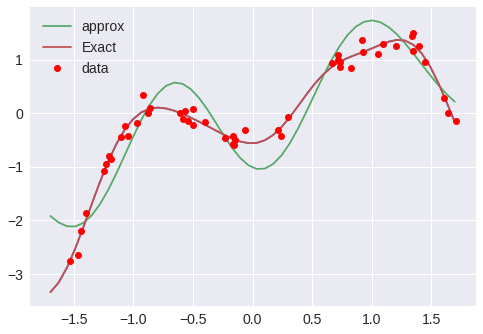

(50, 1)


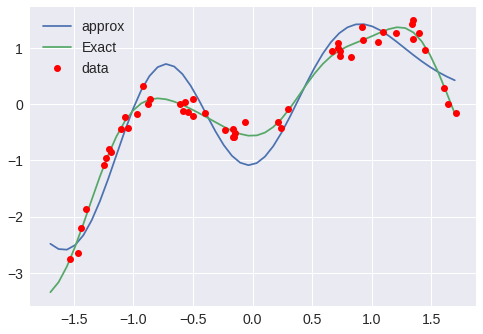

(50, 1)


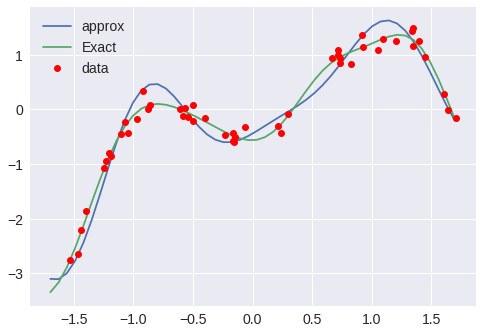

(50, 1)


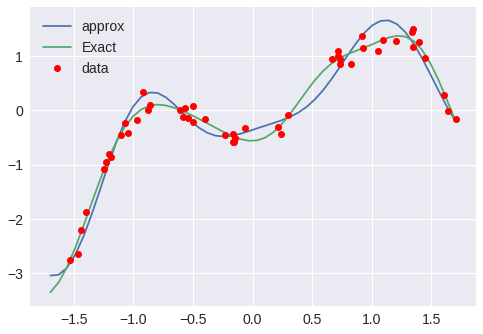

(50, 1)


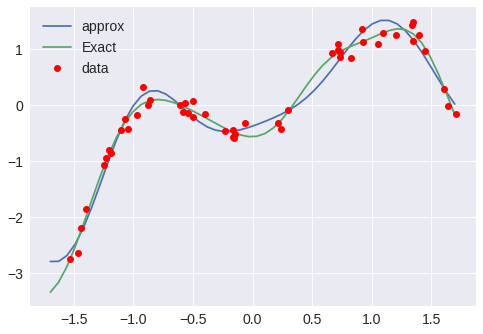

(50, 1)


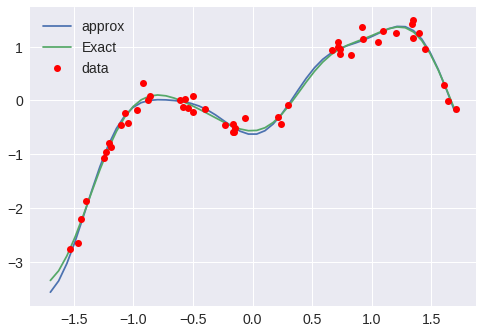

(50, 1)


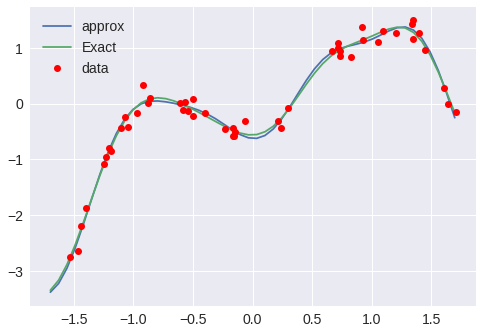

(50, 1)


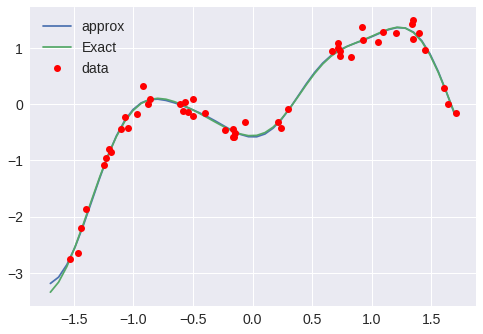

(50, 1)


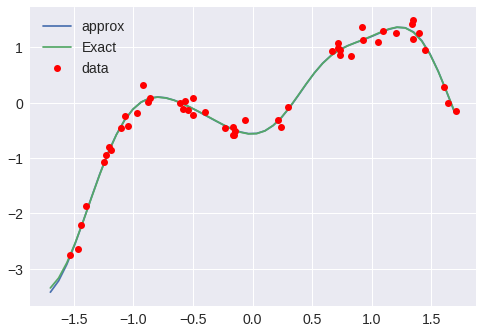

(50, 1)


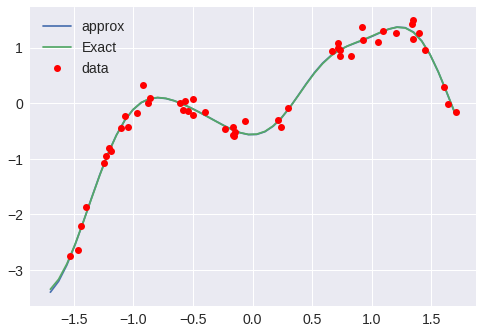

(50, 1)


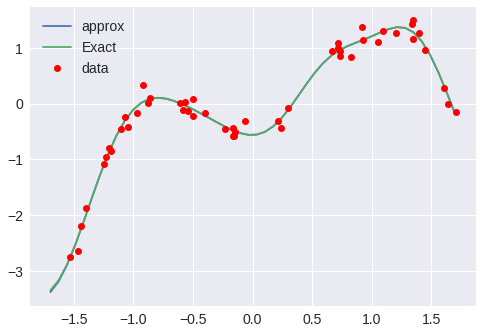

(50, 1)


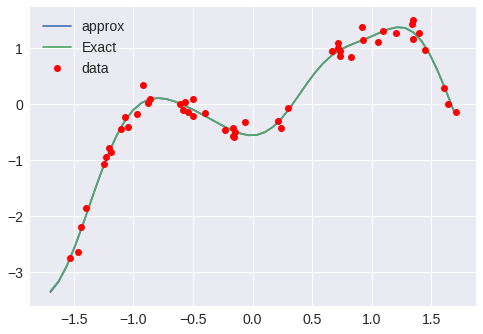

(50, 1)


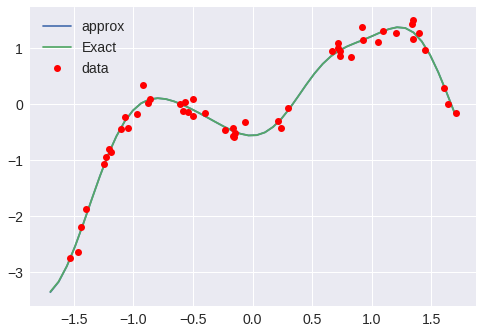

(50, 1)


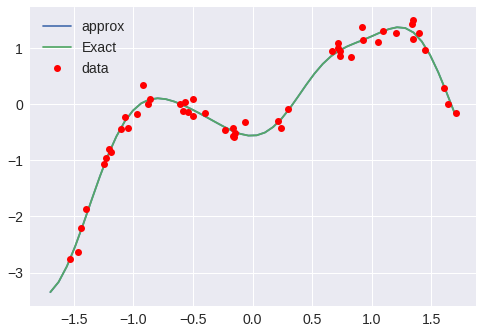

(50, 1)


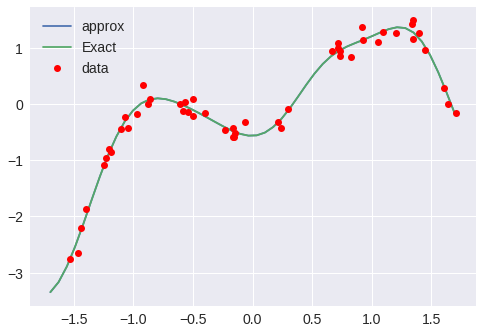

(50, 1)


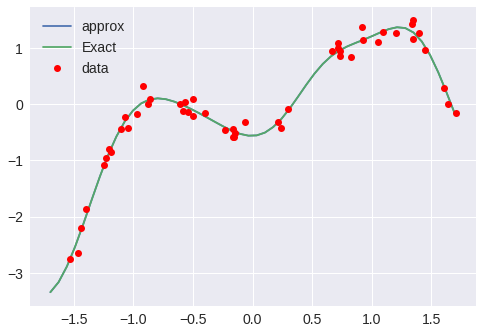

(50, 1)


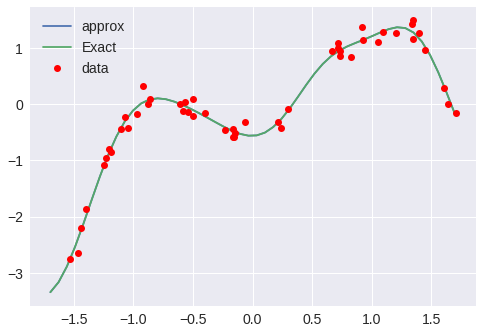

(50, 1)


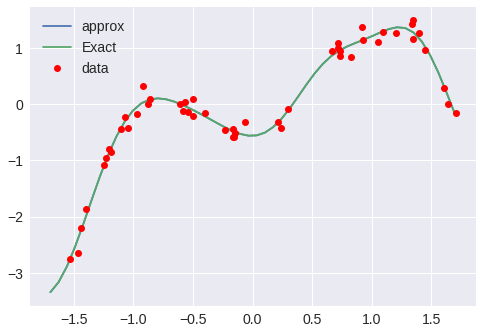

(50, 1)


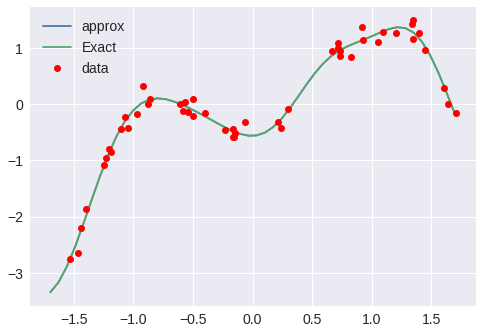

(50, 1)


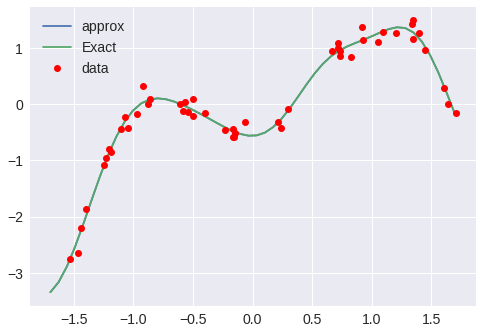

(50, 1)


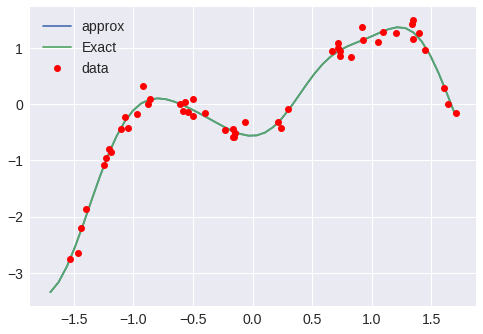

(50, 1)


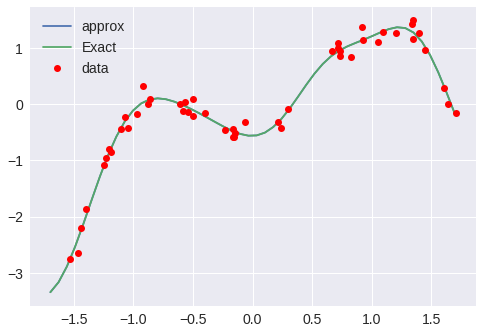

(50, 1)


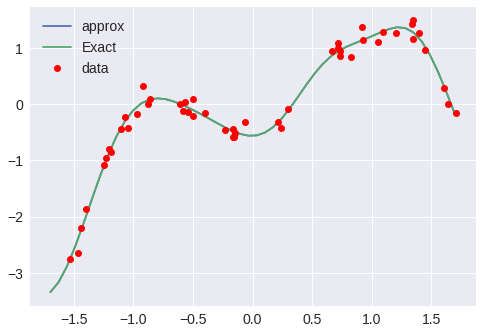

(50, 1)


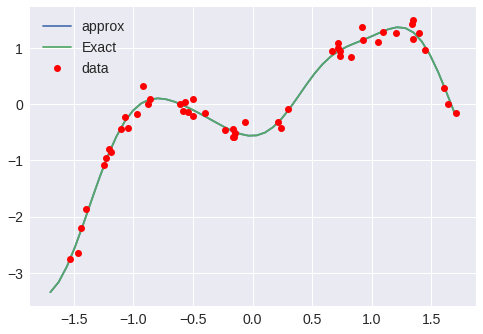

(50, 1)


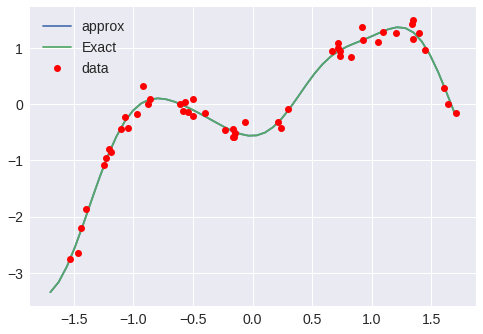

(50, 1)


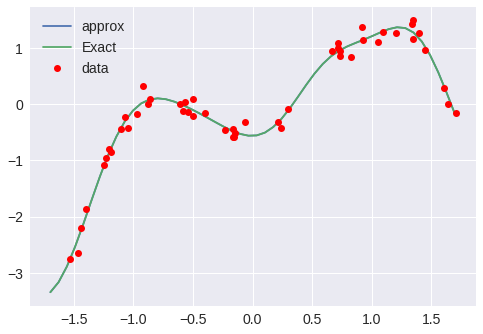

(50, 1)


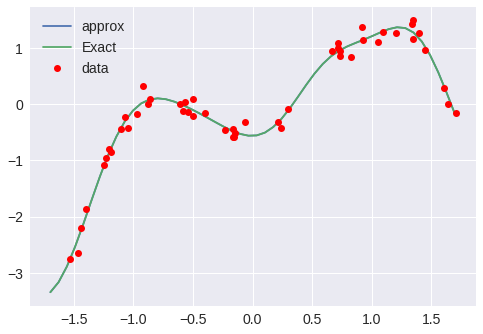

(50, 1)


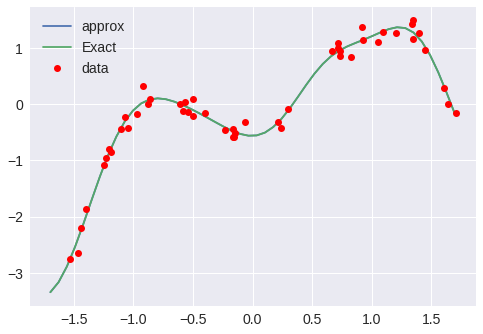

(50, 1)


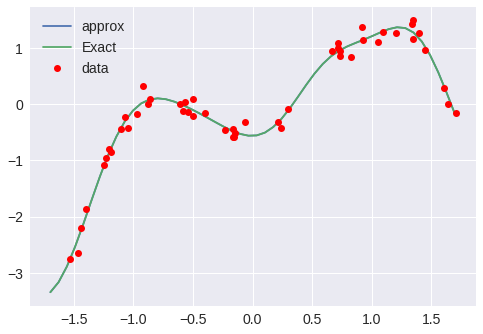

(50, 1)


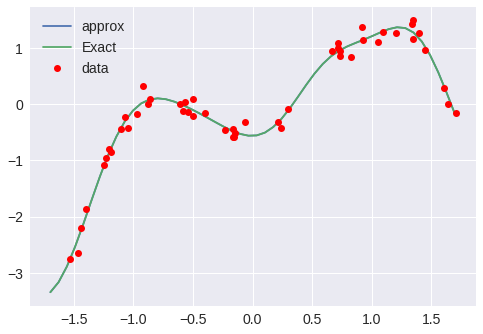

(50, 1)


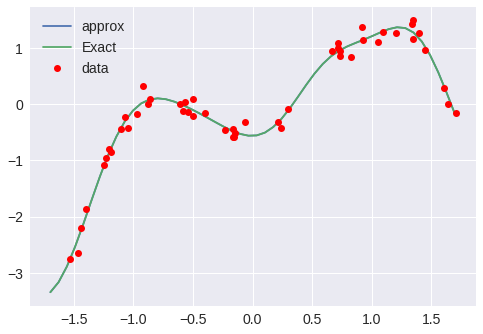

(50, 1)


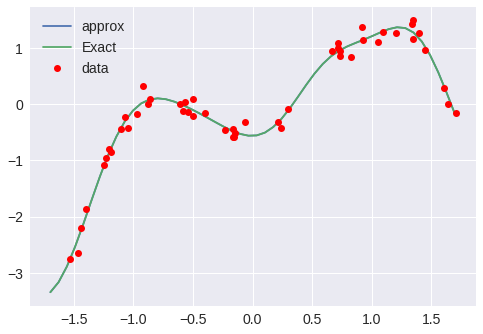

(50, 1)


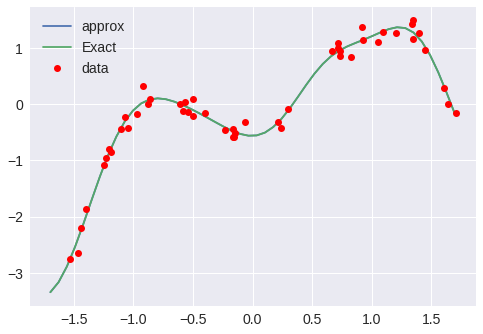

(50, 1)


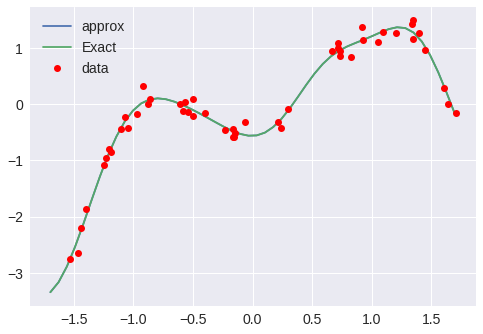

(50, 1)


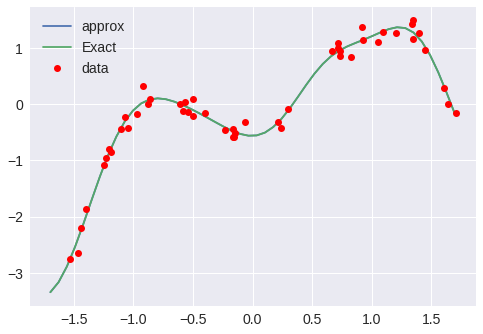

(50, 1)


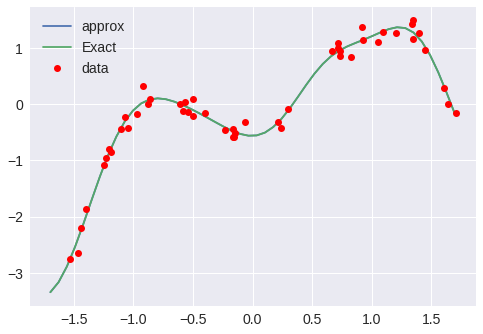

(50, 1)


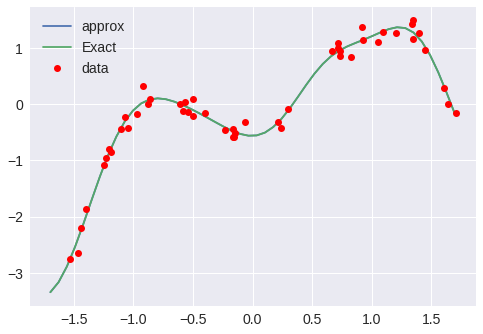

In [95]:
T1 = test_accuracy(x, y, Xnew)

mp.dps = 15


MSE_qPCA = []
ks = np.arange(3, 40, 1)

for ki in ks:
    MSE_qPCA.append(T1.GP_approx( ki,method = 'qPCA'))

## Sparse GP & naive Nystrom

In [87]:
MSE_Nystrom = []
MSE_SGP = []
ms = np.arange(2, 20)

for mi in ms:
    #MSE_Nystrom.append(T1.GP_approx( mi, method = 'Nystrom'))
    mse_mu, mse_var = T1.Sparse_GP_error(num_inducing = mi)
    MSE_SGP.append([mse_mu, mse_var, mi])

Optimization restart 1/2, f = 52.98903628683389
Optimization restart 2/2, f = 52.98903628730352
Optimization restart 1/2, f = 50.52117512502838
Optimization restart 2/2, f = 50.52117511713038
Optimization restart 1/2, f = 50.46756057004794
Optimization restart 2/2, f = 50.467560410555485
Optimization restart 1/2, f = 2.103613452345712
Optimization restart 2/2, f = 2.1036134535946758
Optimization restart 1/2, f = 50.44087101521681
Optimization restart 2/2, f = -0.8560508037917316
Optimization restart 1/2, f = -1.5473389584778943
Optimization restart 2/2, f = -1.5473389593246338
Optimization restart 1/2, f = -1.9006873057971916
Optimization restart 2/2, f = -1.9006873079345041
Optimization restart 1/2, f = -2.2033669679742616
Optimization restart 2/2, f = -1.941365210539061
Optimization restart 1/2, f = -1.94136522704639
Optimization restart 2/2, f = -3.058100548051925
Optimization restart 1/2, f = 50.44085886922181
Optimization restart 2/2, f = -3.1907005031146127
Optimization restart 1

 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/rbf.py:51: RuntimeWarning:overflow encountered in square
 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/GPy/kern/src/stationary.py:339: RuntimeWarning:invalid value encountered in true_divide


Optimization restart 1/2, f = -3.2773703255736564
Optimization restart 2/2, f = -3.277409238521386
Optimization restart 1/2, f = -3.2773778888074503
Optimization restart 2/2, f = 50.44084979861951
Optimization restart 1/2, f = -3.2774271566715925
Optimization restart 2/2, f = -3.2773772137834385
Optimization restart 1/2, f = -3.277368596928909
Optimization restart 2/2, f = -3.277424986420783


Text(0.5, 1.0, 'qPCA vs Sparse GP')

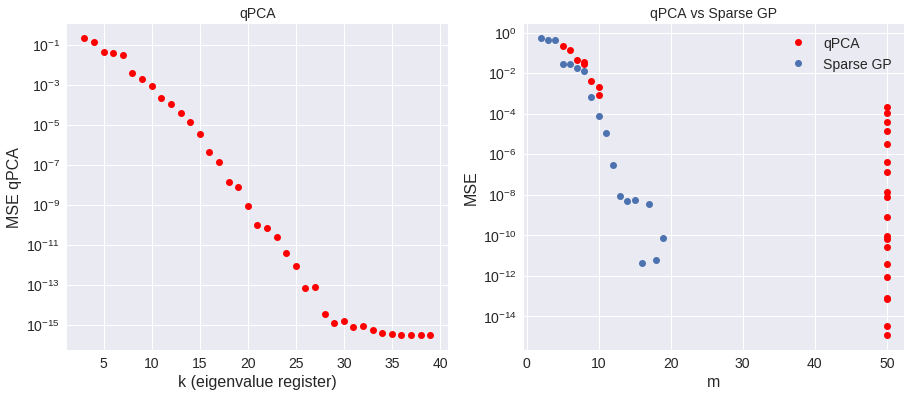

In [96]:



plt.figure(figsize = (15, 6))

plt.subplot(1, 2, 1)
plt.semilogy(ks, np.array(MSE_qPCA)[:, 0], 'or')
plt.ylabel('MSE qPCA')
plt.xlabel('k (eigenvalue register)')
plt.title('qPCA')


plt.subplot(1, 2, 2)
plt.semilogy(np.array(MSE_qPCA)[:-10, 2], np.array(MSE_qPCA)[:-10, 0], 'ro', label = 'qPCA')
plt.xlabel('m')
plt.plot(ms, np.array(MSE_SGP)[:, 0], 'o', label = 'Sparse GP')
plt.legend()
plt.ylabel('MSE')
plt.title('qPCA vs Sparse GP')






(50, 1)


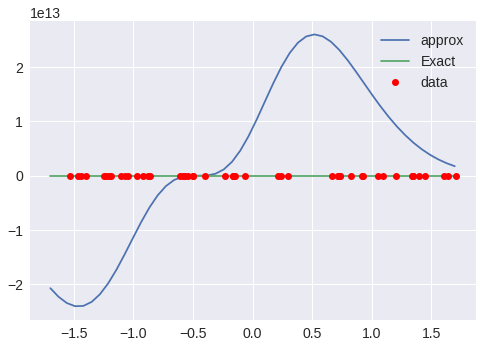

(50, 1)


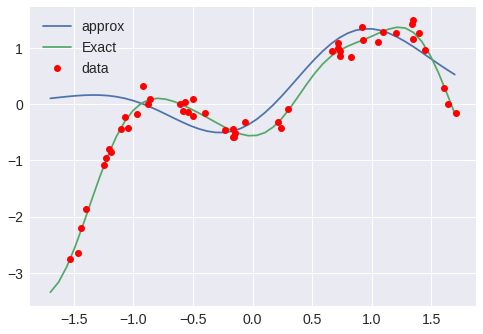

(50, 1)


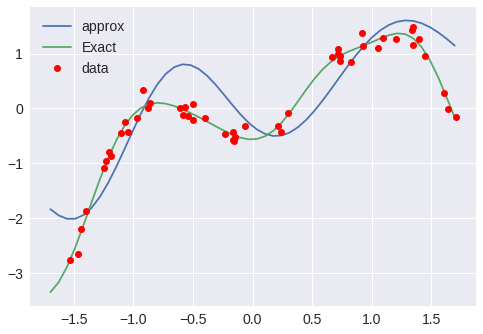

(50, 1)


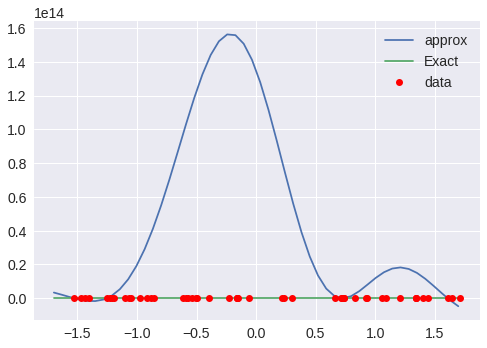

(50, 1)


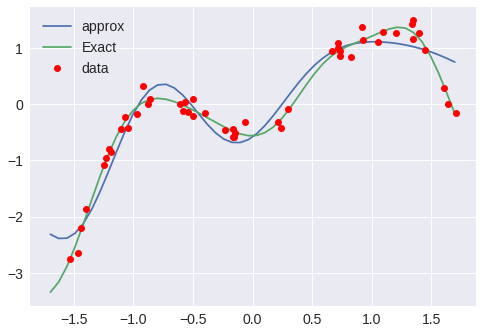

(50, 1)


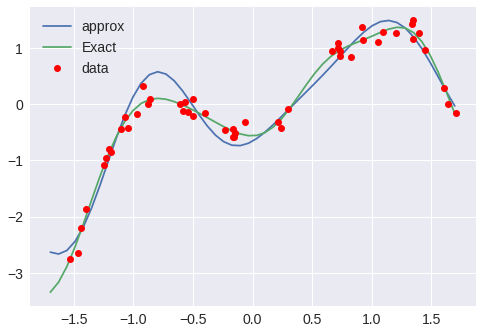

(50, 1)


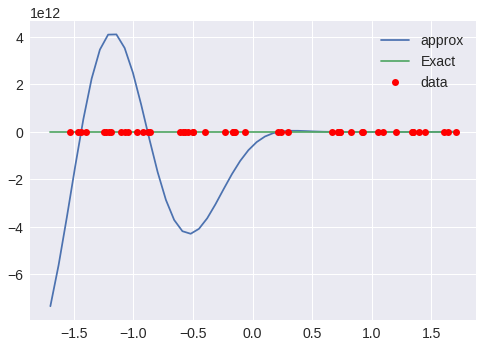

(50, 1)


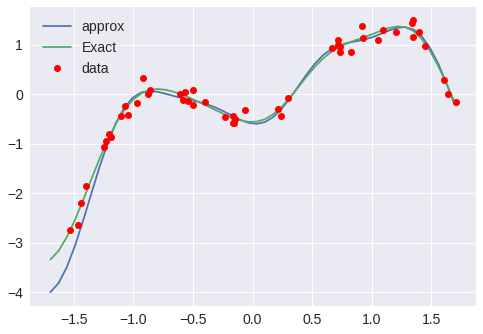

(50, 1)


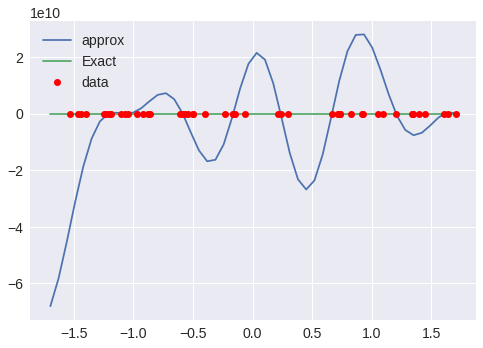

(50, 1)


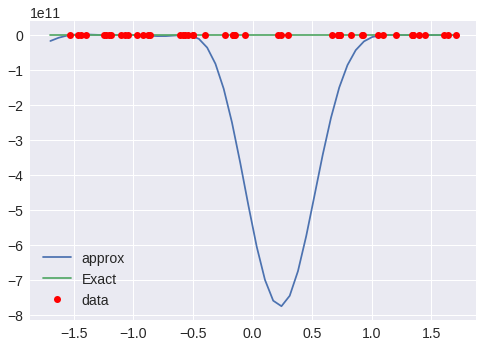

(50, 1)


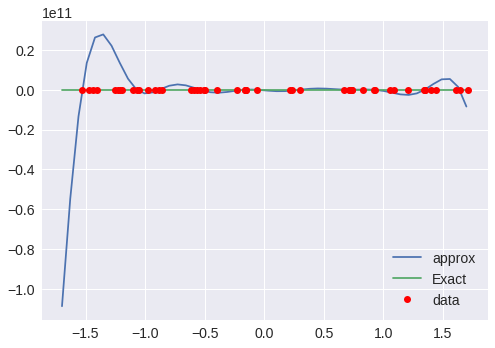

(50, 1)


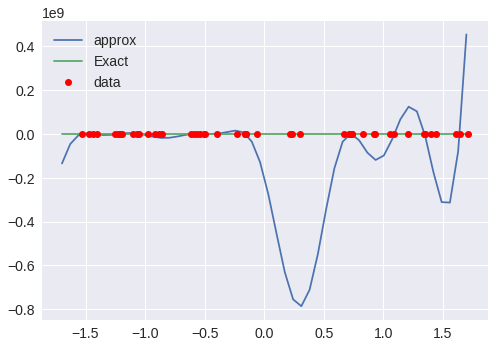

(50, 1)


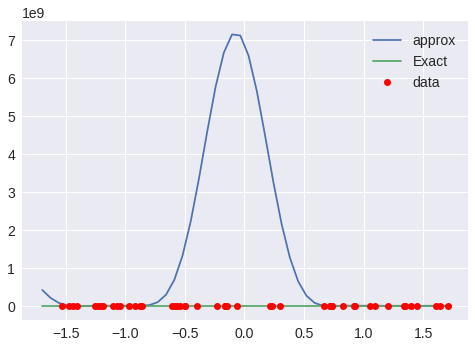

(50, 1)


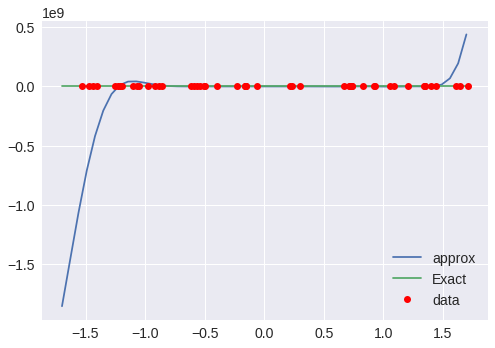

(50, 1)


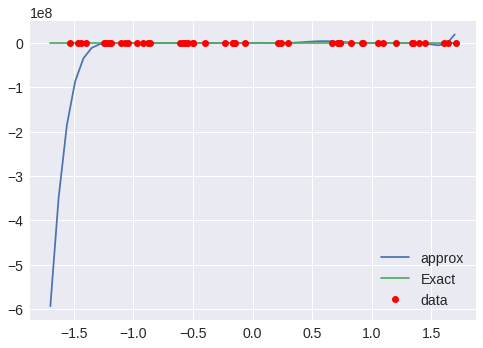

(50, 1)


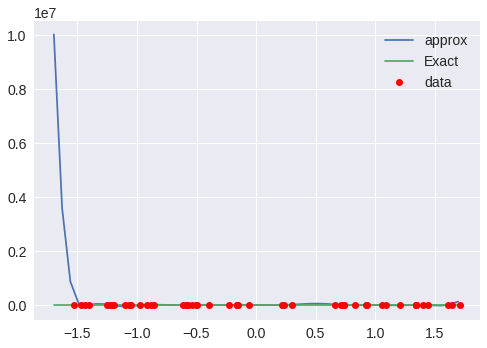

(50, 1)


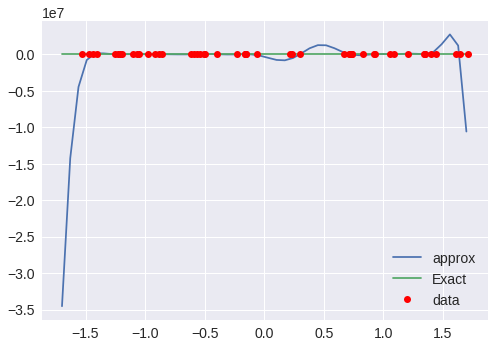

(50, 1)


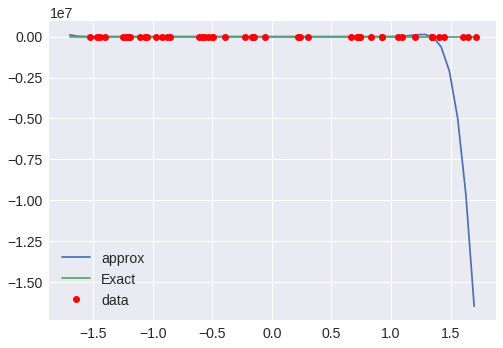

In [182]:
for mi in ms:
    MSE_Nystrom.append(T1.GP_approx( mi, method = 'Nystrom'))
    
    
    


## Neural net
simplest MLP

Results: -0.70 (0.32) MSE


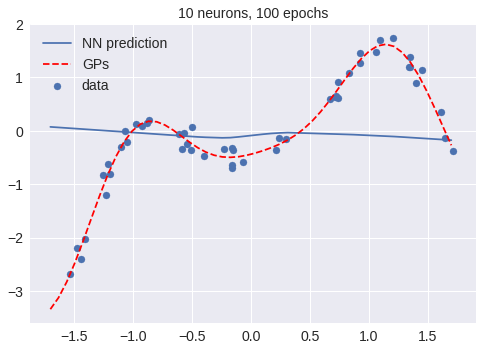

Results: -0.55 (0.12) MSE


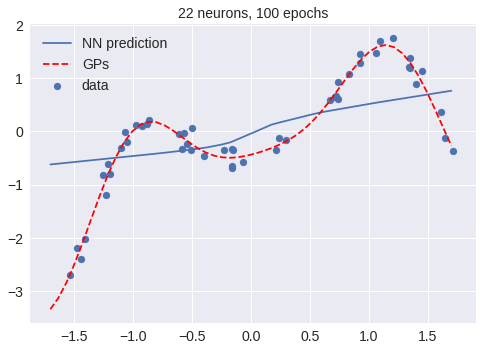

Results: -0.45 (0.05) MSE


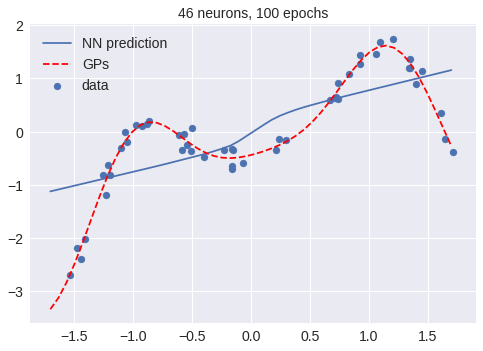

Results: -0.43 (0.03) MSE


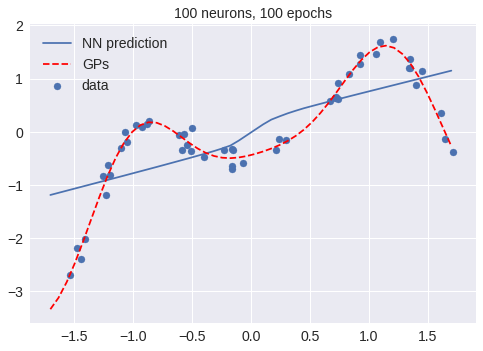

Results: -0.42 (0.03) MSE


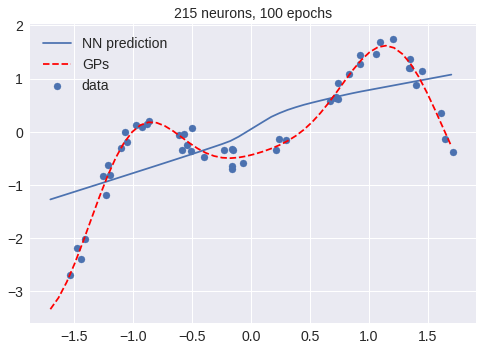

Results: -0.42 (0.04) MSE


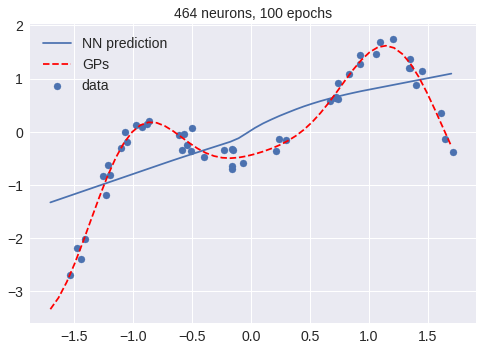

Results: -0.40 (0.04) MSE


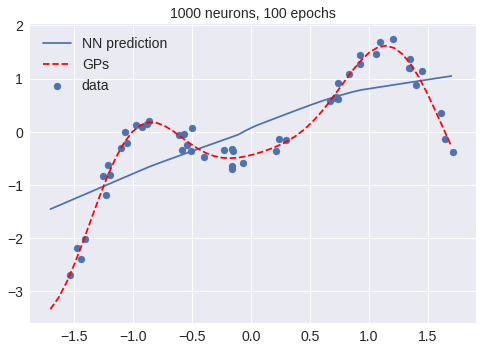

Results: -0.61 (0.14) MSE


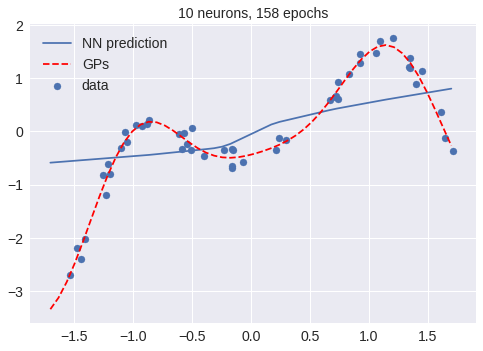

Results: -0.45 (0.02) MSE


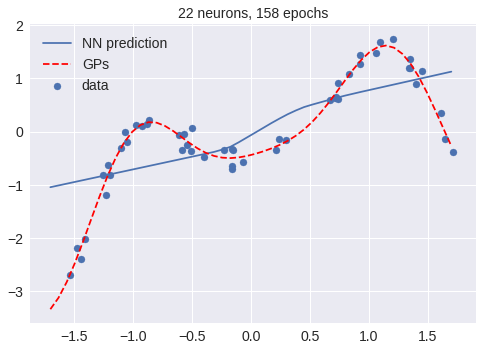

Results: -0.43 (0.04) MSE


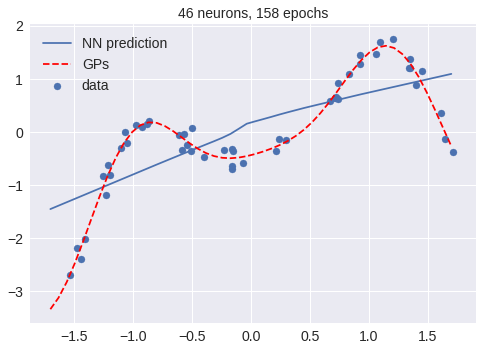

Results: -0.41 (0.03) MSE


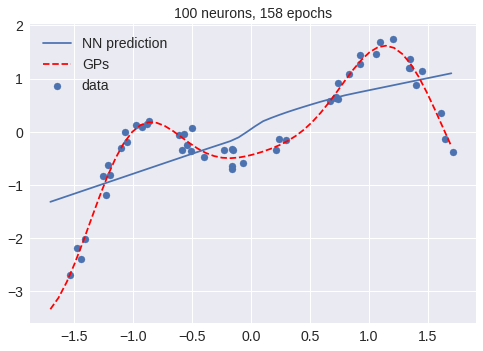

Results: -0.41 (0.04) MSE


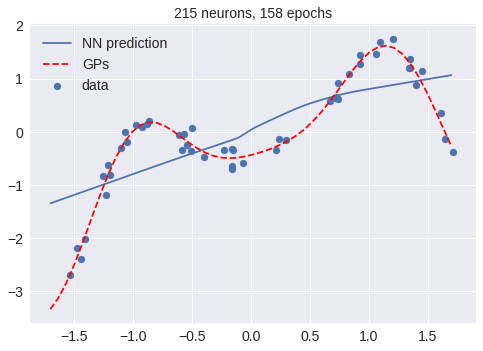

Results: -0.38 (0.05) MSE


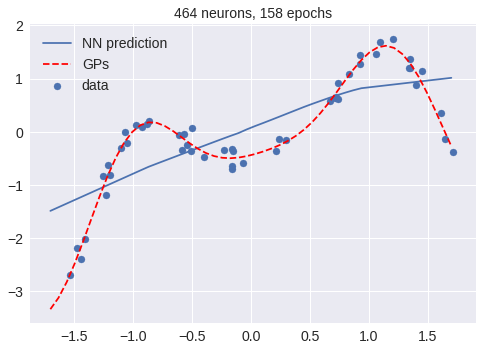

Results: -0.34 (0.05) MSE


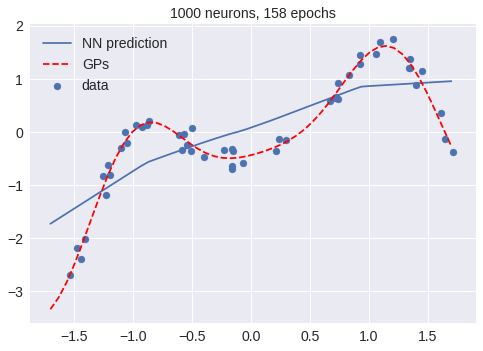

Results: -0.44 (0.04) MSE


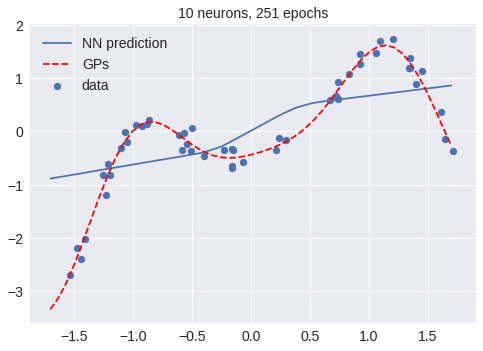

Results: -0.45 (0.04) MSE


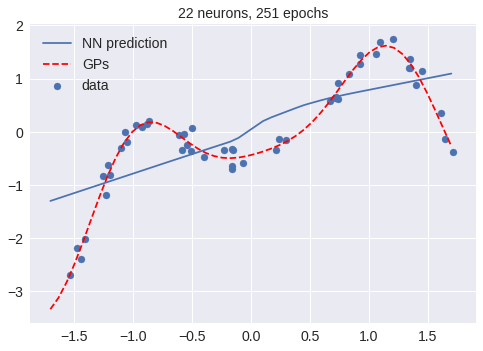

Results: -0.42 (0.04) MSE


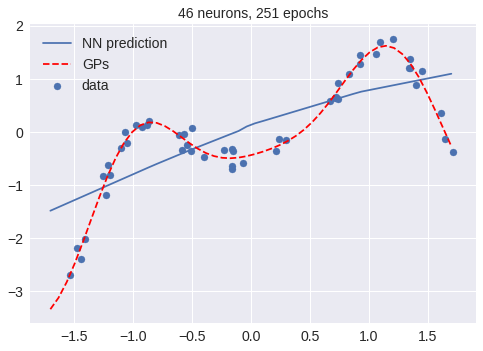

Results: -0.41 (0.04) MSE


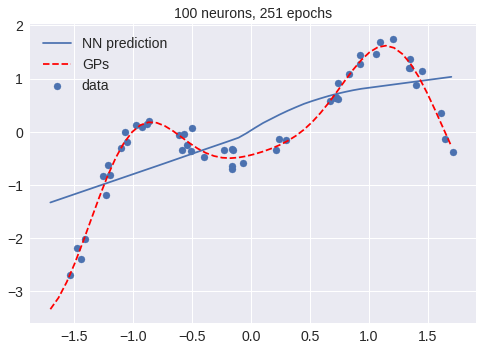

Results: -0.38 (0.05) MSE


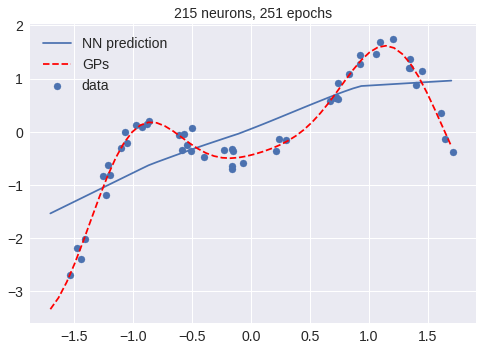

Results: -0.30 (0.06) MSE


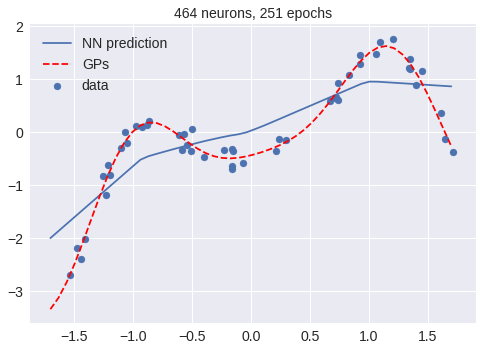

Results: -0.21 (0.07) MSE


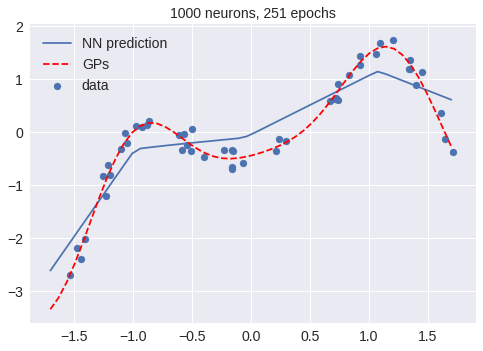

Results: -0.43 (0.04) MSE


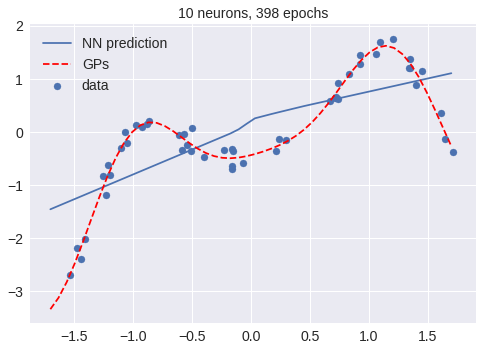

Results: -0.43 (0.05) MSE


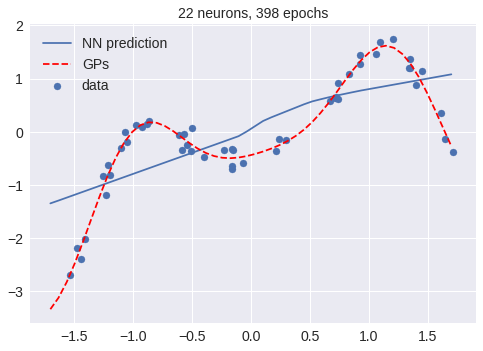

Results: -0.40 (0.04) MSE


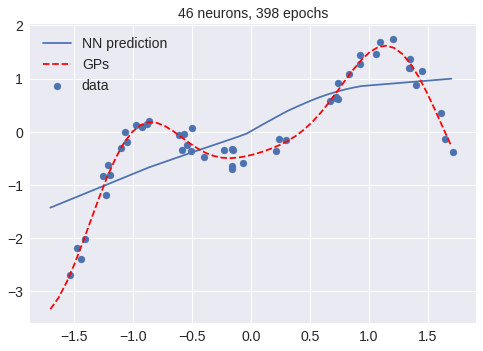

Results: -0.37 (0.06) MSE


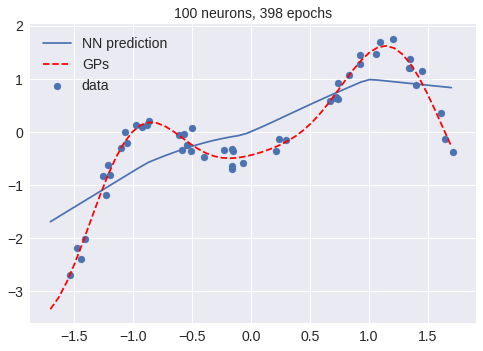

Results: -0.27 (0.07) MSE


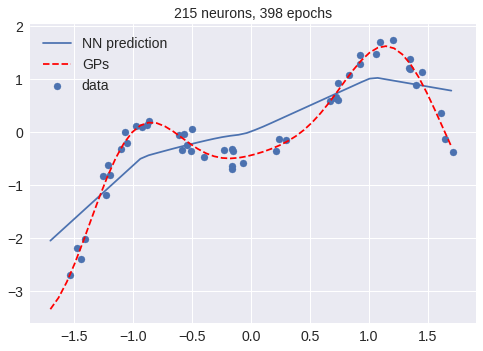

Results: -0.15 (0.06) MSE


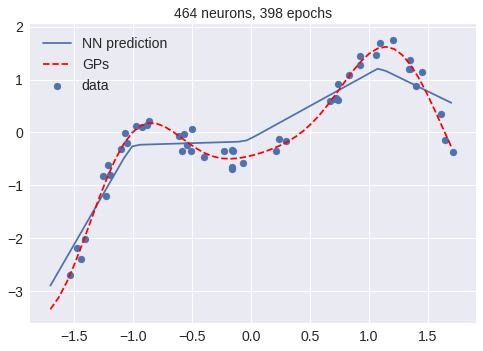

Results: -0.06 (0.03) MSE


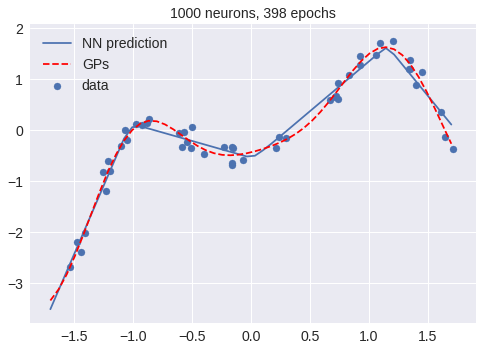

Results: -0.43 (0.03) MSE


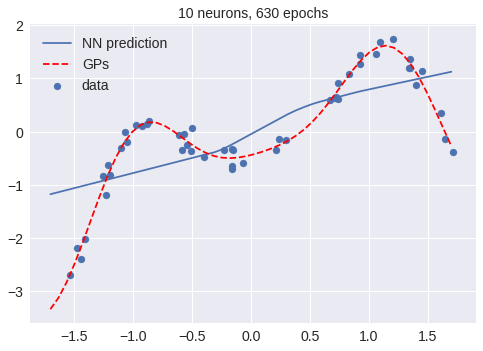

Results: -0.41 (0.04) MSE


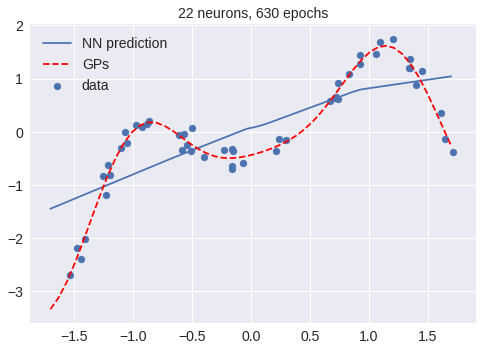

Results: -0.35 (0.06) MSE


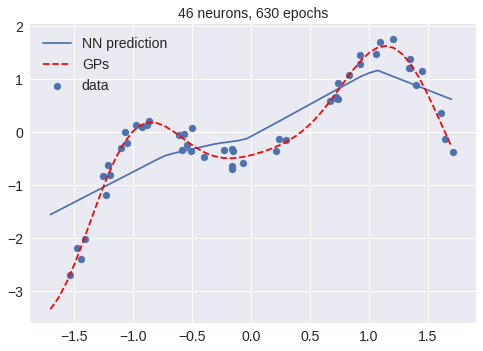

Results: -0.28 (0.07) MSE


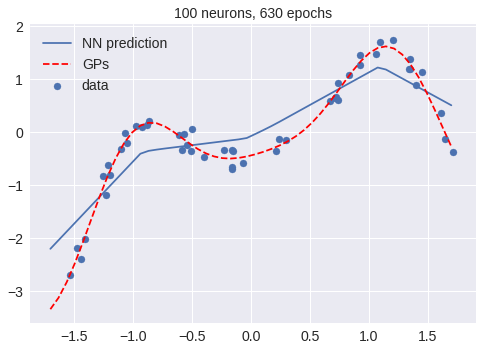

Results: -0.11 (0.03) MSE


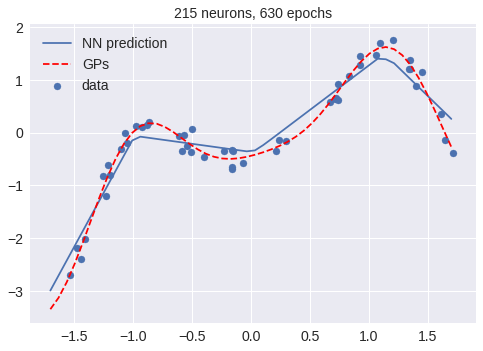

Results: -0.04 (0.01) MSE


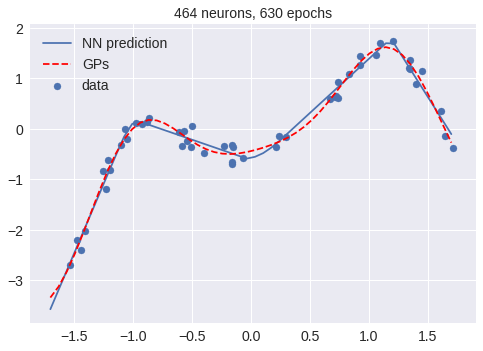

Results: -0.03 (0.01) MSE


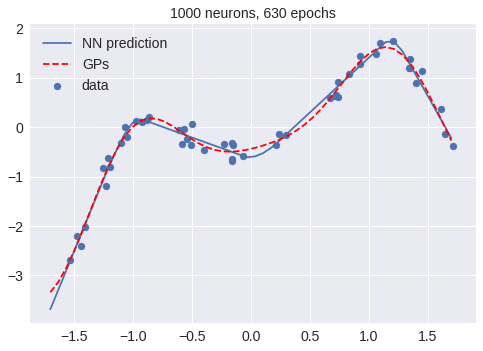

Results: -0.33 (0.15) MSE


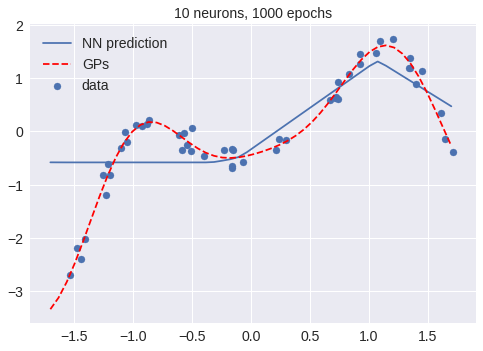

Results: -0.32 (0.03) MSE


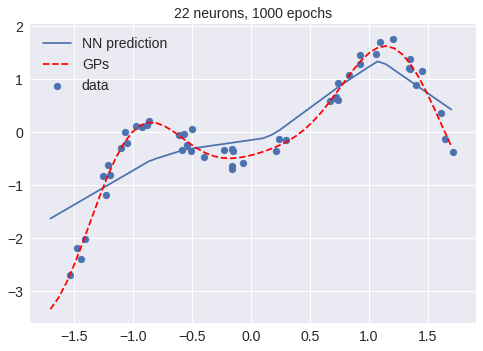

Results: -0.16 (0.02) MSE


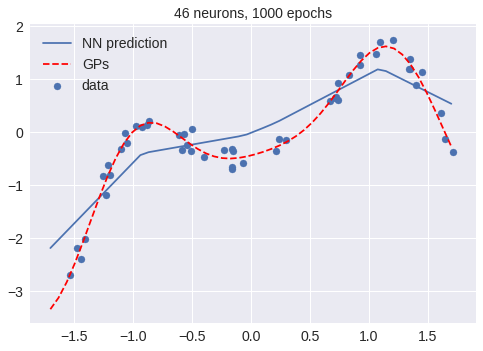

Results: -0.07 (0.02) MSE


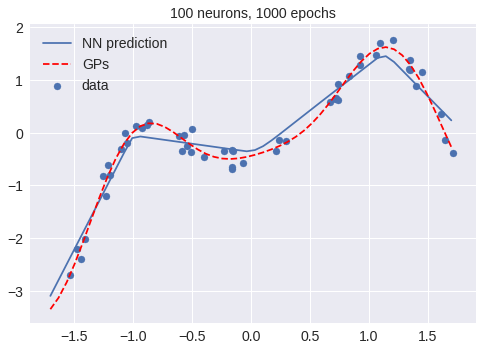

Results: -0.03 (0.01) MSE


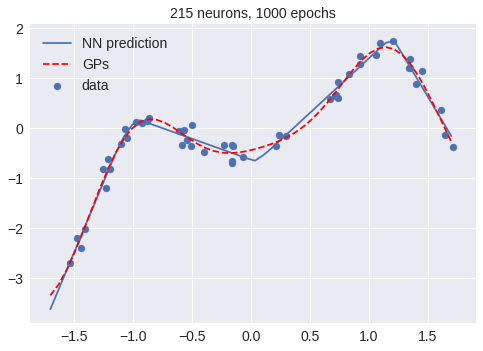

Results: -0.03 (0.01) MSE


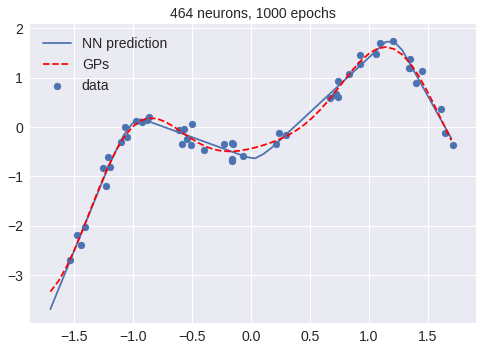

Results: -0.03 (0.01) MSE


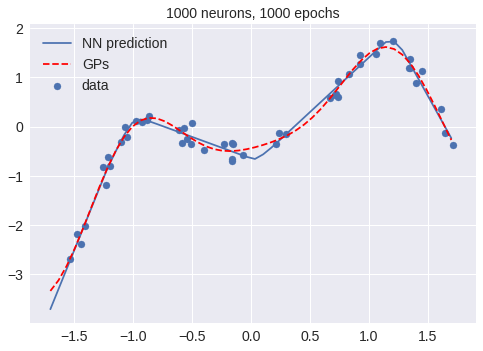

Results: -0.37 (0.08) MSE


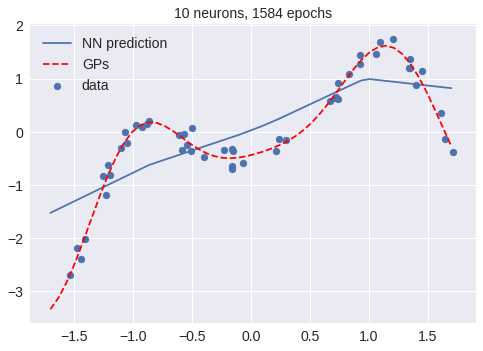

Results: -0.26 (0.07) MSE


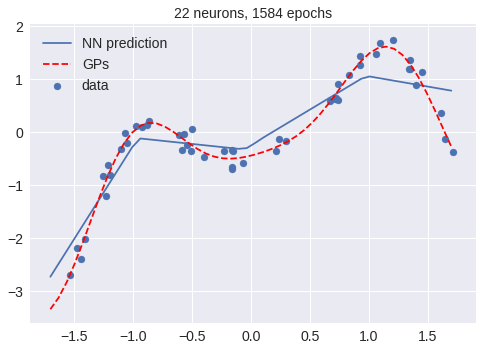

Results: -0.09 (0.06) MSE


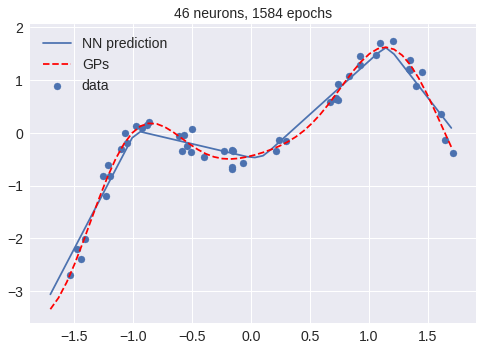

Results: -0.03 (0.01) MSE


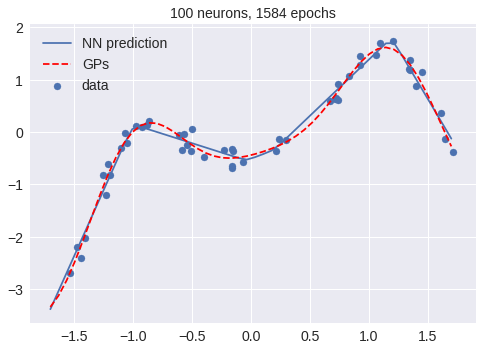

Results: -0.03 (0.01) MSE


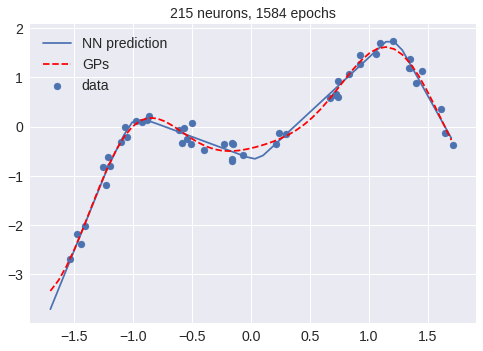

Results: -0.03 (0.01) MSE


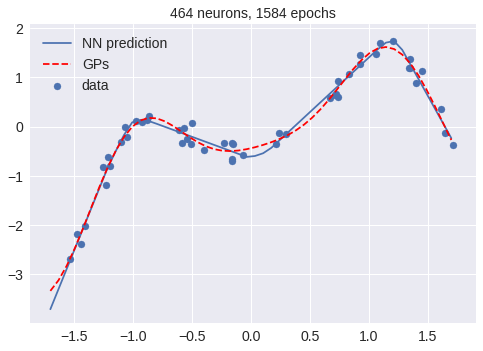

Results: -0.03 (0.01) MSE


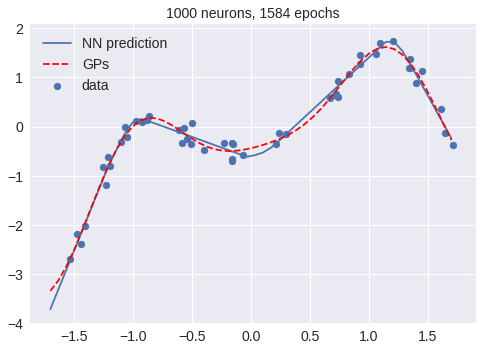

Results: -0.18 (0.11) MSE


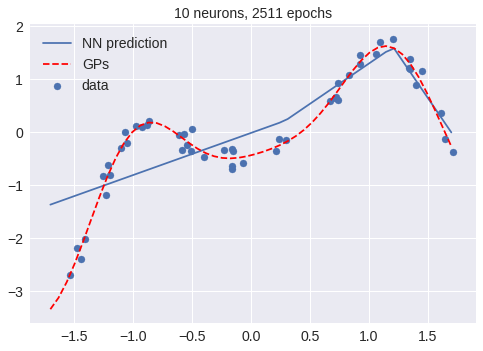

Results: -0.04 (0.01) MSE


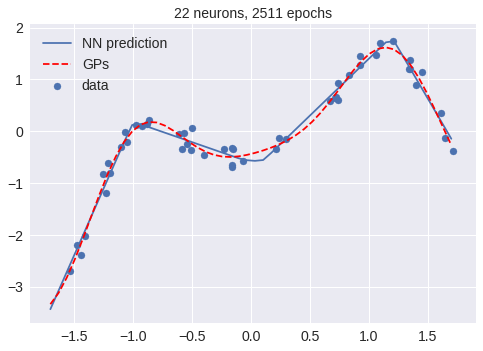

Results: -0.03 (0.01) MSE


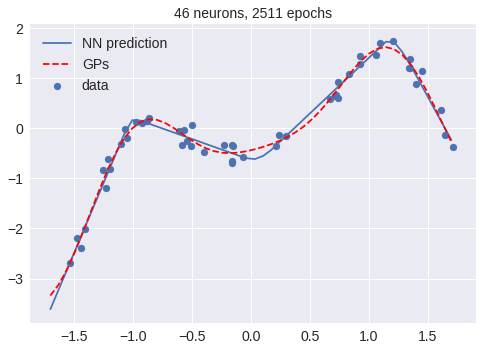

Results: -0.03 (0.01) MSE


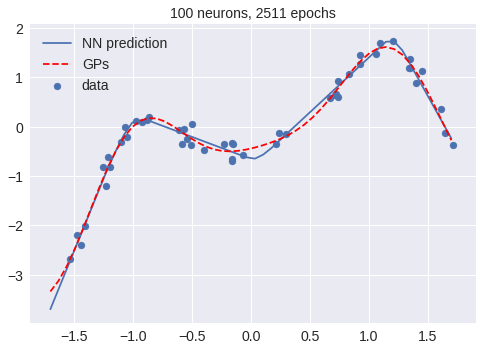

Results: -0.03 (0.01) MSE


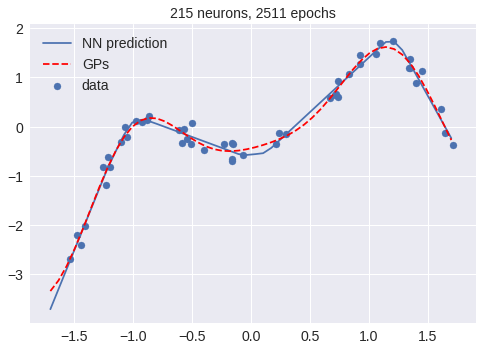

Results: -0.03 (0.01) MSE


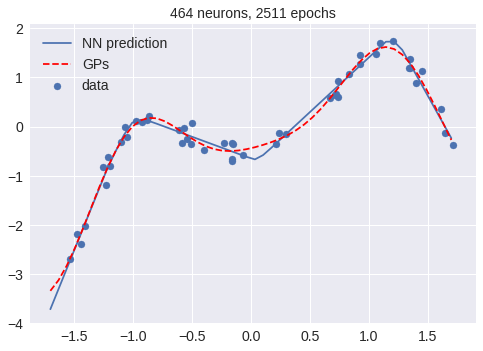

Results: -0.03 (0.01) MSE


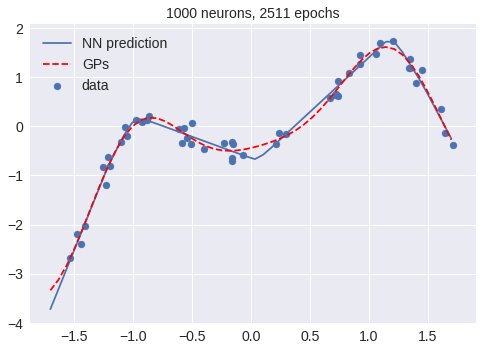

Results: -0.07 (0.08) MSE


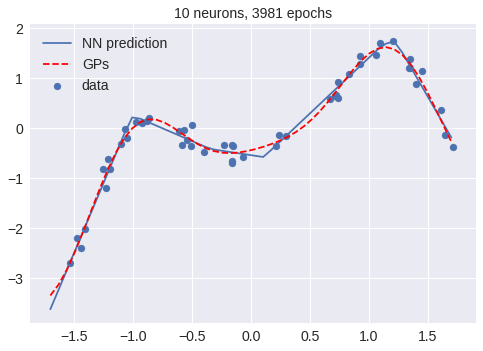

Results: -0.03 (0.01) MSE


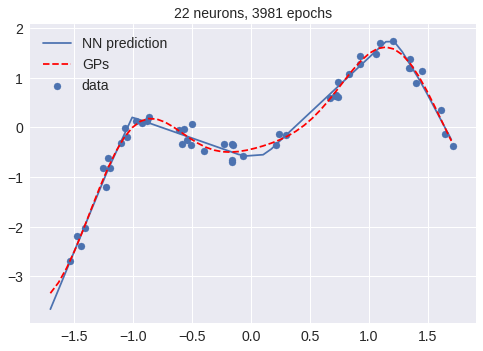

Results: -0.03 (0.01) MSE


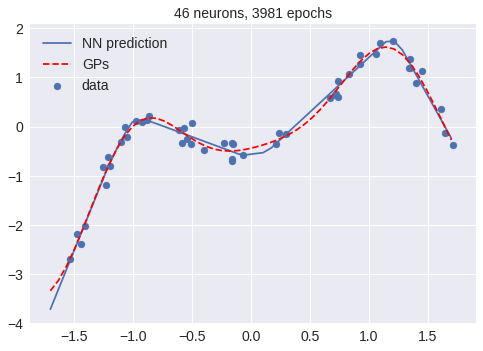

Results: -0.03 (0.01) MSE


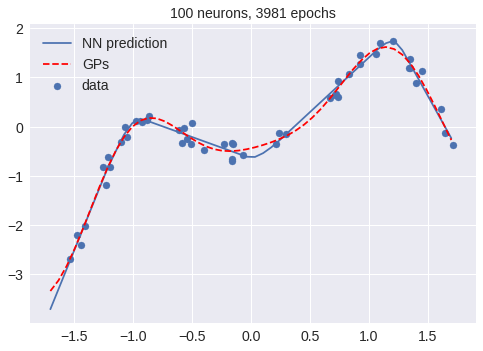

Results: -0.03 (0.01) MSE


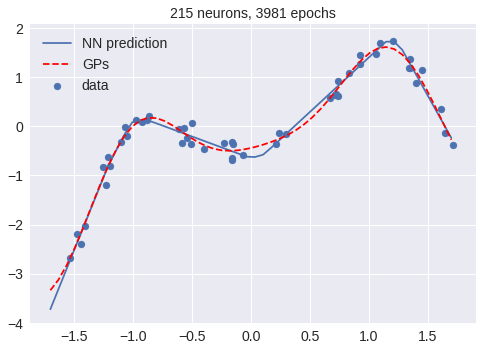

Results: -0.03 (0.01) MSE


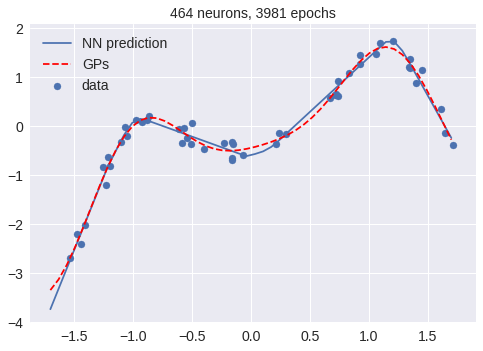

Results: -0.03 (0.01) MSE


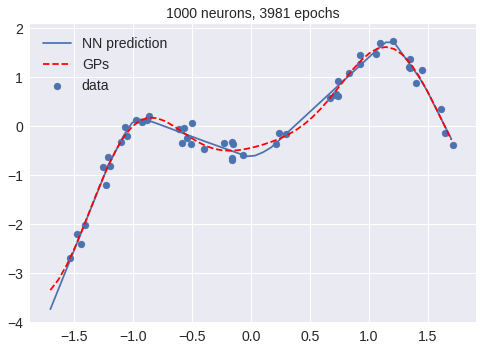

Results: -0.03 (0.01) MSE


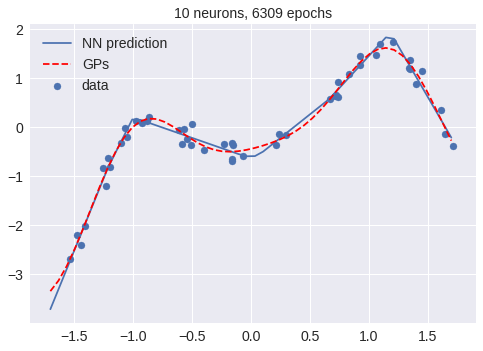

Results: -0.03 (0.01) MSE


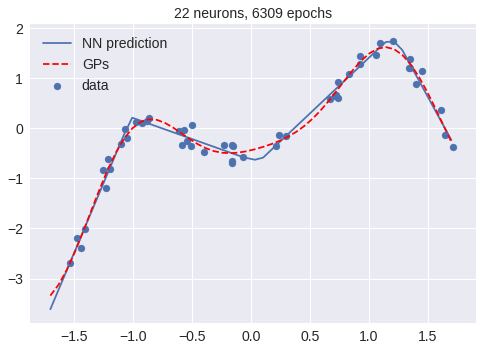

Results: -0.03 (0.01) MSE


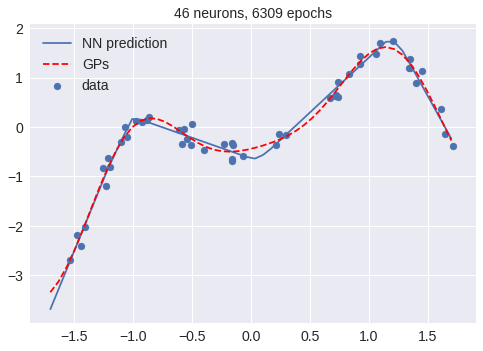

Results: -0.03 (0.01) MSE


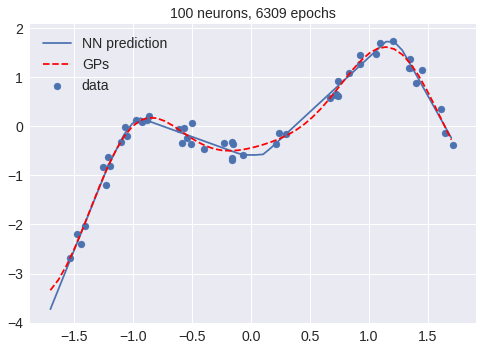

Results: -0.03 (0.01) MSE


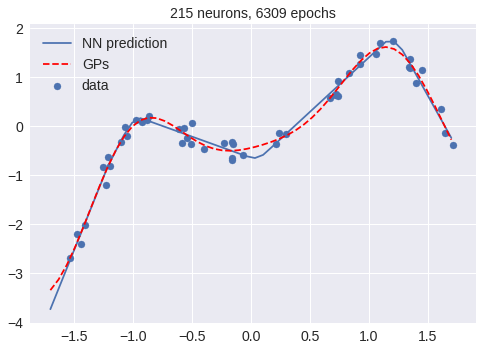

Results: -0.03 (0.01) MSE


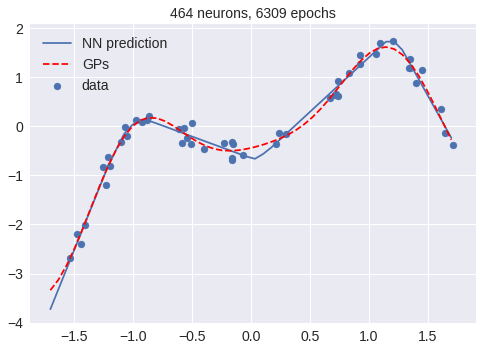

Results: -0.03 (0.01) MSE


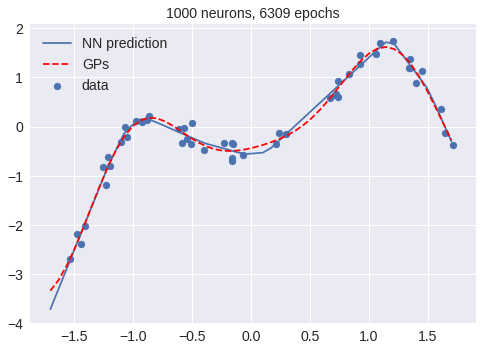

Results: -0.06 (0.06) MSE


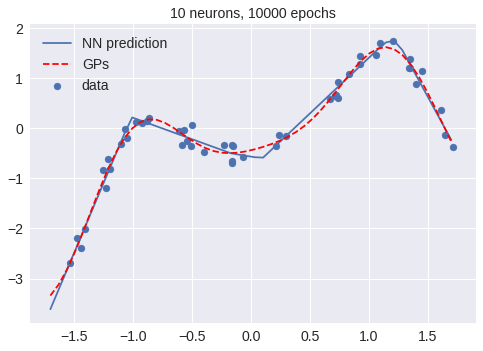

Results: -0.06 (0.06) MSE


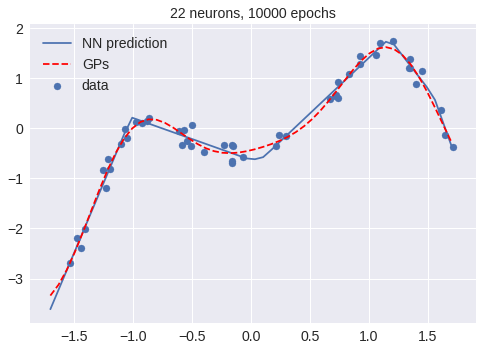

Results: -0.03 (0.01) MSE


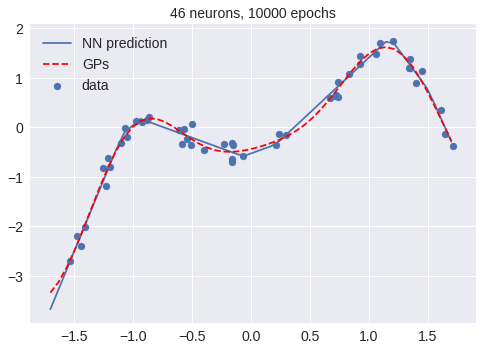

Results: -0.03 (0.01) MSE


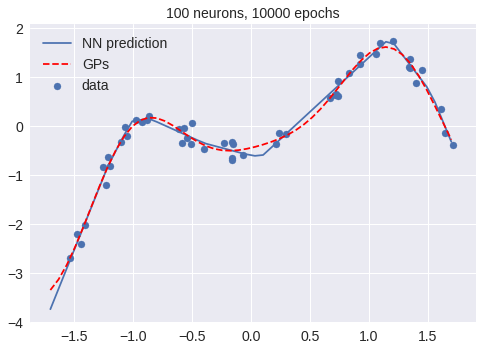

Results: -0.03 (0.01) MSE


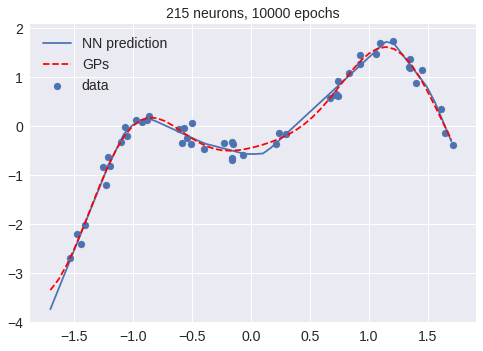

Results: -0.03 (0.01) MSE


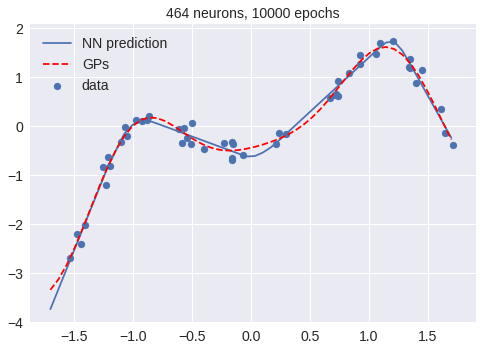

Results: -0.03 (0.01) MSE


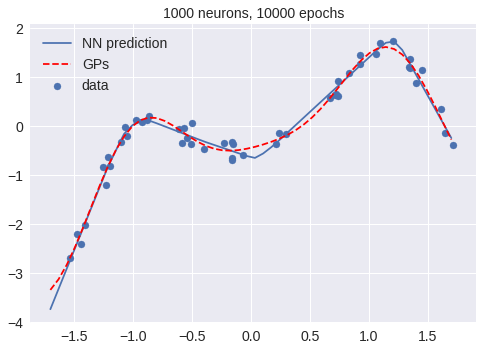

In [169]:
MSE_nn = []
for epo in np.logspace(2, 4, 11):
    mse_epo = []
    for n in np.round(np.logspace(1, 3, 7)):
        mse_epo.append(T1.MLP_NN_error(neurons1 = int(n), epochs = int(epo), plot = True))
        plt.show()
    MSE_nn.append(mse_epo)

Text(0.5, 0.98, 'MLP Neural Net vs GP. ')

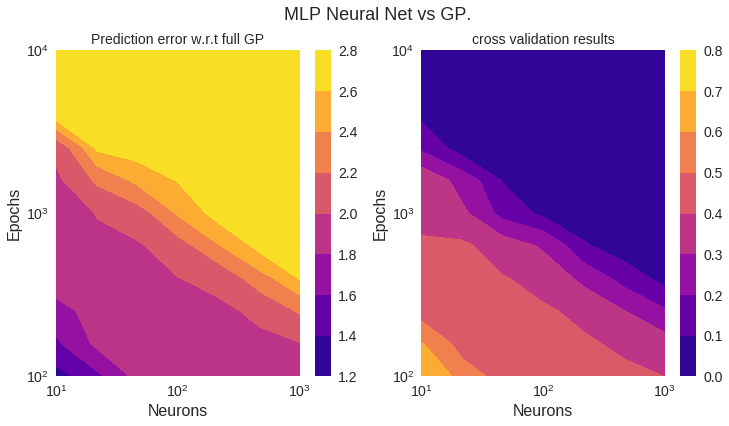

In [171]:
plt.figure(figsize = (12, 6))

plt.subplot(1,2, 1)
plt.contourf(np.logspace(1, 3, 7) ,np.logspace(2, 4, 11), np.array(MSE_nn)[:, :, 0], cmap = 'plasma')
plt.title('Prediction error w.r.t full GP')

plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Neurons')
plt.ylabel('Epochs')


plt.subplot(1,  2, 2)
plt.contourf(np.logspace(1, 3, 7) ,np.logspace(2, 4, 11), -np.array(MSE_nn)[:, :, 1], cmap = 'plasma')
plt.title('cross validation results')

plt.colorbar()
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Neurons')
plt.ylabel('Epochs')

plt.suptitle('MLP Neural Net vs GP. ')



Results: -0.19 (0.09) MSE


(2.760833294054865, -0.18816492557525635)

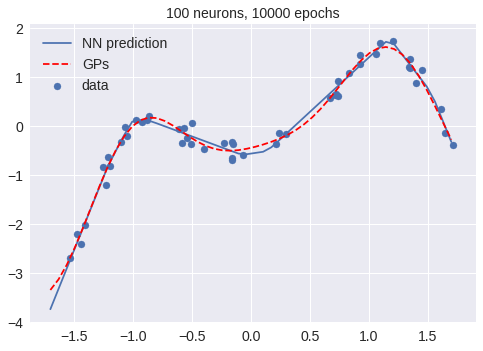

In [160]:
T1.MLP_NN_error(neurons1 = 100, epochs = 10000, plot = True)


Optimization restart 1/2, f = 53.82110662881751
Optimization restart 2/2, f = 53.82110662869717


 /home/gawel/anaconda3/envs/MLenv/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


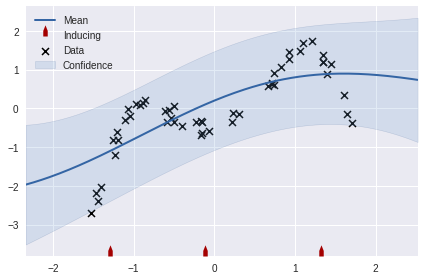

Optimization restart 1/2, f = 53.78145814142452
Optimization restart 2/2, f = 53.781458114950134


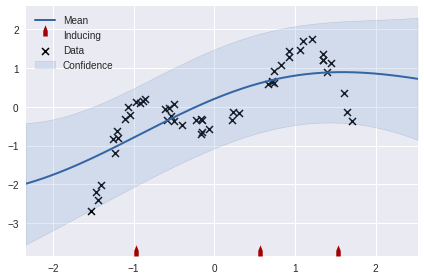

Optimization restart 1/2, f = 8.457688200206007
Optimization restart 2/2, f = 8.457688200765801


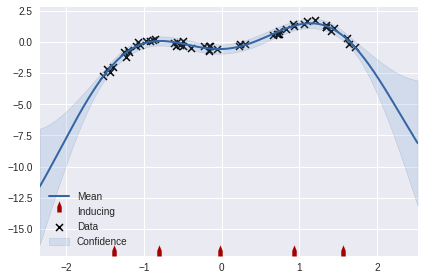

Optimization restart 1/2, f = 6.585234616651292
Optimization restart 2/2, f = 53.74883174594085


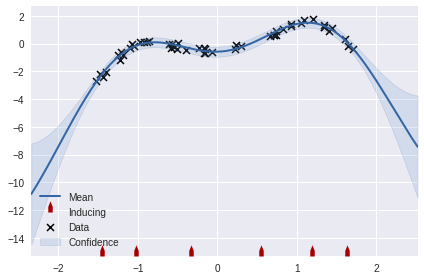

Optimization restart 1/2, f = 1.8972116136073964
Optimization restart 2/2, f = 1.8972116137871353


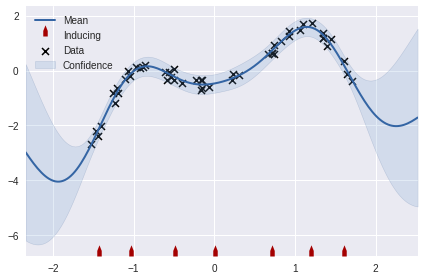

Optimization restart 1/2, f = 0.35670745354309474
Optimization restart 2/2, f = 0.3567074537111239


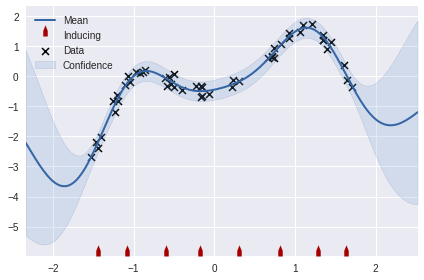

Optimization restart 1/2, f = 0.026612206988374965
Optimization restart 2/2, f = 0.02661220926279384


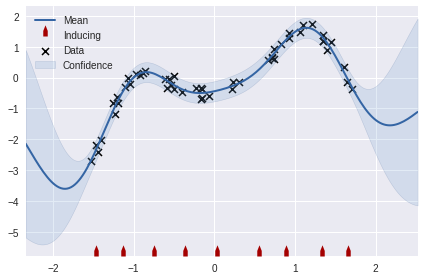

Optimization restart 1/2, f = -0.04591129506206926
Optimization restart 2/2, f = -0.04591129452819587


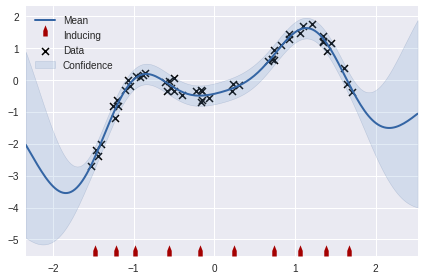

Optimization restart 1/2, f = -0.054268628441832334
Optimization restart 2/2, f = -0.05426863922616576


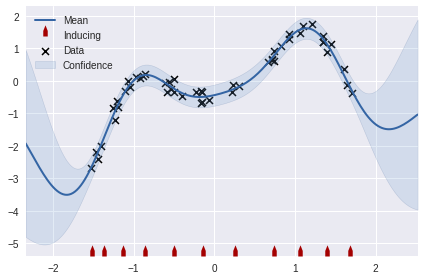

Optimization restart 1/2, f = -0.05906426213368832
Optimization restart 2/2, f = -0.05906431495986908


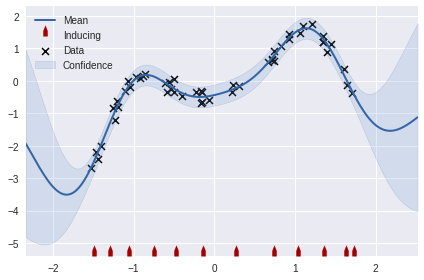

Optimization restart 1/2, f = -0.05912640213273335
Optimization restart 2/2, f = -0.05913178484343007


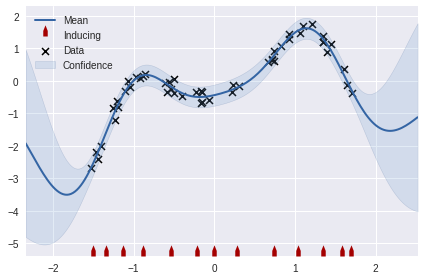

Optimization restart 1/2, f = -0.05912550006632955
Optimization restart 2/2, f = -0.05913212645123167


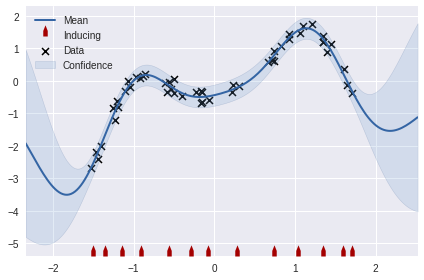

Optimization restart 1/2, f = -0.05912995387348019
Optimization restart 2/2, f = -0.05913276427463643


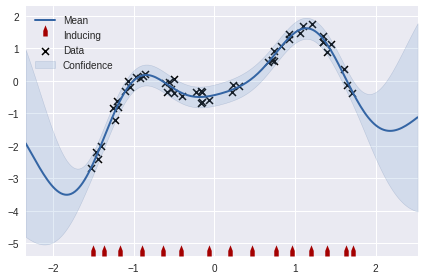

Results: -0.33 (0.03) MSE


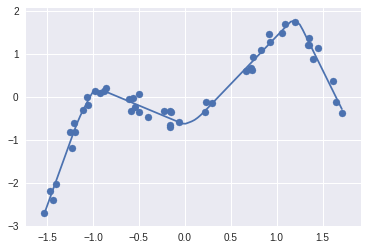

Results: -0.31 (0.04) MSE


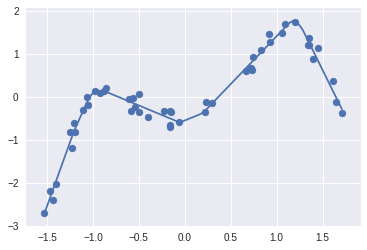

Results: -0.26 (0.06) MSE


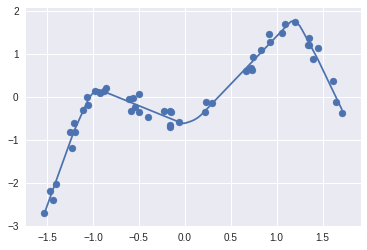

Results: -0.19 (0.03) MSE


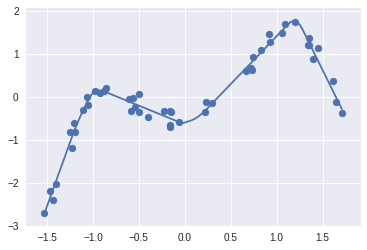

Results: -0.17 (0.05) MSE


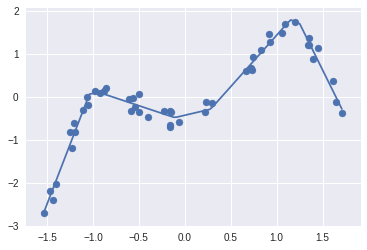

Results: -0.33 (0.04) MSE


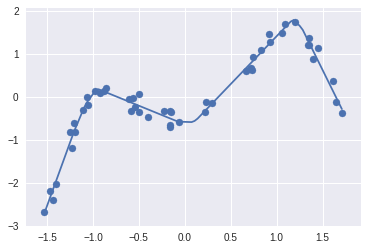

Results: -0.31 (0.04) MSE


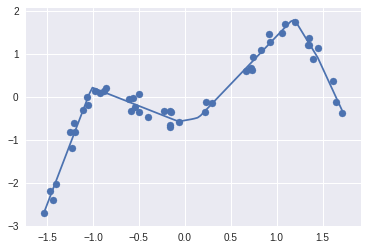

Results: -0.28 (0.05) MSE


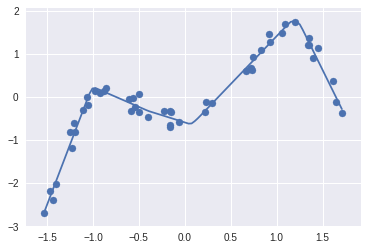

Results: -0.22 (0.07) MSE


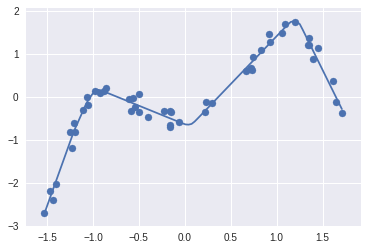

KeyboardInterrupt: 

In [75]:

MSE_SGP = []

for i in range(3, 16):
    MSE_SGP.append(T1.Sparse_GP_error(i, plot = True))

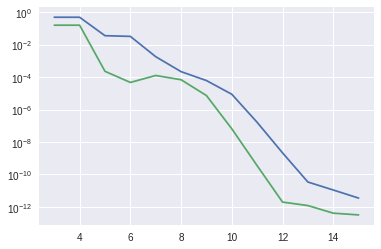

In [92]:
plt.semilogy(range(3, 16), MSE_SGP)

In [73]:
T1.GP_approx( 6,method = 'qPCA')

AttributeError: 'GPRegression' object has no attribute 'K'

## Benchamrking Neural Net numerical complexity

Results: -0.36 (0.07) MSE


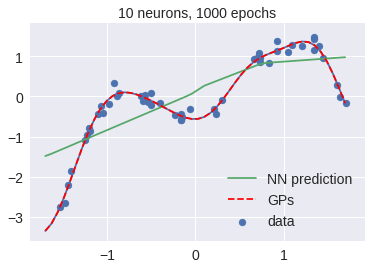

Results: -0.31 (0.07) MSE


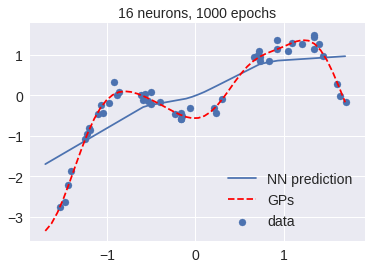

Results: -0.25 (0.06) MSE


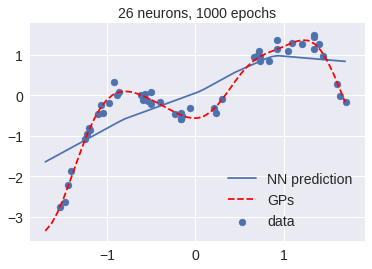

Results: -0.22 (0.02) MSE


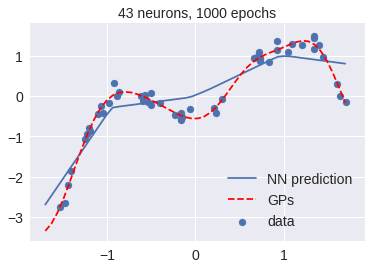

Results: -0.14 (0.05) MSE


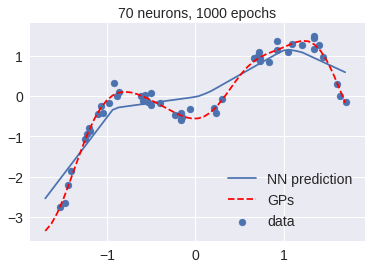

Results: -0.08 (0.04) MSE


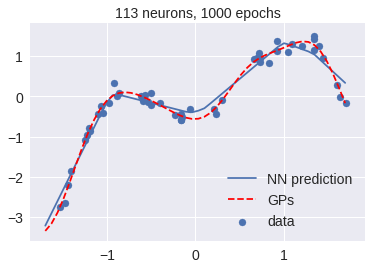

Results: -0.06 (0.02) MSE


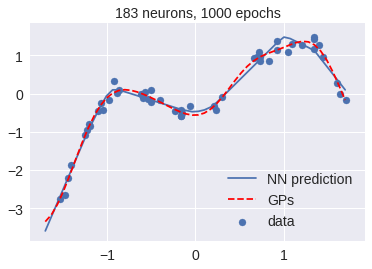

Results: -0.04 (0.03) MSE


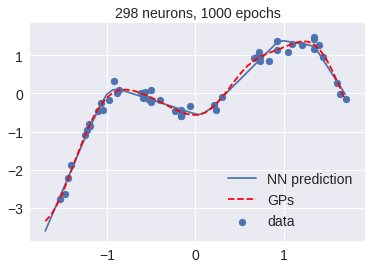

Results: -0.04 (0.03) MSE


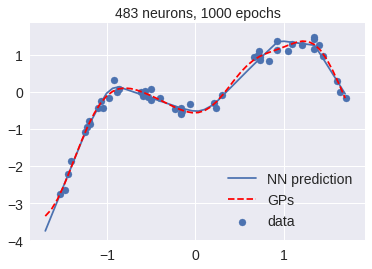

Results: -0.04 (0.02) MSE


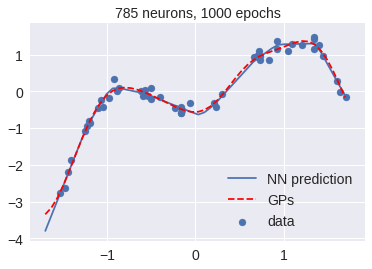

Results: -0.04 (0.02) MSE


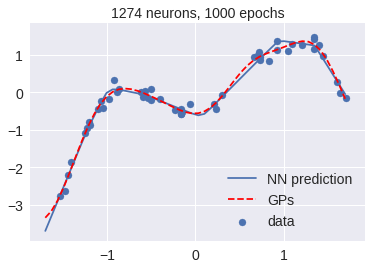

Results: -0.03 (0.01) MSE


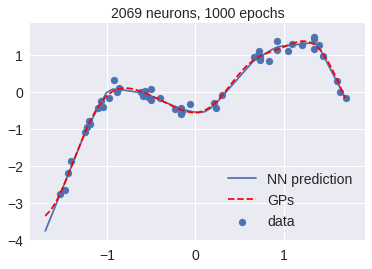

Results: -0.03 (0.01) MSE


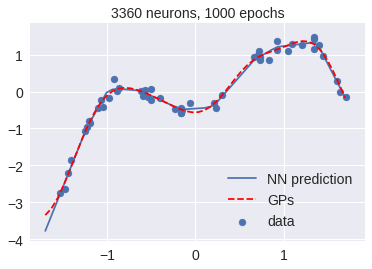

Results: -0.03 (0.01) MSE


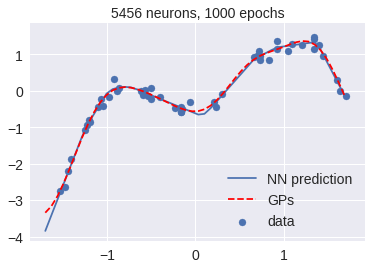

Results: -0.03 (0.01) MSE


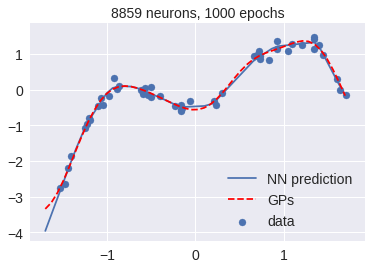

Results: -0.03 (0.01) MSE


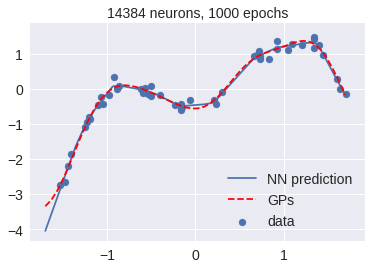

Results: -0.03 (0.01) MSE


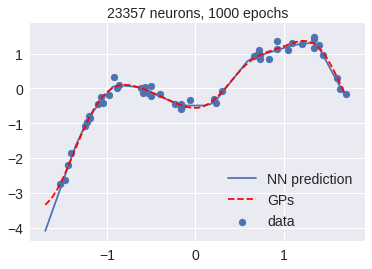

Results: -0.03 (0.01) MSE


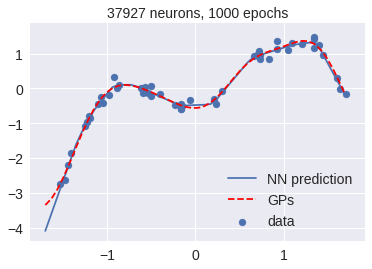

Results: -0.03 (0.01) MSE


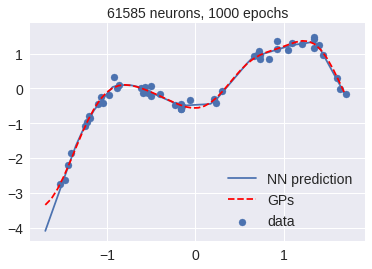

Results: -0.03 (0.01) MSE


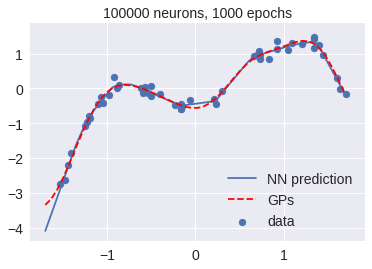

In [35]:
import time 

T1 = test_accuracy(x, y, Xnew)


MSE_nn = []
for epo in [1000]:
    mse_epo = []
    for n in np.round(np.logspace(1, 5, 20)):
        mse_epo.append(T1.MLP_NN_error(neurons1 = int(n), epochs = int(epo), plot = True))
        plt.show()
    MSE_nn.append(mse_epo)
    
    


In [28]:
NN_model = KerasRegressor(build_fn = create_model, batch_size=50, 
                                  neurons1 = 100, epochs=1000, verbose  = 0)

In [30]:
print(NN_model)

Text(0.5, 0, '# neurons')

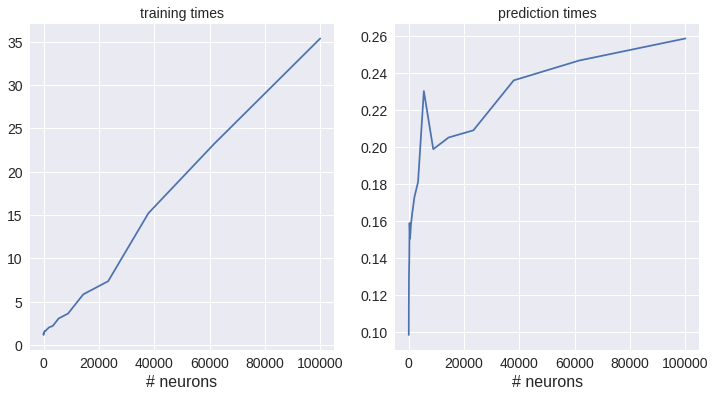

In [37]:
times = []

for lst in MSE_nn[0]:
    times.append(lst[2])
times = np.array(times)

ns = np.round(np.logspace(1, 5, 20))

plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.plot(ns, times[:, 0])
plt.title('training times')
plt.xlabel('# neurons')


plt.subplot(1,2,2)
plt.plot(ns, times[:, 1])
plt.title('prediction times')
plt.xlabel('# neurons')

In [28]:
np.array(MSE_nn).shape

(11, 7, 2)

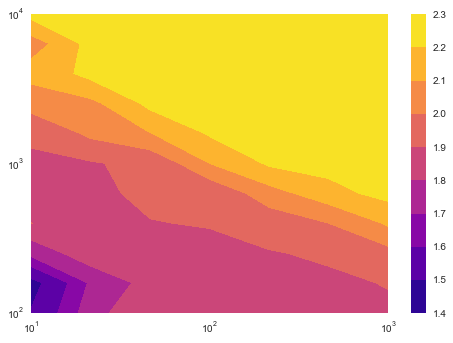

In [42]:
plt.contourf(np.logspace(1, 3, 7) ,np.logspace(2, 4, 11), np.array(MSE_nn)[:, :, 0], cmap = 'plasma')
plt.colorbar()
plt.xscale('log')
plt.yscale('log')

validation_res = np.array(MSE_nn)[:, :, 1]

In [58]:
validation_res[:, :][0]

array([array([-0.83542156, -1.8041569 , -1.05171049, -3.31020808, -2.81123018]),
       array([-1.12106276, -1.12567329, -2.39952803, -2.48104382, -0.9741804 ]),
       array([-0.83928663, -0.89362878, -1.49375451, -1.01383436, -0.8922354 ]),
       array([-0.40453425, -0.40334743, -0.95891935, -0.55671489, -0.47580498]),
       array([-0.39884427, -0.34398073, -0.4009493 , -0.32484883, -0.31856453]),
       array([-0.41303763, -0.34683973, -0.37755308, -0.3203868 , -0.31392622]),
       array([-0.37886447, -0.33486381, -0.36736742, -0.3046762 , -0.32535061])],
      dtype=object)

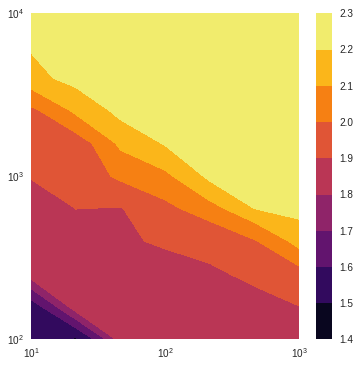

In [110]:
mean_mat = np.array(MSE_nn)
    
f = plt.figure(figsize=(6, 6))
plt.contourf(np.logspace(1, 3, 7) ,np.logspace(2, 4, 11),
             mean_mat , cmap = 'inferno', label = "Mean", origin = 'lower')
plt.xscale('log')
plt.yscale('log')
plt.colorbar()

In [111]:
MSE_nn

[[1.532978786286255,
  1.4874811450749172,
  1.8600866194155696,
  1.8826883888613215,
  1.8693471466647829,
  1.882995482754409,
  1.8888556894295165],
 [1.5463251626711962,
  1.8735455061026602,
  1.8413603737118813,
  1.8772833810380896,
  1.8896868948401326,
  1.8861828640554588,
  1.8993029253586902],
 [1.8634508913770311,
  1.8690015765737507,
  1.8690343870127355,
  1.8841768822710678,
  1.894347945321105,
  1.9105669056346872,
  1.9622301667689892],
 [1.8735236246582943,
  1.8892066989721814,
  1.895168144365287,
  1.906133630492687,
  1.9151302911652965,
  1.9921211459355188,
  2.1489581813703076],
 [1.8664607894404703,
  1.9002566478002703,
  1.8963765467970606,
  1.976538179365632,
  2.067089851298101,
  2.200340895387308,
  2.230859353498511],
 [1.9049513219331042,
  1.9416786582354286,
  2.0234235306833854,
  2.081845301408245,
  2.230208204726439,
  2.2355302146102822,
  2.2357532090522305],
 [1.9248382249582092,
  1.9521430976741911,
  2.125279084999756,
  2.209918075078

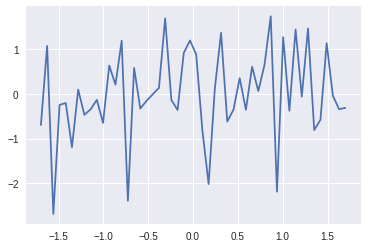

In [88]:
plt.plot(T1._xnew, T1._y)

In [23]:
T1._y.shape


(50, 1)

In [13]:
m_sp

In [16]:
Z

array([[0.71152476],
       [0.12427096],
       [0.01988013]])

In [17]:
m_sp.inducing_inputs

sparse_gp.inducing_inputs:
Param([[0.87294518],
       [0.44169717],
       [0.08234703]])

In [117]:
def create_model(input_dimensions = 1, neurons1 = 100,
                activation = 'relu', optimizer = 'adam', epochs = 10000):
    
    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, 
                    activation = activation)) # 1st hidden layer
    model.add(Dense(1))       
    model.compile(optimizer=optimizer, loss='mse')
    return model




In [119]:
NN_model = KerasRegressor(build_fn = create_model, batch_size=len(x), 
                               verbose  = 0, nuerons1 = 100, epochs = 4000)

history = NN_model.fit(x, y)
predictions = NN_model.predict(np.linspace(min(x), max(x), 100).reshape(-1, 1))#self._xnew)


plt.plot(np.linspace(min(x), max(x), 100).reshape(-1, 1), predictions)
plt.scatter(x, y)
plt.show()

ValueError: nuerons1 is not a legal parameter

In [37]:
# define base model
def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(1, input_dim=1, kernel_initializer='normal', 
                    activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model,
                           epochs=50, 
                           batch_size=5, verbose=1)
kfold = KFold(n_splits=5)
results = cross_val_score(estimator, x, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/50
40/40 [==============================] - 0s 4ms/step - loss: 3.5316
Epoch 2/50
40/40 [==============================] - 0s 199us/step - loss: 3.5020
Epoch 3/50
40/40 [==============================] - 0s 150us/step - loss: 3.4729
Epoch 4/50
40/40 [==============================] - 0s 149us/step - loss: 3.4418
Epoch 5/50
40/40 [==============================] - 0s 150us/step - loss: 3.4113
Epoch 6/50
40/40 [==============================] - 0s 150us/step - loss: 3.3776
Epoch 7/50
40/40 [==============================] - 0s 175us/step - loss: 3.3452
Epoch 8/50
40/40 [==============================] - 0s 150us/step - loss: 3.3108
Epoch 9/50
40/40 [==============================] - 0s 150us/step - loss: 3.2754
Epoch 10/50
40/40 [==============================] - 0s 150us/step - loss: 3.2390
Epoch 11/50
40/40 [==============================] - 0s 124us/step - loss: 3.2014
Epoch 12/50
40/40 [==============================] - 0s 175us/step - loss: 3.1634
Epoch 13/50
40/40 [========

Epoch 50/50
10/10 [==============================] - 0s 2ms/step
Epoch 1/50
40/40 [==============================] - 0s 4ms/step - loss: 2.9717
Epoch 2/50
40/40 [==============================] - 0s 125us/step - loss: 2.9497
Epoch 3/50
40/40 [==============================] - 0s 124us/step - loss: 2.9256
Epoch 4/50
40/40 [==============================] - 0s 150us/step - loss: 2.9028
Epoch 5/50
40/40 [==============================] - 0s 125us/step - loss: 2.8794
Epoch 6/50
40/40 [==============================] - 0s 150us/step - loss: 2.8551
Epoch 7/50
40/40 [==============================] - 0s 150us/step - loss: 2.8290
Epoch 8/50
40/40 [==============================] - 0s 150us/step - loss: 2.8027
Epoch 9/50
40/40 [==============================] - 0s 175us/step - loss: 2.7747
Epoch 10/50
40/40 [==============================] - 0s 150us/step - loss: 2.7456
Epoch 11/50
40/40 [==============================] - 0s 149us/step - loss: 2.7133
Epoch 12/50
40/40 [=========================

In [42]:
estimator.evaluate(x, y)

AttributeError: 'KerasRegressor' object has no attribute 'evaluate'

In [112]:
estimator

NameError: name 'estimator' is not defined

In [134]:
# MLP
def create_model(input_dimensions = 1, neurons1 = 100,
                activation = 'relu', optimizer = 'adam'):

    model = Sequential()
    model.add(Dense(neurons1, input_dim=input_dimensions, 
                    activation = activation)) # 1st hidden layer
    #model.add(Dense(100, activation = activation))
    #model.add(Dense(200, activation = activation))
    model.add(Dense(1))       
    model.compile(optimizer=optimizer, loss='mse')
    
    return model

NN_model = KerasRegressor(build_fn = create_model, batch_size=50, 
                          epochs=1000, verbose  = 0)

kfold = KFold(n_splits=10)
results = cross_val_score(NN_model, x, y, cv=kfold)
print("Baseline: %.2f (%.2f) MSE" % (results.mean(), results.std()))


from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train = sc_X.fit_transform(x.reshape(-1, 1))

sc_Y = StandardScaler()
Y_train = sc_Y.fit_transform(y.reshape(-1, 1))
history = NN_model.fit(X_train, Y_train)

Baseline: -0.35 (0.16) MSE


In [135]:
results

array([-0.5386883 , -0.13251744, -0.44527096, -0.2541579 , -0.42735624,
       -0.28475618, -0.20966378, -0.43126497, -0.62308037, -0.11672511])

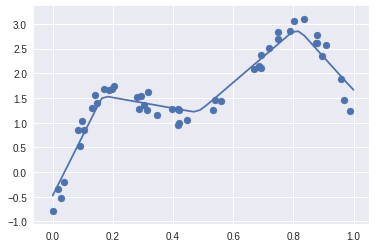

In [123]:
predictions = sc_Y.inverse_transform(NN_model.predict(sc_X.transform(Xnew.reshape(-1, 1))))
plt.plot(Xnew, predictions)
plt.scatter(x, y)

In [131]:
print(NN_model)

In [130]:
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=3)
results = cross_val_score(NN_model, x, y, cv=kfold)
print(results.mean())

ValueError: Supported target types are: ('binary', 'multiclass'). Got 'continuous' instead.

In [ ]:
predictions = sc_Y.inverse_transform(NN_model.predict(Xnew.reshape(-1, 1)))
plt.plot(Xnew, predictions)

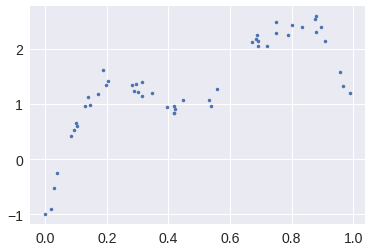

In [70]:
#defin sample data:
np.random.seed(1)
n = 50
x = np.random.rand( n)
y =  2*x + np.sin(17*(x-0.5)**2) + np.random.randn(n) * 0.15
#Xnew = np.linspace(0, 1, n)
Xnew = np.linspace(min(x), max(x), n)
plt.plot(x,  y, '.')

D = Dataset(x, y, Xnew)

idx = np.argsort(D.x, axis = 0)
D.x = D.x[idx.reshape(-1 )]
D.y = D.y[idx.reshape(-1 )]

In [71]:
D.m

In [72]:
x

array([4.17022005e-01, 7.20324493e-01, 1.14374817e-04, 3.02332573e-01,
       1.46755891e-01, 9.23385948e-02, 1.86260211e-01, 3.45560727e-01,
       3.96767474e-01, 5.38816734e-01, 4.19194514e-01, 6.85219500e-01,
       2.04452250e-01, 8.78117436e-01, 2.73875932e-02, 6.70467510e-01,
       4.17304802e-01, 5.58689828e-01, 1.40386939e-01, 1.98101489e-01,
       8.00744569e-01, 9.68261576e-01, 3.13424178e-01, 6.92322616e-01,
       8.76389152e-01, 8.94606664e-01, 8.50442114e-02, 3.90547832e-02,
       1.69830420e-01, 8.78142503e-01, 9.83468338e-02, 4.21107625e-01,
       9.57889530e-01, 5.33165285e-01, 6.91877114e-01, 3.15515631e-01,
       6.86500928e-01, 8.34625672e-01, 1.82882773e-02, 7.50144315e-01,
       9.88861089e-01, 7.48165654e-01, 2.80443992e-01, 7.89279328e-01,
       1.03226007e-01, 4.47893526e-01, 9.08595503e-01, 2.93614148e-01,
       2.87775339e-01, 1.30028572e-01])

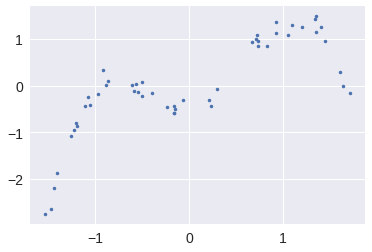

In [73]:
plt.plot(D.x, D.y, '.')

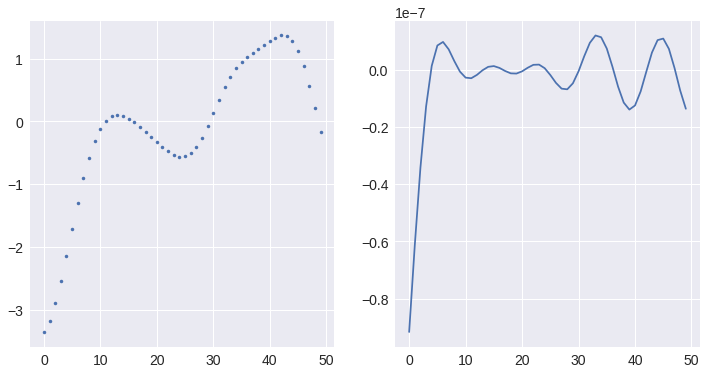

In [78]:
K = D.m.kern.K(D.x, D.x)
#mu = D.m.kern.K(D.x, D.xnew)@ np.linalg.inv(K+np.eye(len(K))*D.m.Gaussian_noise.variance)@D.y
mu = D.m.kern.K(D.xnew, D.x)@ np.linalg.inv(K+np.eye(len(K))*D.m.Gaussian_noise.variance)@D.y


plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
plt.plot(mu, '.')

plt.subplot(1, 2, 2)
plt.plot(mu - D.mu_gp)